##### Copyright 2019 The TensorFlow Authors.

In [2]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Time series forecasting

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/structured_data/time_series"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial is an introduction to time series forecasting using TensorFlow. It builds a few different styles of models including Convolutional and Recurrent Neural Networks (CNNs and RNNs).

This is covered in two main parts, with subsections: 

* Forecast for a single time step:
  * A single feature.
  * All features.
* Forecast multiple steps:
  * Single-shot: Make the predictions all at once.
  * Autoregressive: Make one prediction at a time and feed the output back to the model.

## Setup

In [3]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

# mpl.rcParams['figure.figsize'] = (4, 3)
#mpl.rcParams['axes.grid'] = False

2023-01-16 12:29:54.128108: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-16 12:29:54.256187: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


2023-01-16 12:29:54.870918: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/leon/bebopalula/cpp/libs/my_libs/lib
2023-01-16 12:29:54.870990: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/leon/bebopalula/cpp/libs/my_libs/lib
2023-01-16 12:29:54.870997: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


## The weather dataset

This tutorial uses a <a href="https://www.bgc-jena.mpg.de/wetter/" class="external">weather time series dataset</a> recorded by the <a href="https://www.bgc-jena.mpg.de" class="external">Max Planck Institute for Biogeochemistry</a>.

This dataset contains 14 different features such as air temperature, atmospheric pressure, and humidity. These were collected every 10 minutes, beginning in 2003. For efficiency, you will use only the data collected between 2009 and 2016. This section of the dataset was prepared by François Chollet for his book <a href="https://www.manning.com/books/deep-learning-with-python" class="external">Deep Learning with Python</a>.

In [4]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

This tutorial will just deal with **hourly predictions**, so start by sub-sampling the data from 10-minute intervals to one-hour intervals:

In [5]:
df = pd.read_csv(csv_path)
# Slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

Let's take a glance at the data. Here are the first few rows:

In [6]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


Here is the evolution of a few features over time:

/tmp/ipykernel_415333/637349053.py:7: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plot_features.index = date_time[:480]


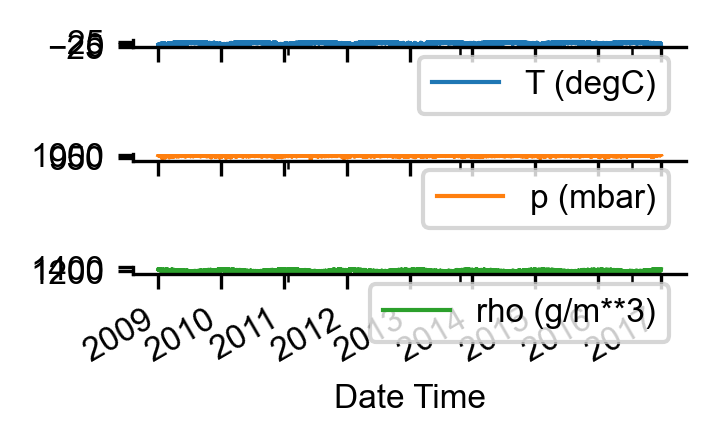

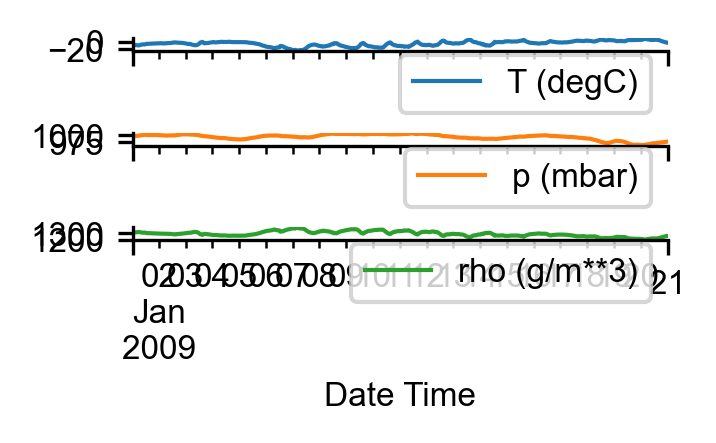

In [7]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

### Inspect and cleanup

Next, look at the statistics of the dataset:

In [6]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


#### Wind velocity

One thing that should stand out is the `min` value of the wind velocity (`wv (m/s)`) and the maximum value (`max. wv (m/s)`) columns. This `-9999` is likely erroneous.

There's a separate wind direction column, so the velocity should be greater than zero (`>=0`). Replace it with zeros:

In [7]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame.
df['wv (m/s)'].min()

0.0

### Feature engineering

Before diving in to build a model, it's important to understand your data and be sure that you're passing the model appropriately formatted data.

#### Wind
The last column of the data, `wd (deg)`—gives the wind direction in units of degrees. Angles do not make good model inputs: 360° and 0° should be close to each other and wrap around smoothly. Direction shouldn't matter if the wind is not blowing.

Right now the distribution of wind data looks like this:

Text(0, 0.5, 'Wind Velocity [m/s]')

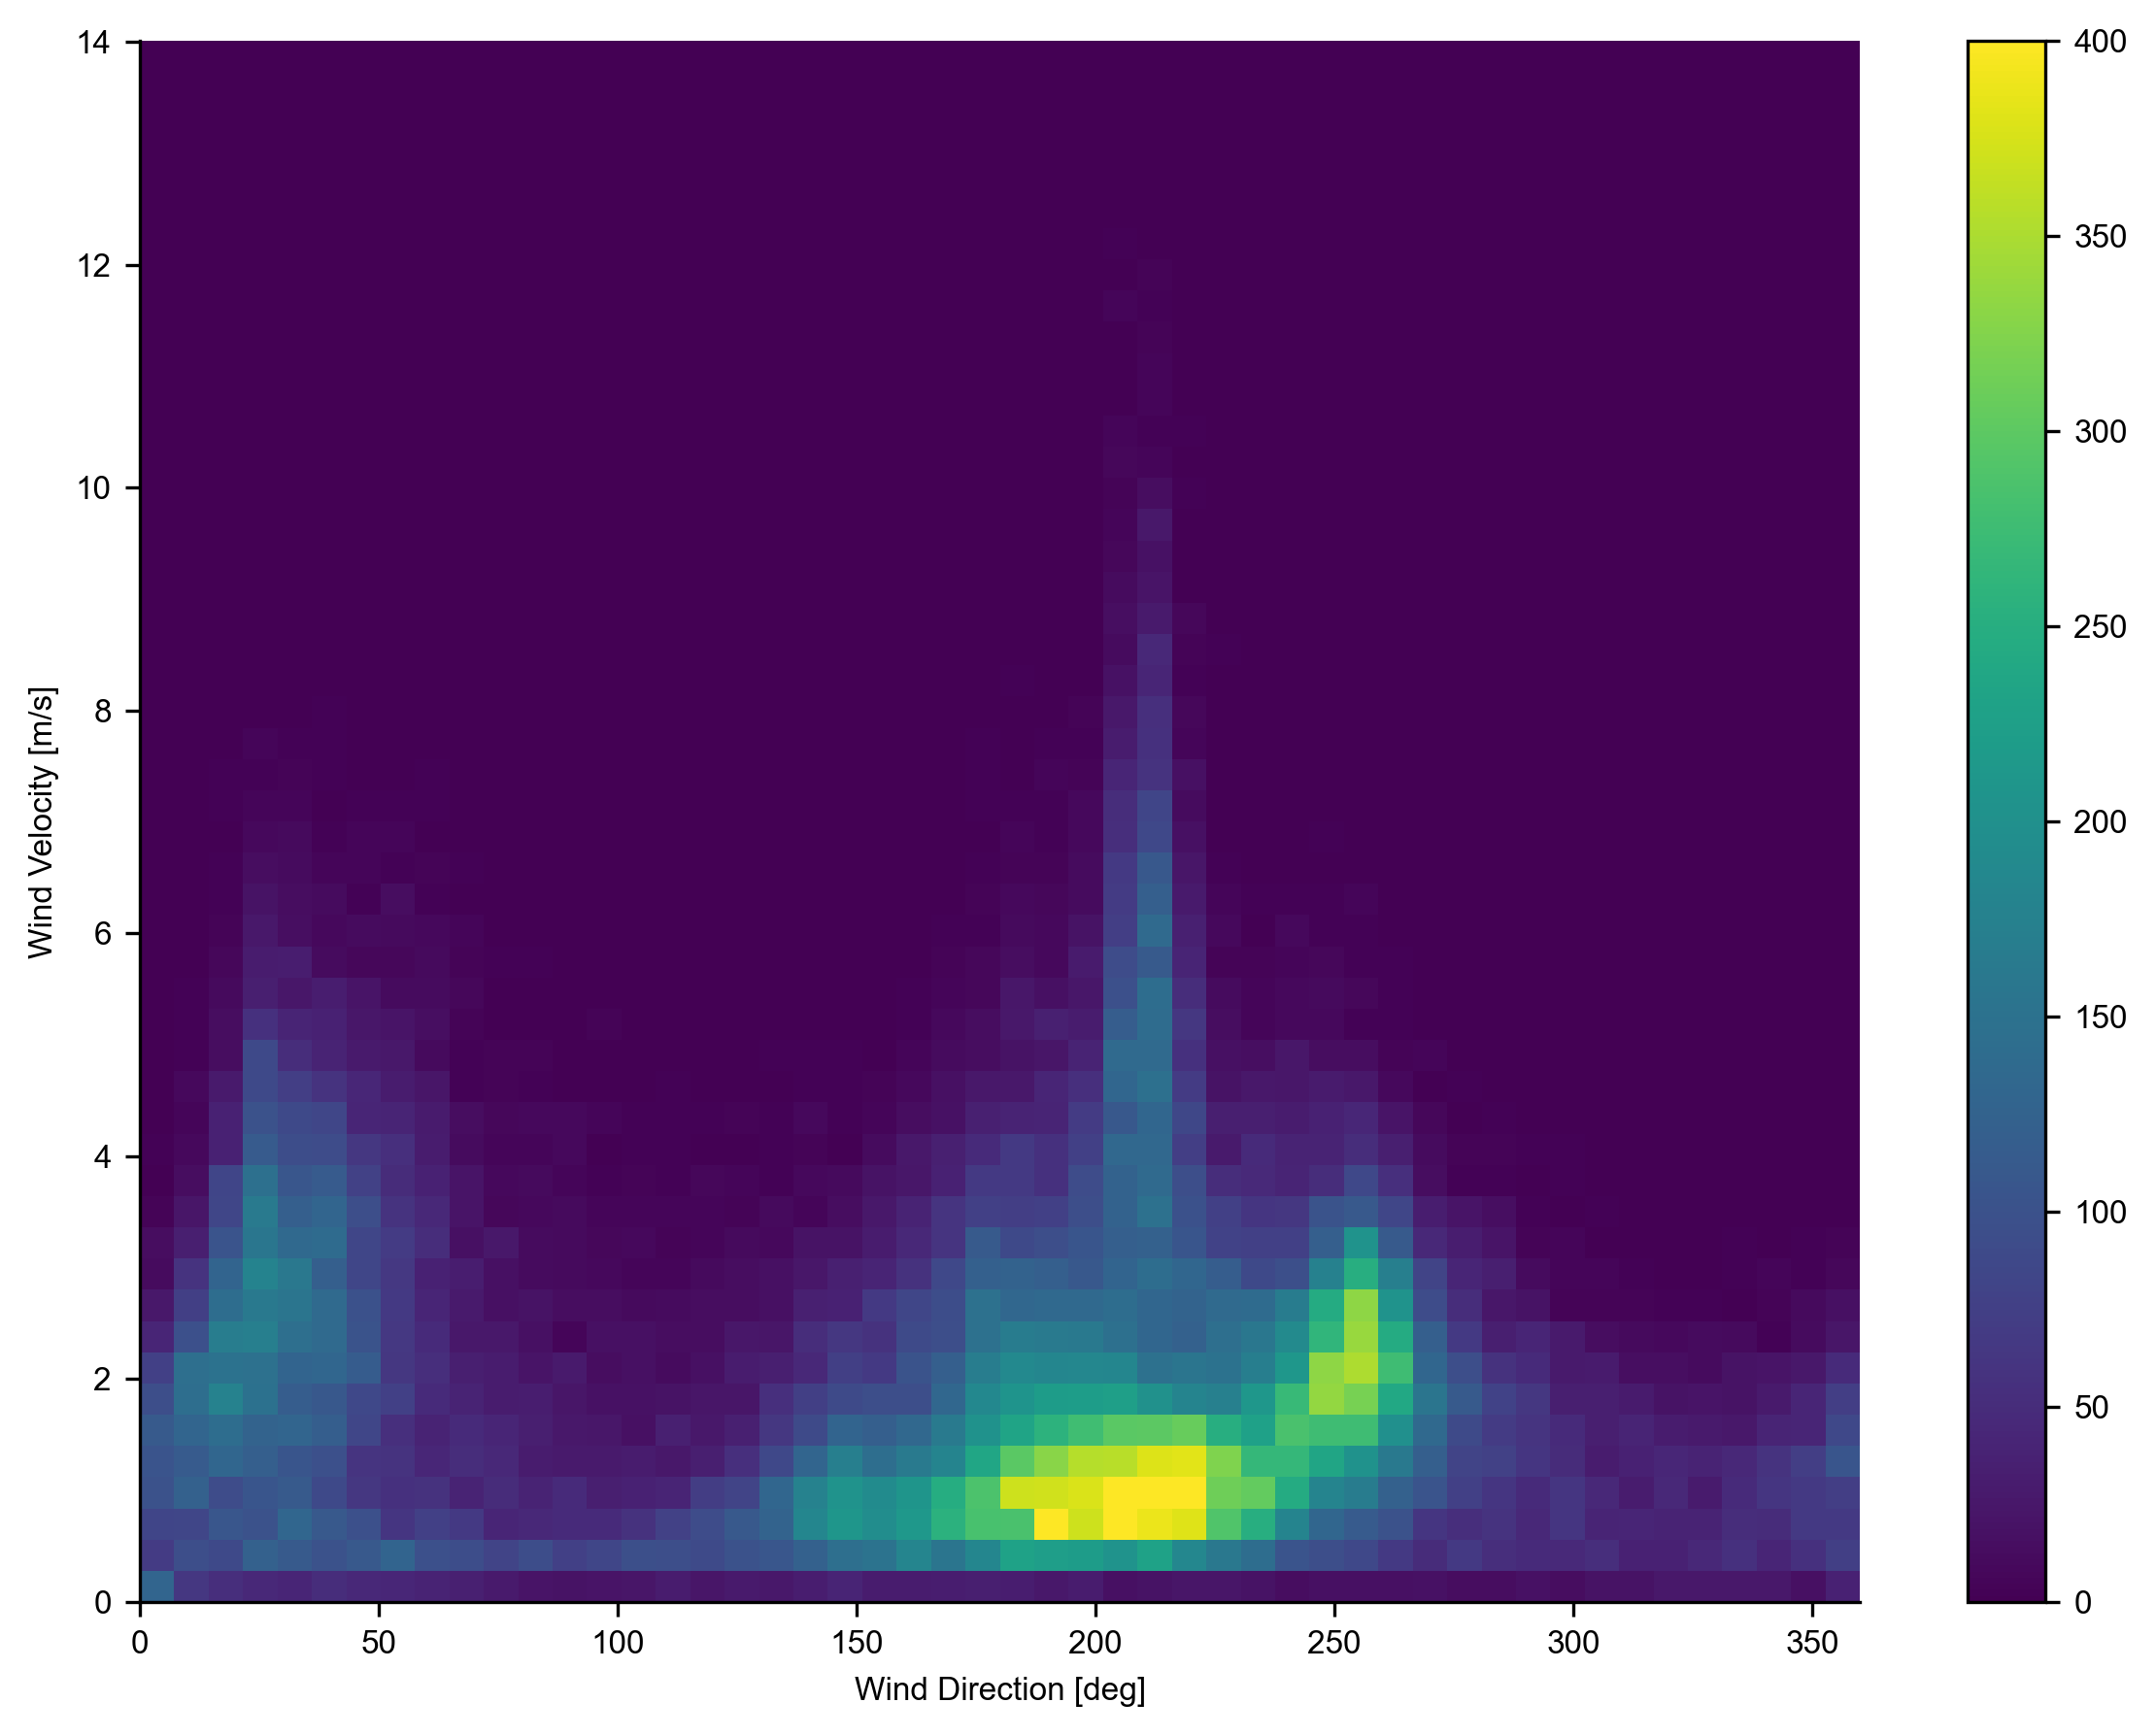

In [8]:
plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

But this will be easier for the model to interpret if you convert the wind direction and velocity columns to a wind **vector**:

In [9]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

The distribution of wind vectors is much simpler for the model to correctly interpret:

(-11.30551397313467, 8.244699285490789, -8.274385403355149, 7.733831295546778)

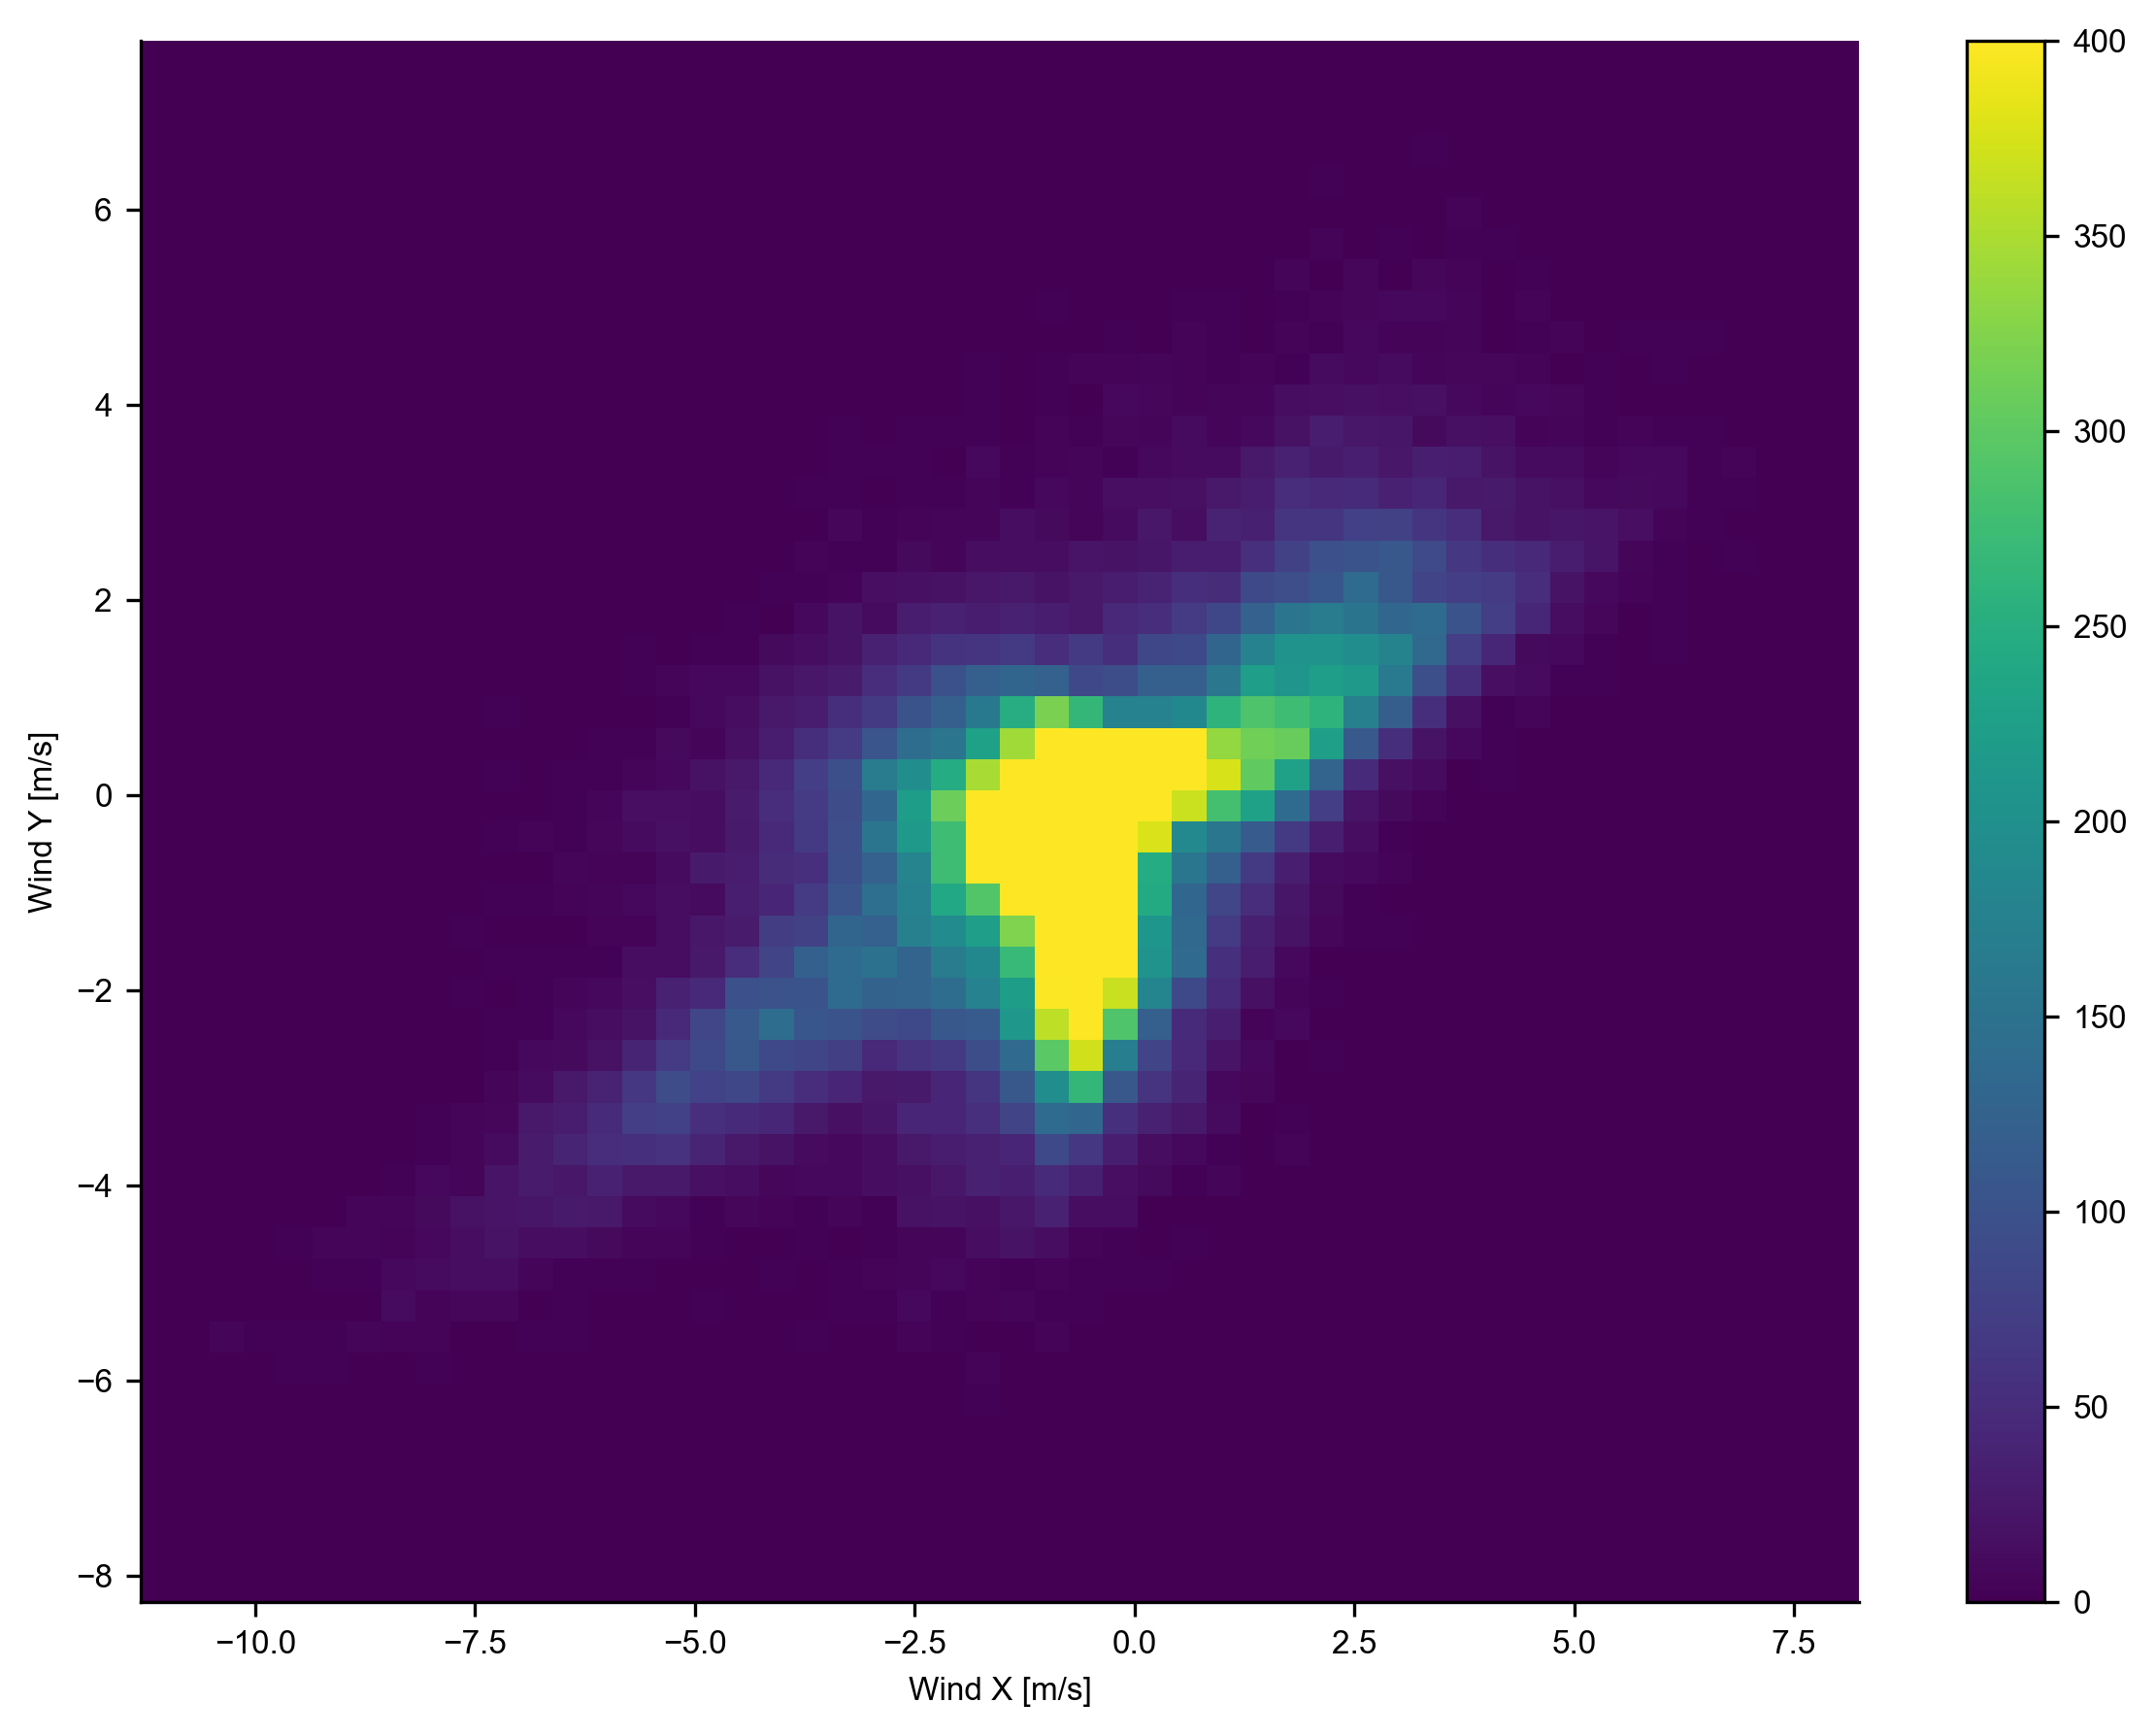

In [10]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

#### Time

Similarly, the `Date Time` column is very useful, but not in this string form. Start by converting it to seconds:

In [11]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

Similar to the wind direction, the time in seconds is not a useful model input. Being weather data, it has clear daily and yearly periodicity. There are many ways you could deal with periodicity.

You can get usable signals by using sine and cosine transforms to clear "Time of day" and "Time of year" signals:

In [12]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

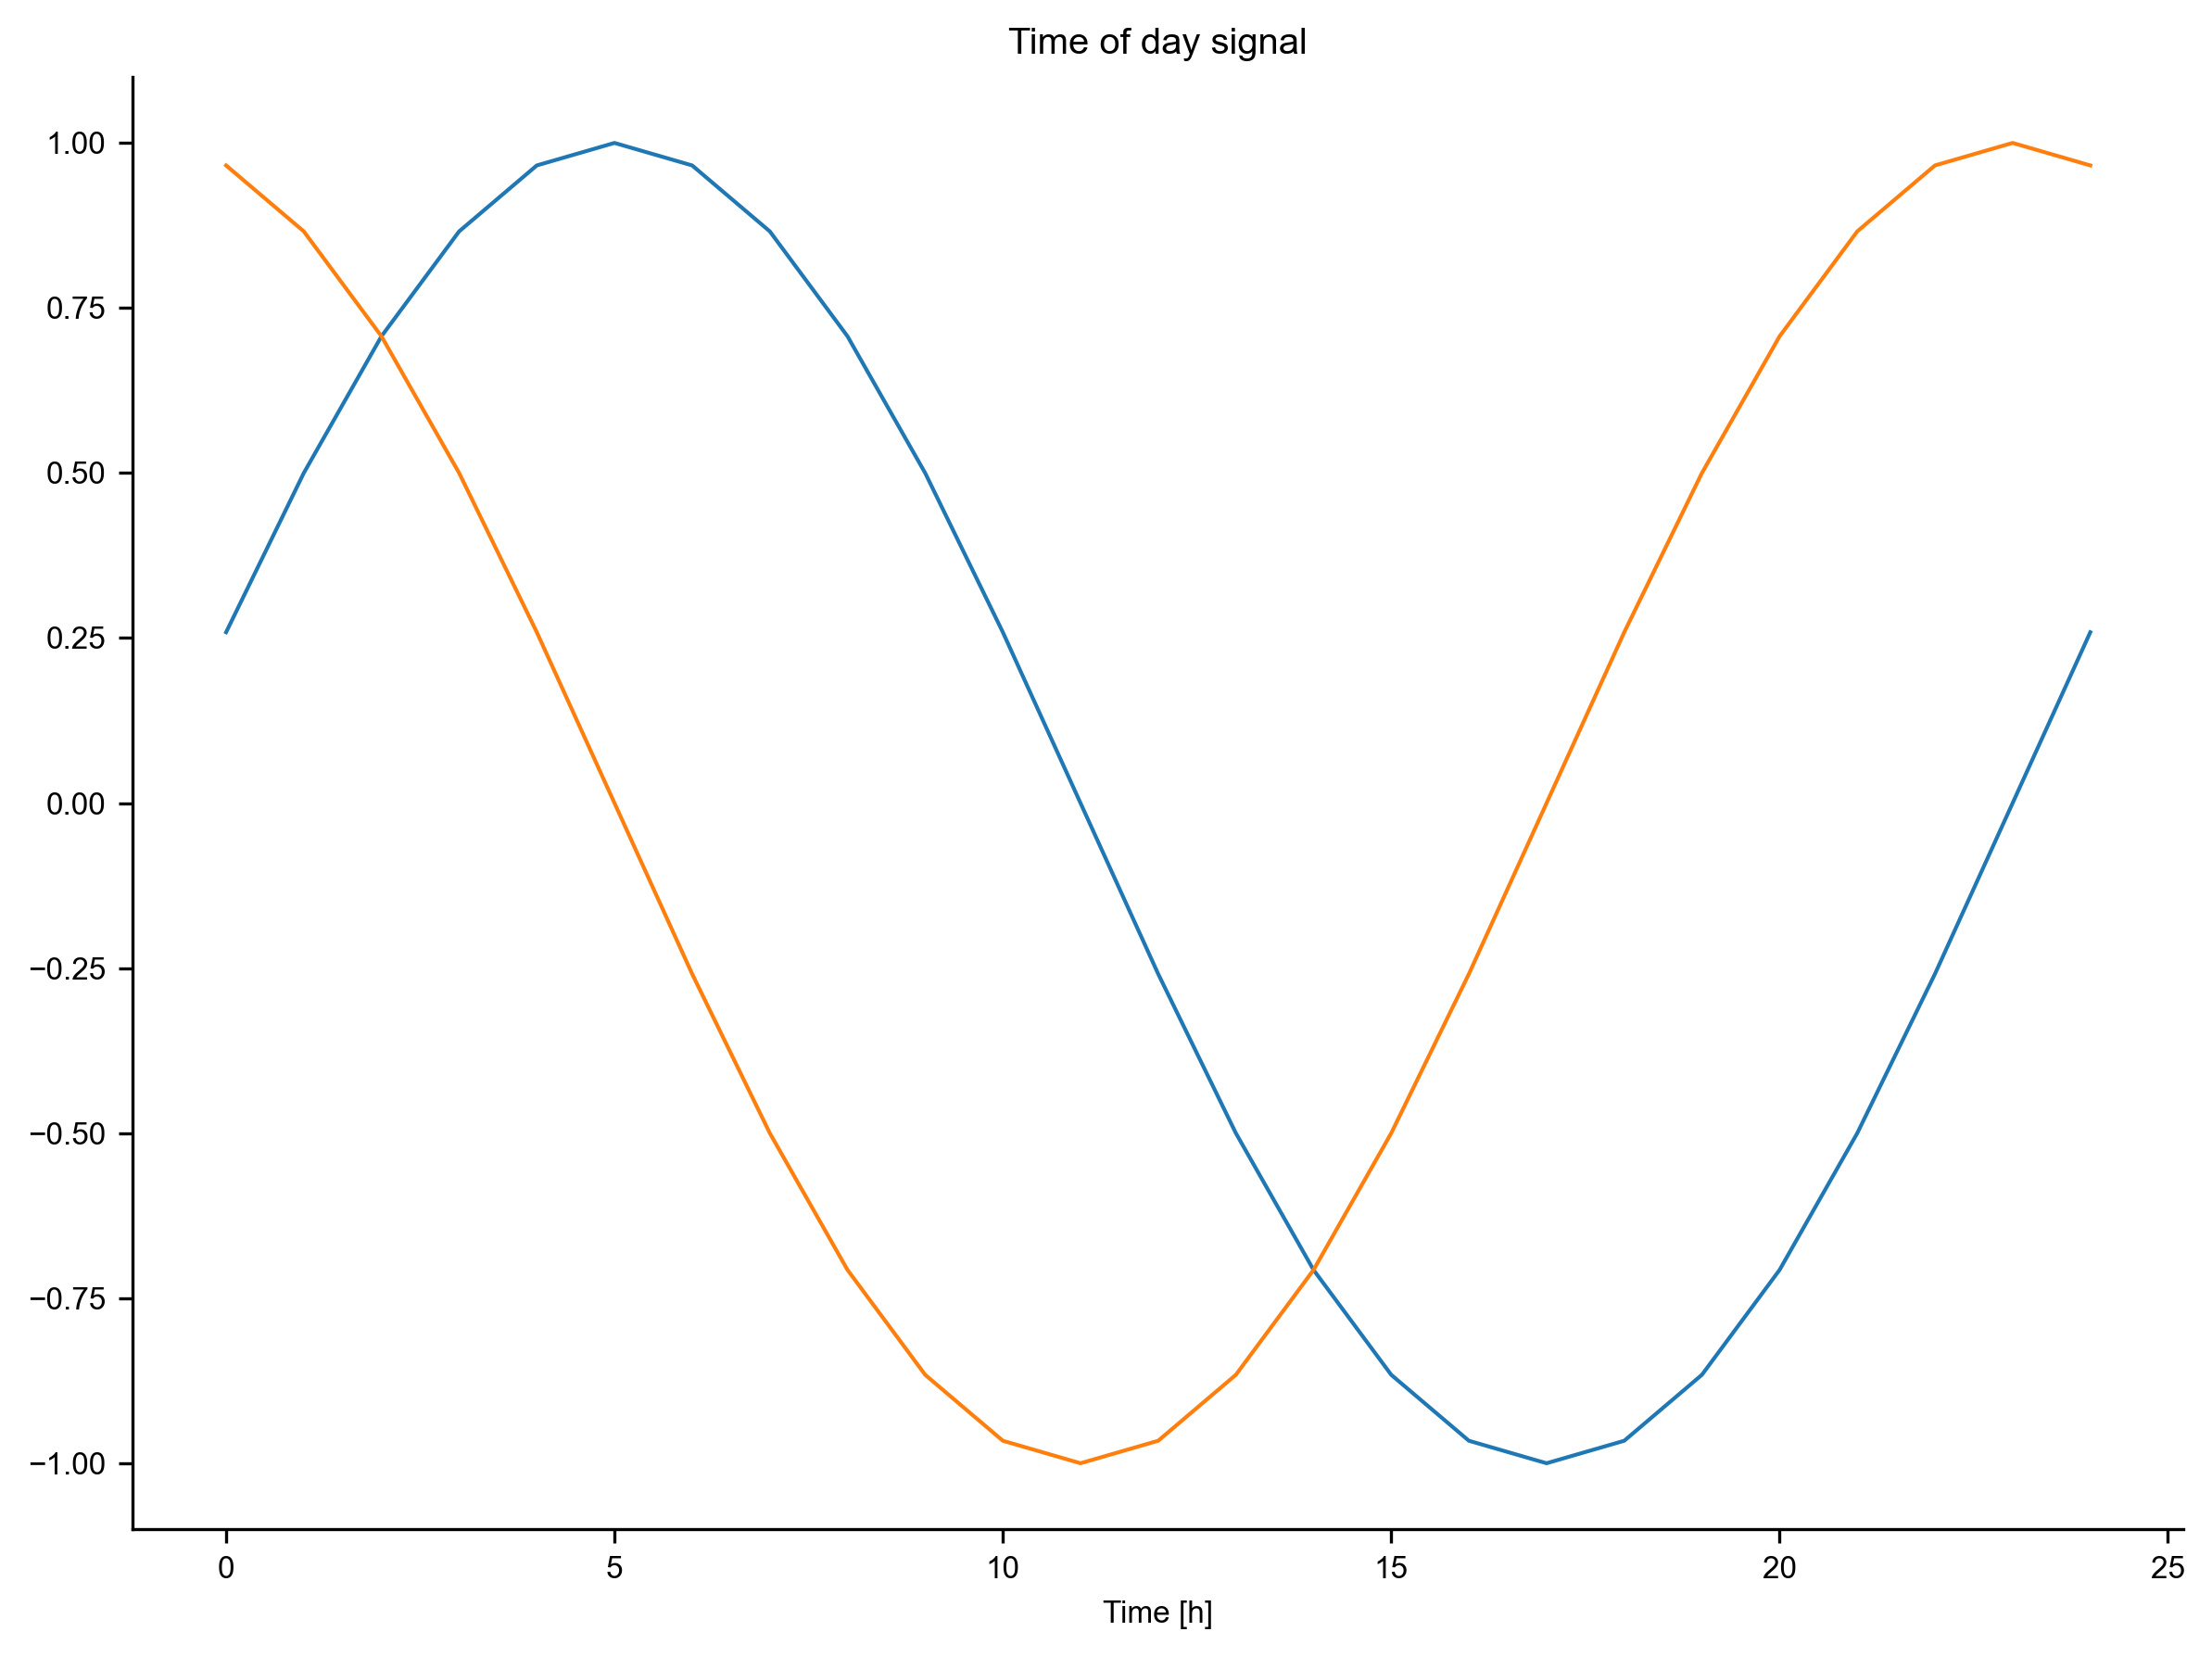

In [13]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

This gives the model access to the most important frequency features. In this case you knew ahead of time which frequencies were important. 

If you don't have that information, you can determine which frequencies are important by extracting features with <a href="https://en.wikipedia.org/wiki/Fast_Fourier_transform" class="external">Fast Fourier Transform</a>. To check the assumptions, here is the `tf.signal.rfft` of the temperature over time. Note the obvious peaks at frequencies near `1/year` and `1/day`:


2023-01-16 11:43:02.771896: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/leon/bebopalula/cpp/libs/my_libs/lib
2023-01-16 11:43:02.771965: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-01-16 11:43:02.773596: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebu

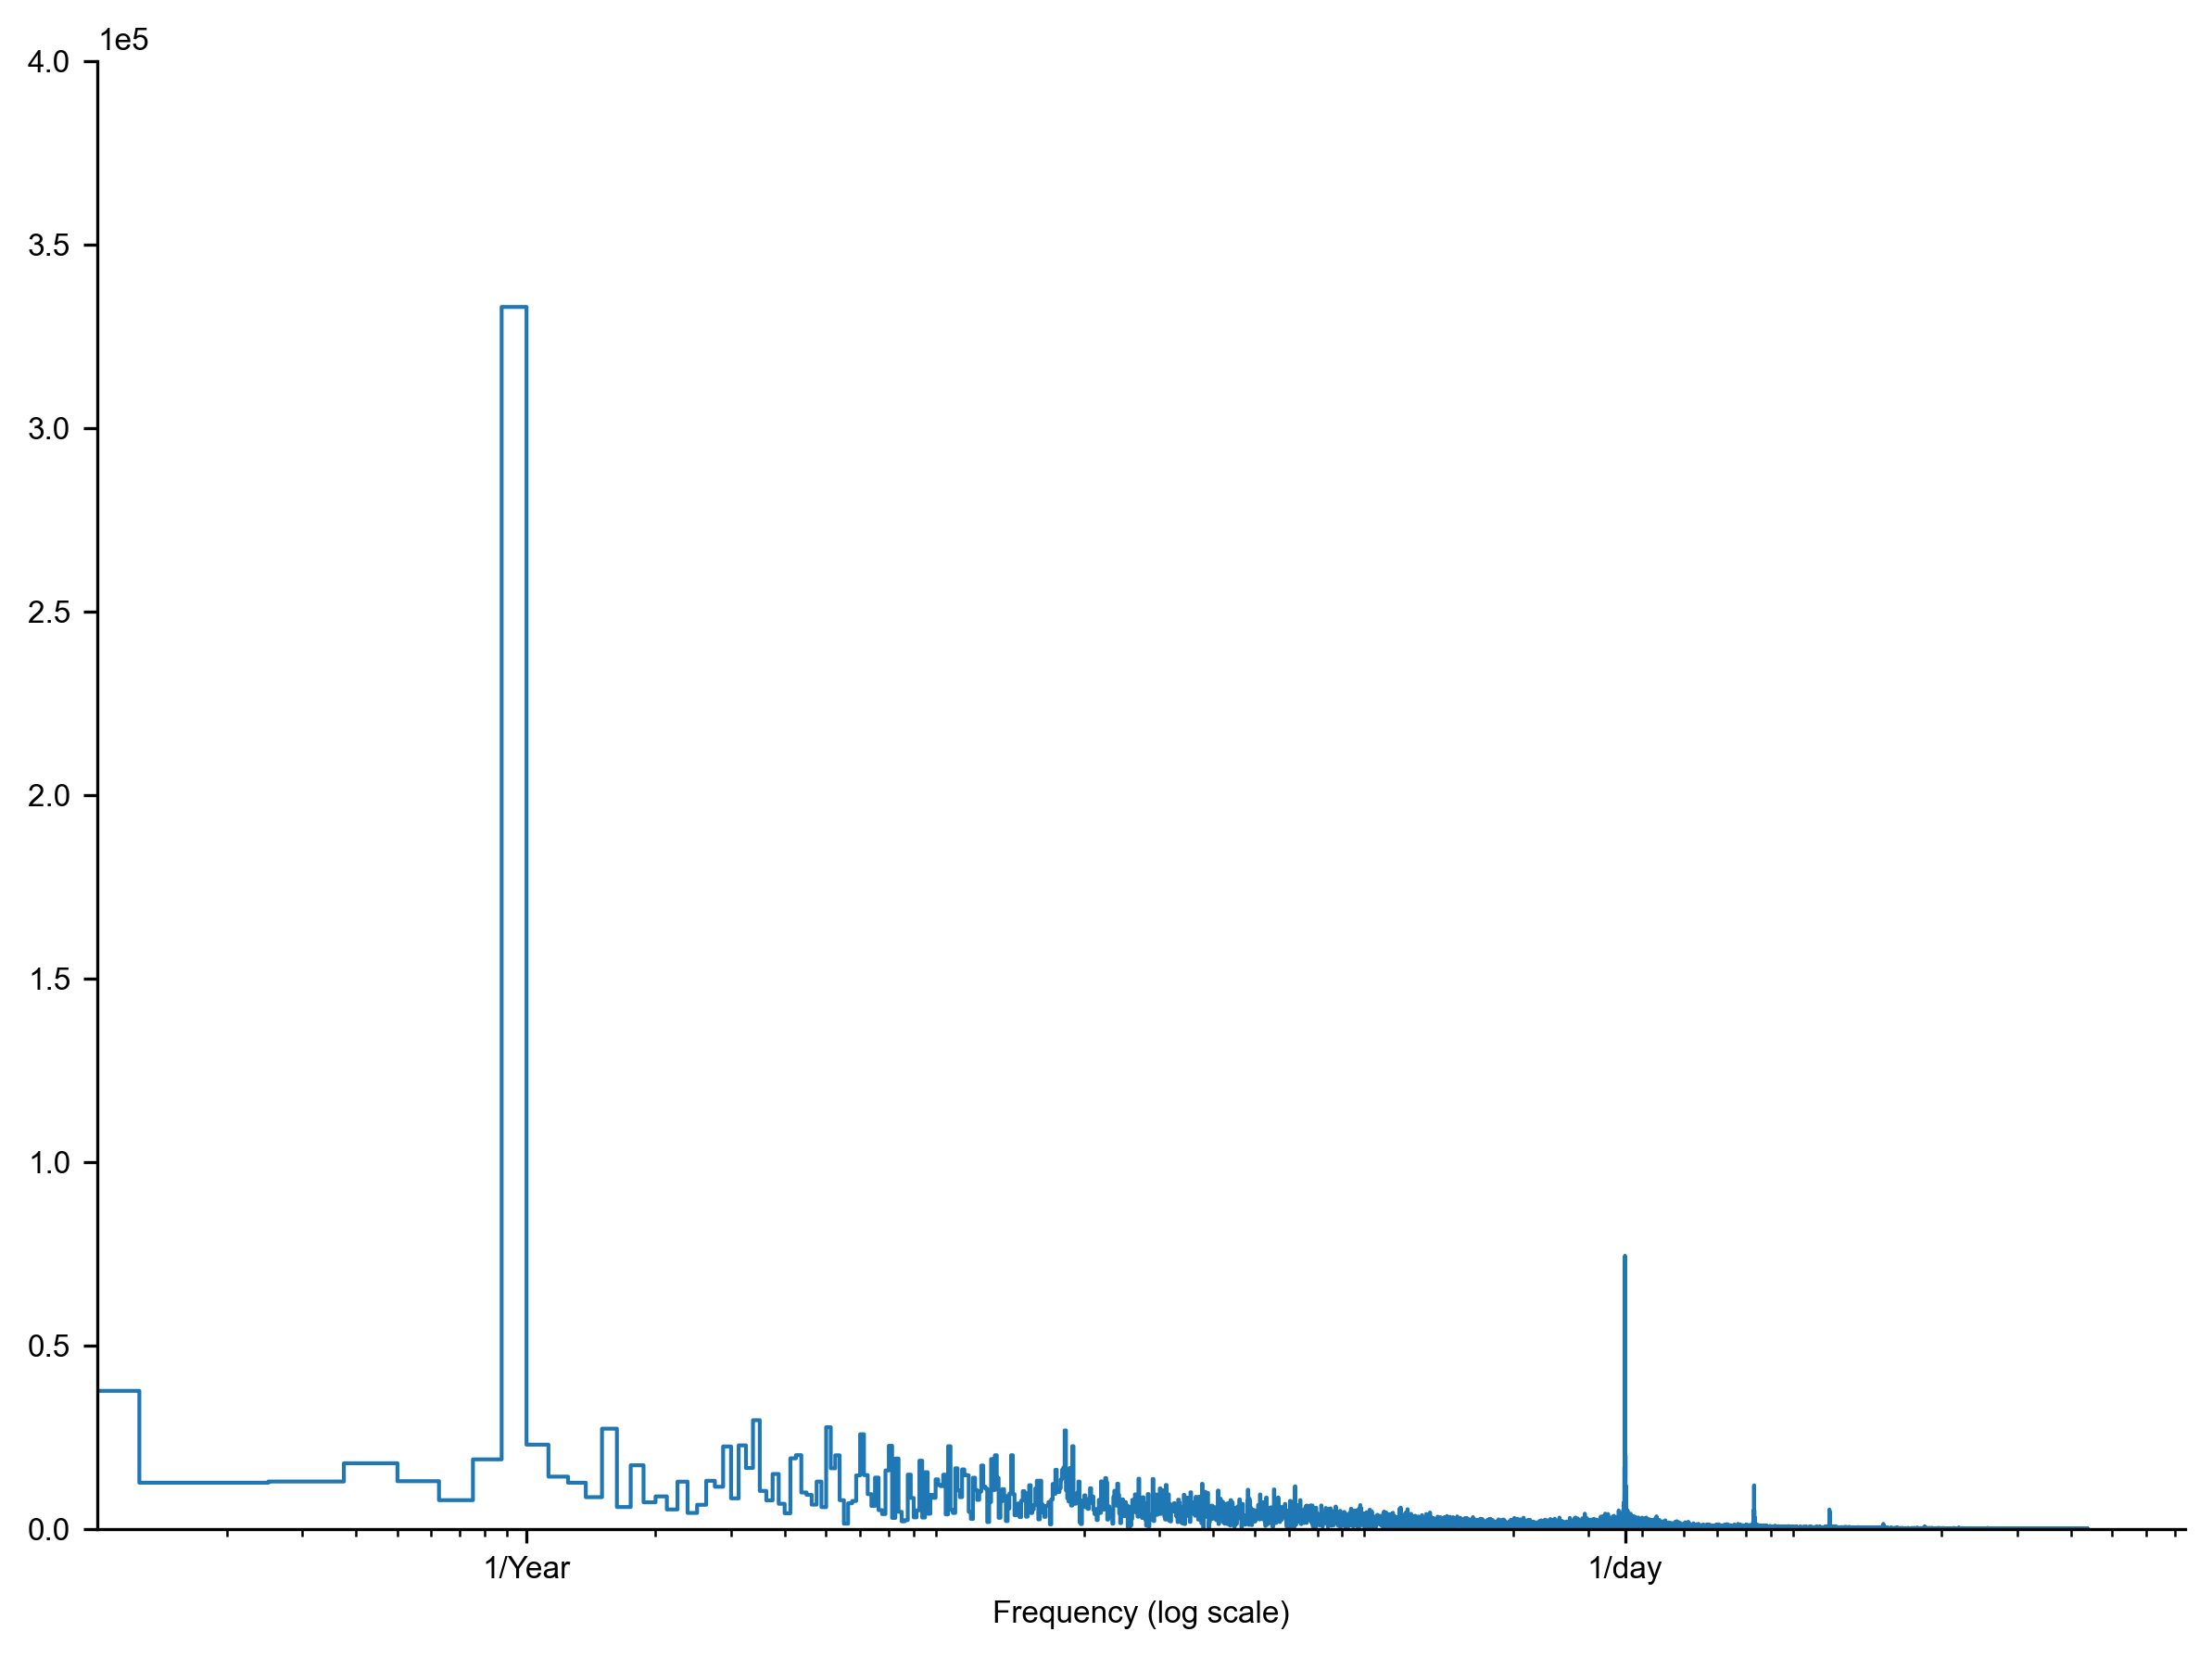

In [14]:
fft = tf.signal.rfft(df['T (degC)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['T (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

### Split the data

You'll use a `(70%, 20%, 10%)` split for the training, validation, and test sets. Note the data is **not** being randomly shuffled before splitting. This is for two reasons:

1. It ensures that chopping the data into windows of consecutive samples is still possible.
2. It ensures that the validation/test results are more realistic, being evaluated on the data collected after the model was trained.

In [15]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

### Normalize the data

It is important to scale features before training a neural network. Normalization is a common way of doing this scaling: subtract the mean and divide by the standard deviation of each feature.

The mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets.

It's also arguable that the model shouldn't have access to future values in the training set when training, and that this normalization should be done using moving averages. That's not the focus of this tutorial, and the validation and test sets ensure that you get (somewhat) honest metrics. So, in the interest of simplicity this tutorial uses a simple average.

In [16]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

Now, peek at the distribution of the features. Some features do have long tails, but there are no obvious errors like the `-9999` wind velocity value.

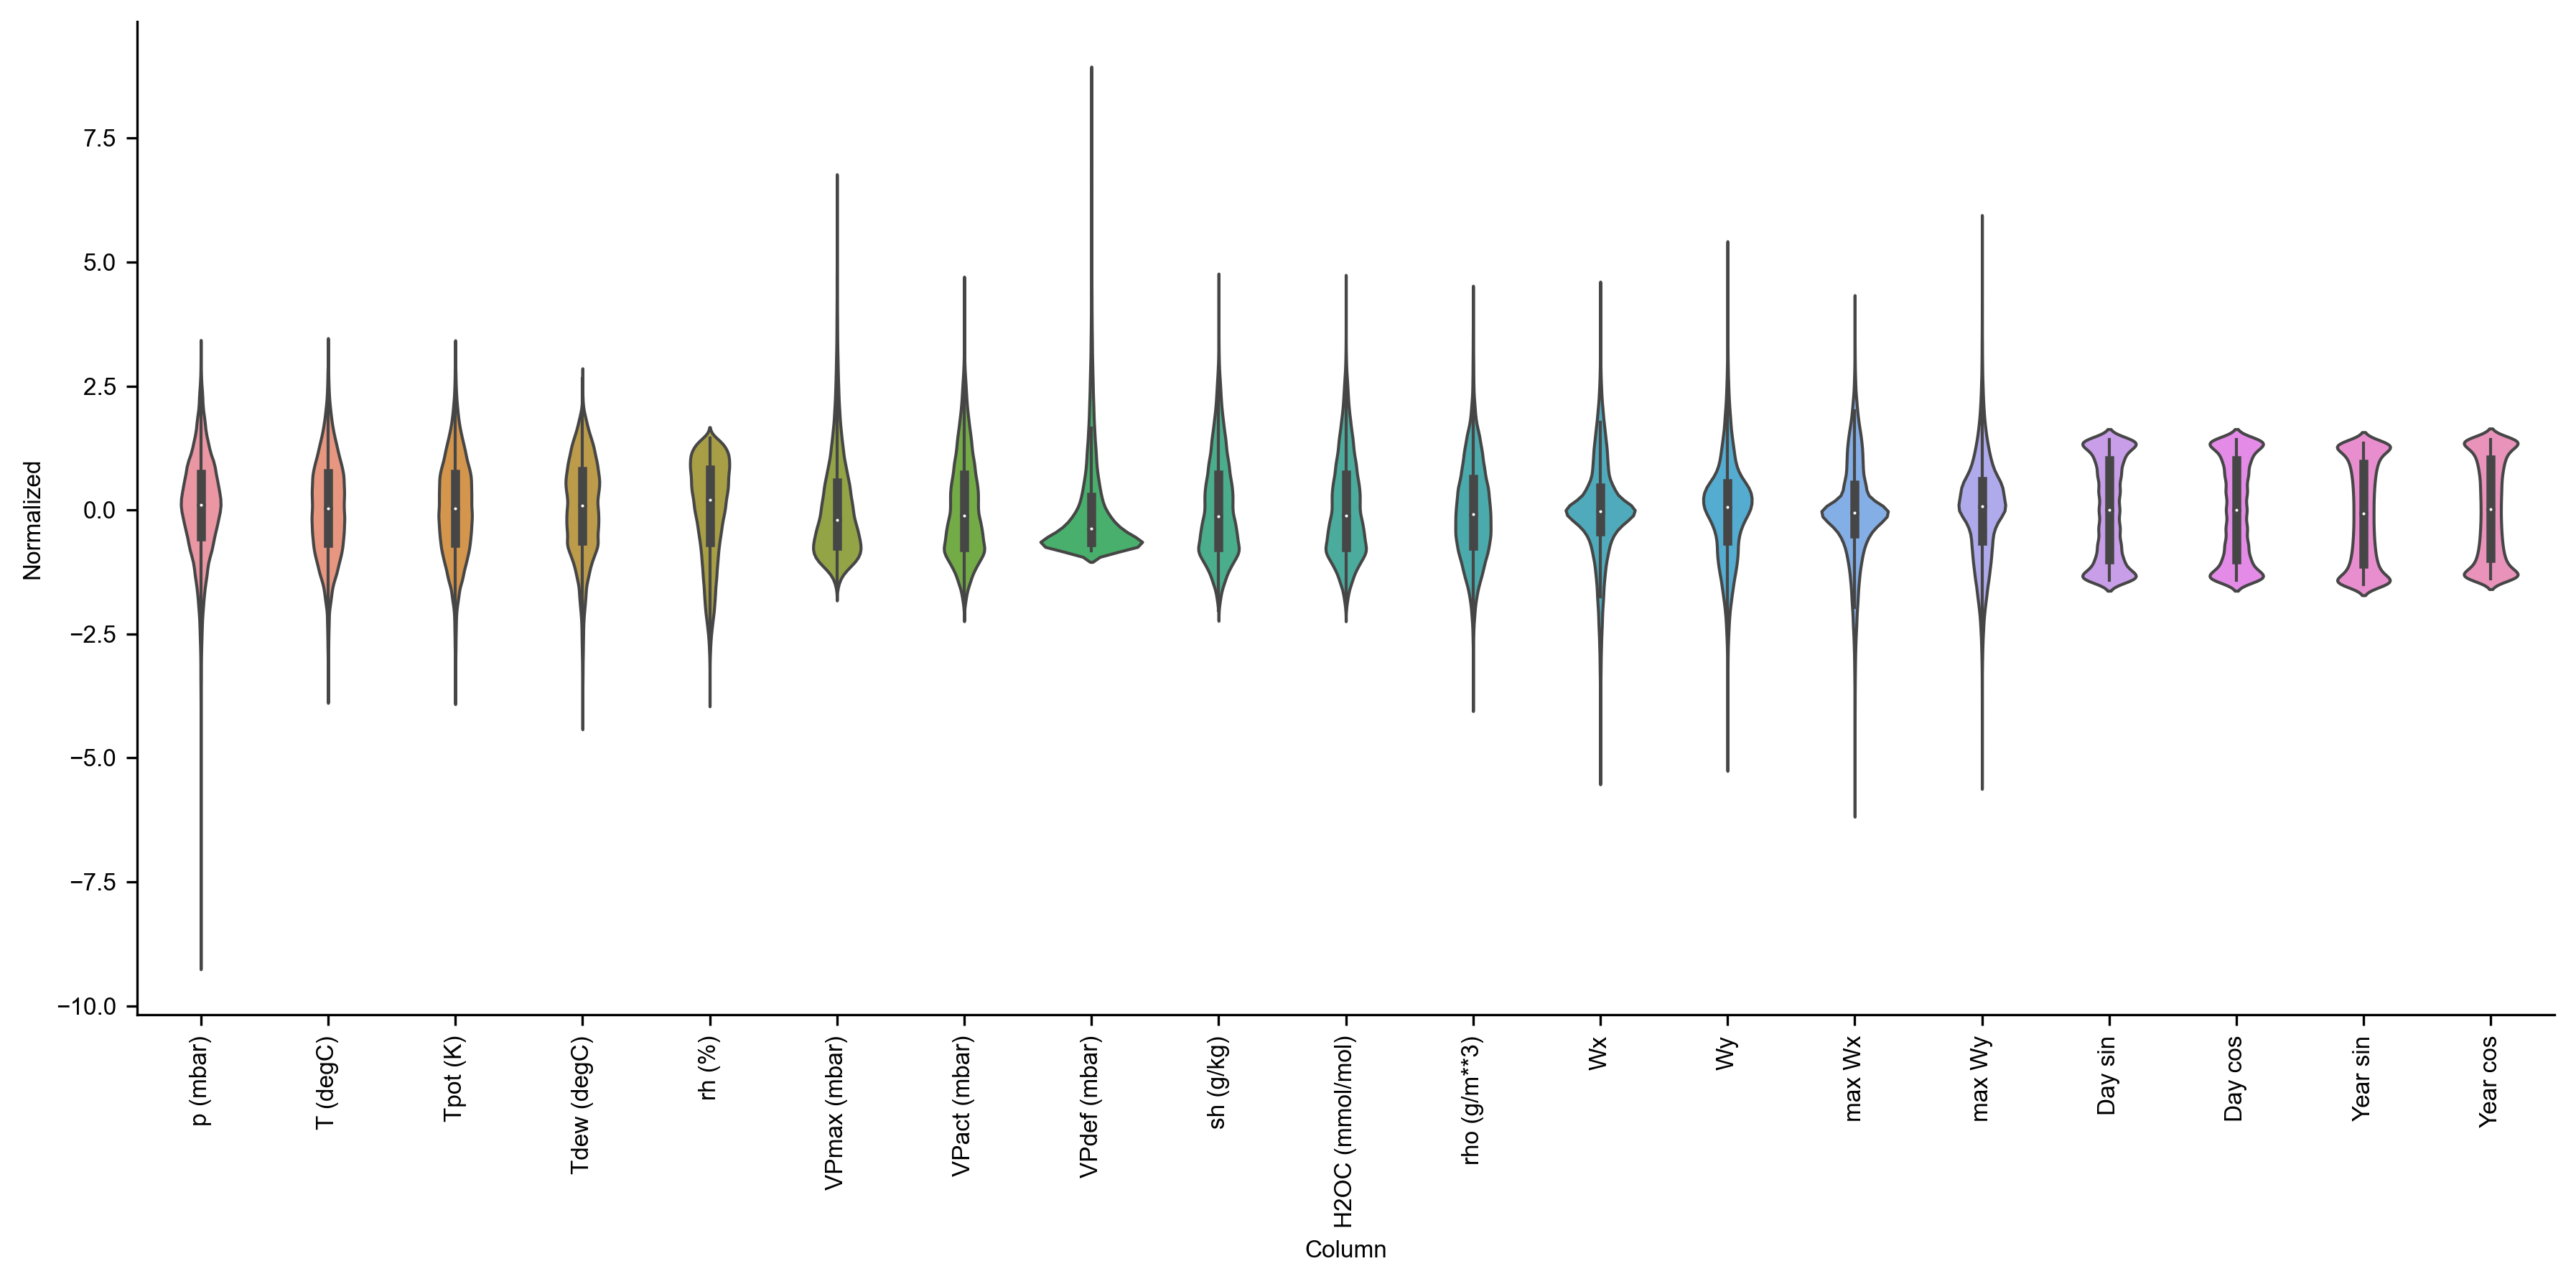

In [17]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## Data windowing

The models in this tutorial will make a set of predictions based on a window of consecutive samples from the data. 

The main features of the input windows are:

- The width (number of time steps) of the input and label windows.
- The time offset between them.
- Which features are used as inputs, labels, or both. 

This tutorial builds a variety of models (including Linear, DNN, CNN and RNN models), and uses them for both:

- *Single-output*, and *multi-output* predictions.
- *Single-time-step* and *multi-time-step* predictions.

This section focuses on implementing the data windowing so that it can be reused for all of those models.


Depending on the task and type of model you may want to generate a variety of data windows. Here are some examples:

1. For example, to make a single prediction 24 hours into the future, given 24 hours of history, you might define a window like this:

  ![One prediction 24 hours into the future.](images/raw_window_24h.png)

2. A model that makes a prediction one hour into the future, given six hours of history, would need a window like this:

  ![One prediction one hour into the future.](images/raw_window_1h.png)

The rest of this section defines a `WindowGenerator` class. This class can:

1. Handle the indexes and offsets as shown in the diagrams above.
1. Split windows of features into `(features, labels)` pairs.
2. Plot the content of the resulting windows.
3. Efficiently generate batches of these windows from the training, evaluation, and test data, using `tf.data.Dataset`s.

### 1. Indexes and offsets

Start by creating the `WindowGenerator` class. The `__init__` method includes all the necessary logic for the input and label indices.

It also takes the training, evaluation, and test DataFrames as input. These will be converted to `tf.data.Dataset`s of windows later.

In [18]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

Here is code to create the 2 windows shown in the diagrams at the start of this section:

In [19]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['T (degC)'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']

In [20]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['T (degC)'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']

### 2. Split

Given a list of consecutive inputs, the `split_window` method will convert them to a window of inputs and a window of labels.

The example `w2` you define earlier will be split like this:

![The initial window is all consecutive samples, this splits it into an (inputs, labels) pairs](images/split_window.png)

This diagram doesn't show the `features` axis of the data, but this `split_window` function also handles the `label_columns` so it can be used for both the single output and multi-output examples.

In [21]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

Try it out:

In [22]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 19)
Inputs shape: (3, 6, 19)
Labels shape: (3, 1, 1)


Typically, data in TensorFlow is packed into arrays where the outermost index is across examples (the "batch" dimension). The middle indices are the "time" or "space" (width, height) dimension(s). The innermost indices are the features.

The code above took a batch of three 7-time step windows with 19 features at each time step. It splits them into a batch of 6-time step 19-feature inputs, and a 1-time step 1-feature label. The label only has one feature because the `WindowGenerator` was initialized with `label_columns=['T (degC)']`. Initially, this tutorial will build models that predict single output labels.

### 3. Plot

Here is a plot method that allows a simple visualization of the split window:

In [23]:
w2.example = example_inputs, example_labels

In [24]:
def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

This plot aligns inputs, labels, and (later) predictions based on the time that the item refers to:

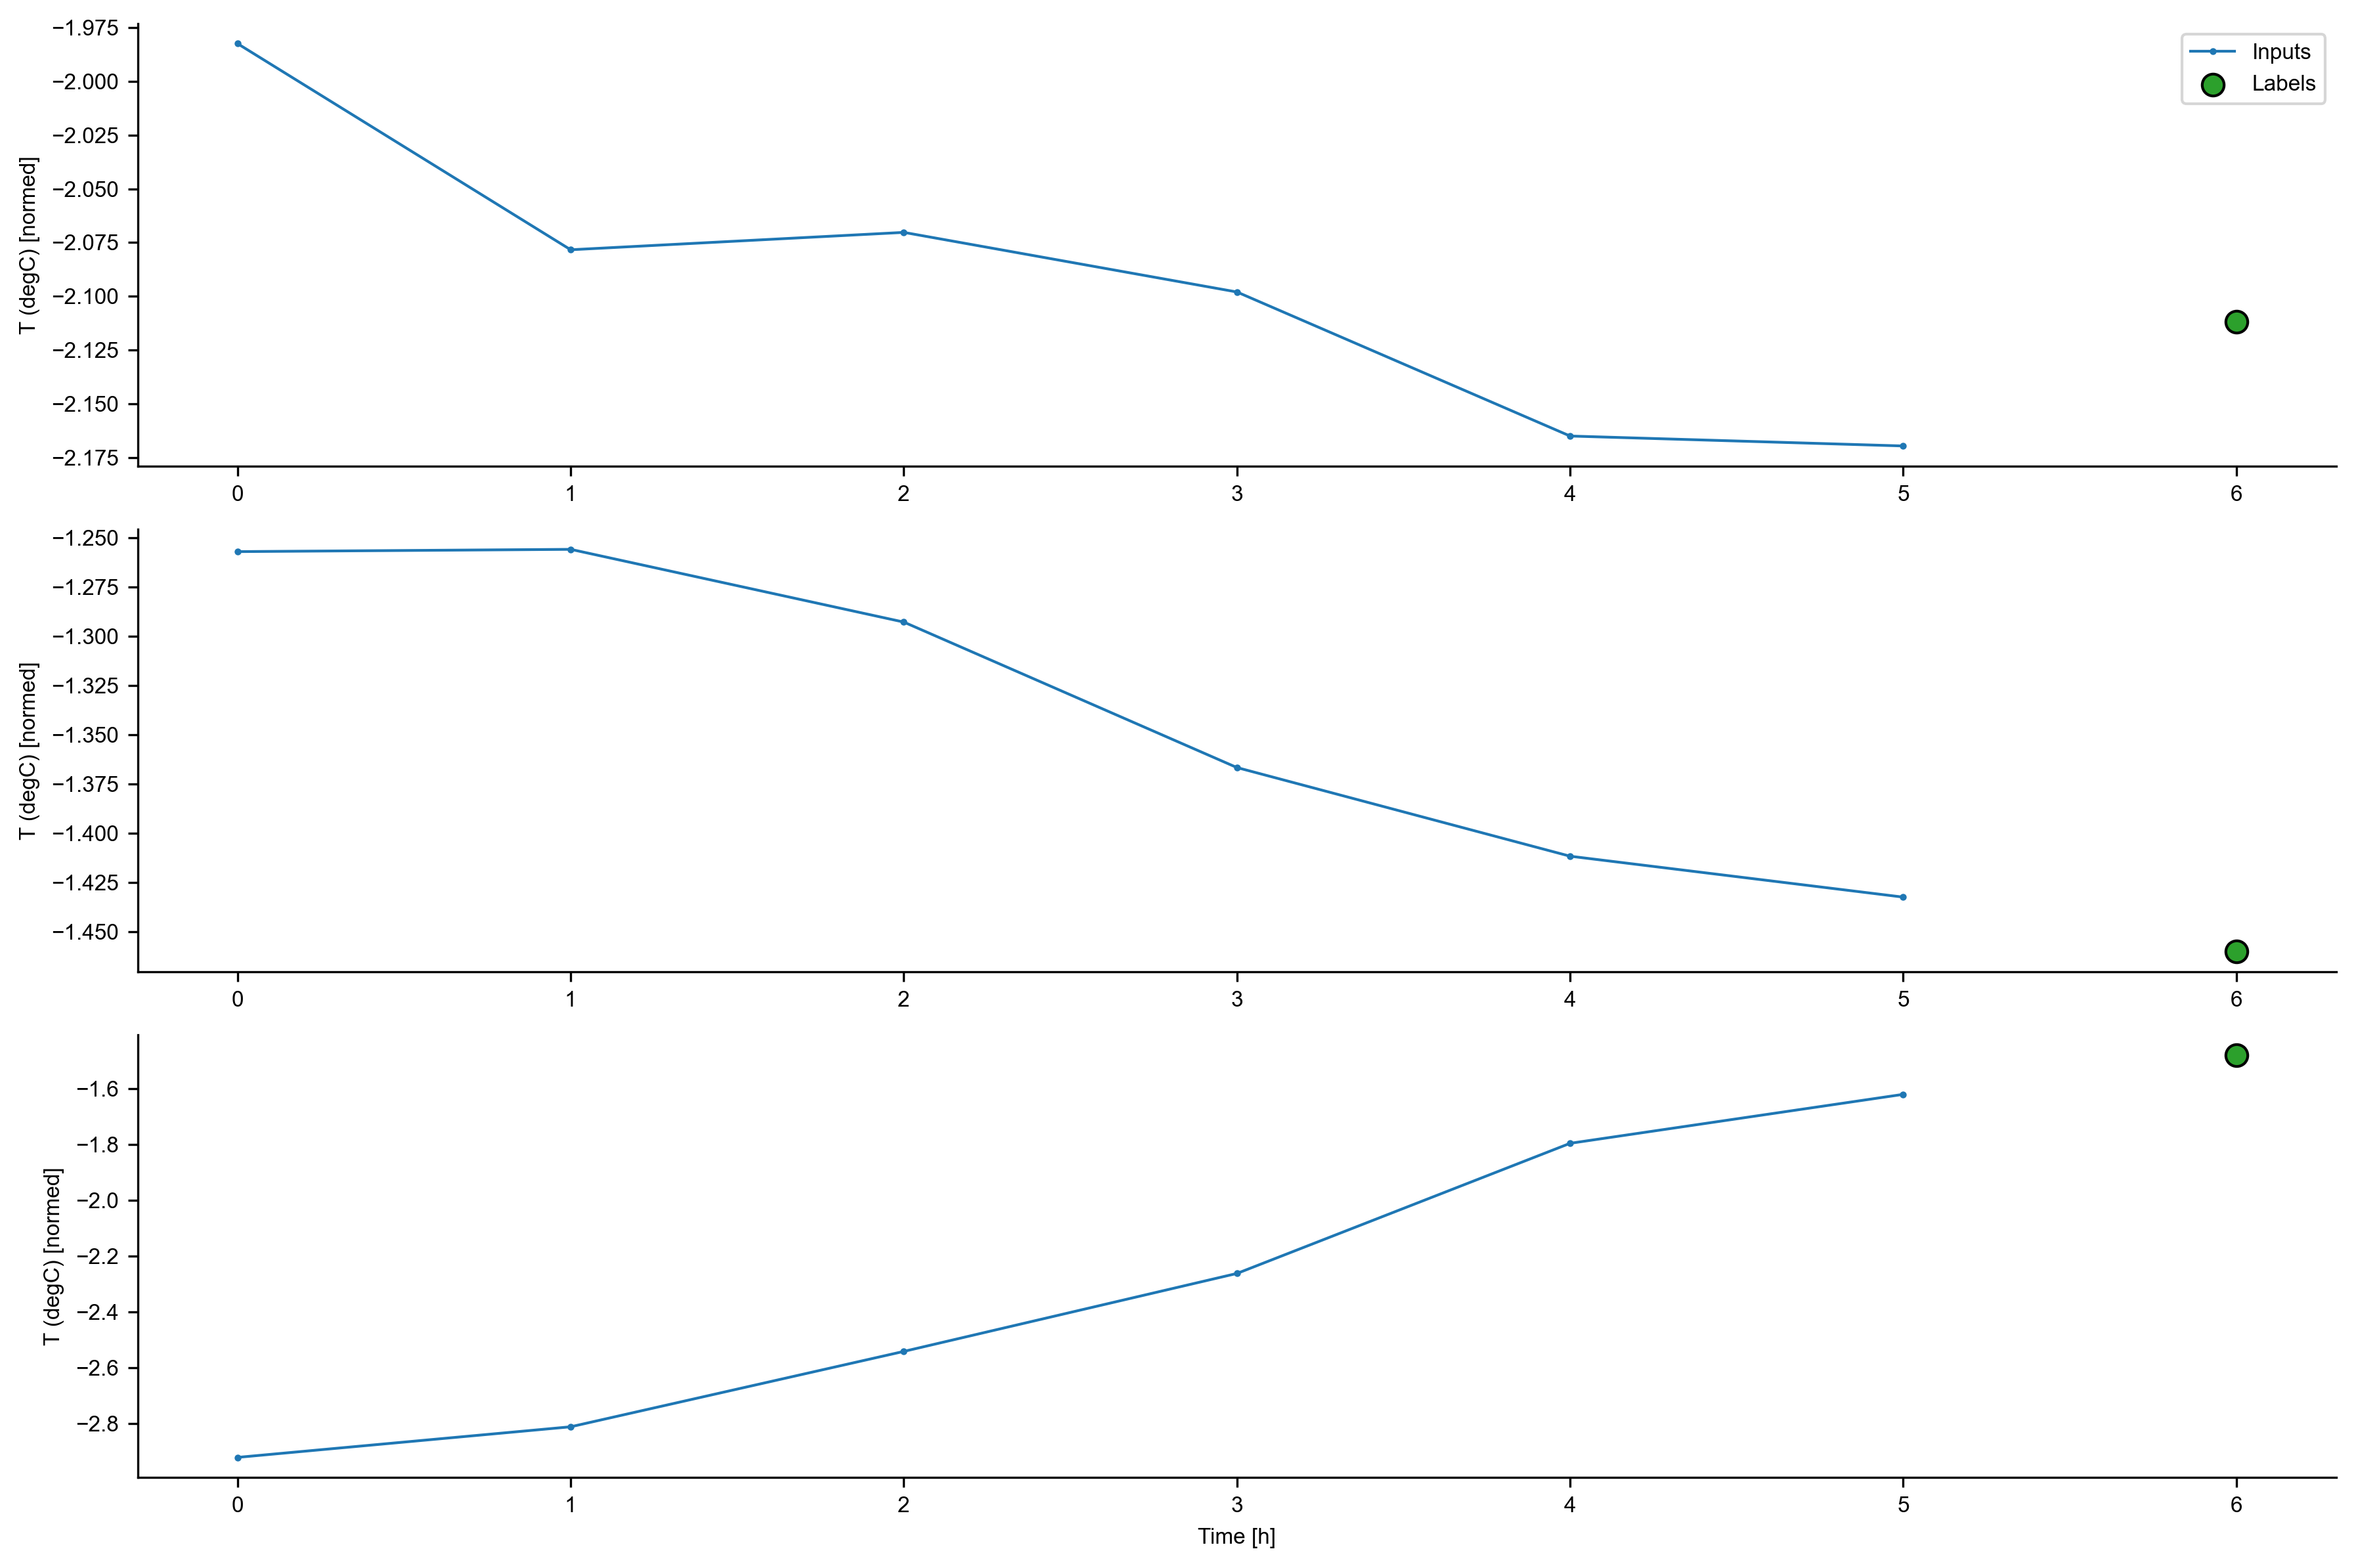

In [25]:
w2.plot()

You can plot the other columns, but the example window `w2` configuration only has labels for the `T (degC)` column.

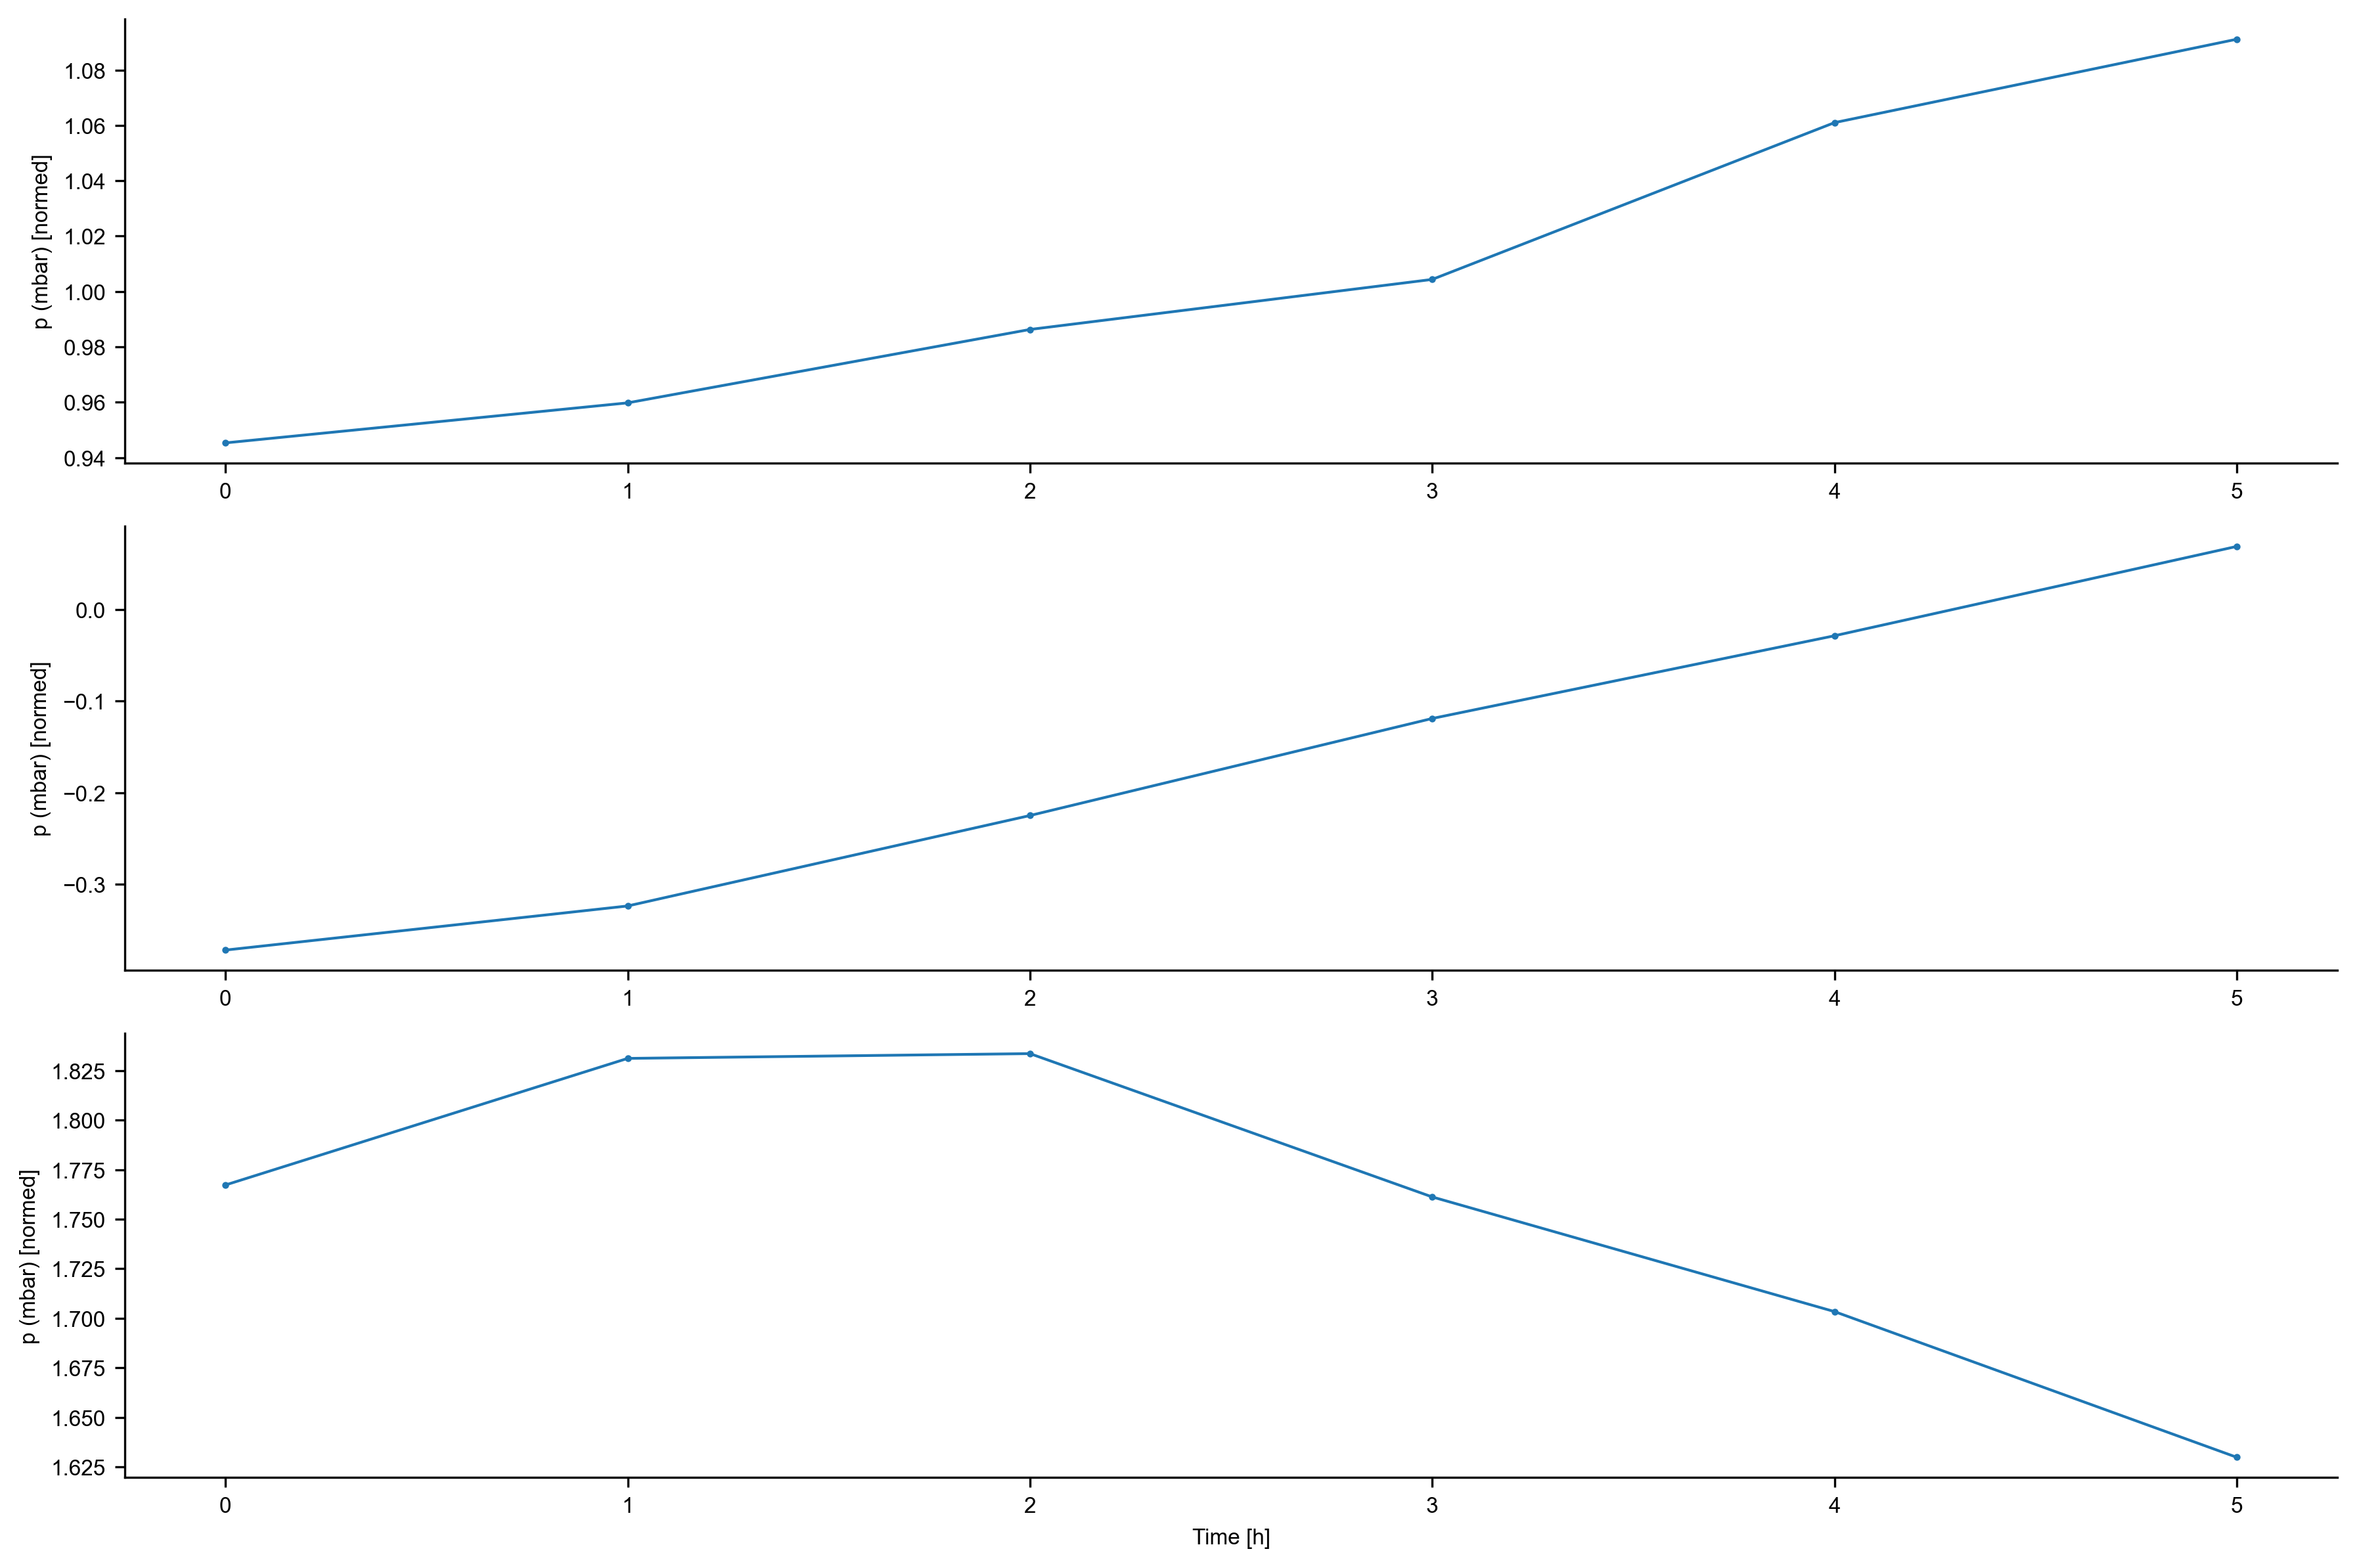

In [26]:
w2.plot(plot_col='p (mbar)')

### 4. Create `tf.data.Dataset`s

Finally, this `make_dataset` method will take a time series DataFrame and convert it to a `tf.data.Dataset` of `(input_window, label_window)` pairs using the `tf.keras.utils.timeseries_dataset_from_array` function:

In [27]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

The `WindowGenerator` object holds training, validation, and test data.

Add properties for accessing them as `tf.data.Dataset`s using the `make_dataset` method you defined earlier. Also, add a standard example batch for easy access and plotting:

In [28]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

Now, the `WindowGenerator` object gives you access to the `tf.data.Dataset` objects, so you can easily iterate over the data.

The `Dataset.element_spec` property tells you the structure, data types, and shapes of the dataset elements.

In [29]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 6, 19), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

Iterating over a `Dataset` yields concrete batches:

In [30]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 19)
Labels shape (batch, time, features): (32, 1, 1)


## Single step models

The simplest model you can build on this sort of data is one that predicts a single feature's value—1 time step (one hour) into the future based only on the current conditions.

So, start by building models to predict the `T (degC)` value one hour into the future.

![Predict the next time step](images/narrow_window.png)

Configure a `WindowGenerator` object to produce these single-step `(input, label)` pairs:

In [31]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['T (degC)'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']

The `window` object creates `tf.data.Dataset`s from the training, validation, and test sets, allowing you to easily iterate over batches of data.


In [32]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 19)
Labels shape (batch, time, features): (32, 1, 1)


### Baseline

Before building a trainable model it would be good to have a performance baseline as a point for comparison with the later more complicated models.

This first task is to predict temperature one hour into the future, given the current value of all features. The current values include the current temperature. 

So, start with a model that just returns the current temperature as the prediction, predicting "No change". This is a reasonable baseline since temperature changes slowly. Of course, this baseline will work less well if you make a prediction further in the future.

![Send the input to the output](images/baseline.png)

In [33]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

Instantiate and evaluate this model:

In [35]:
baseline = Baseline(label_index=column_indices['T (degC)'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

  1/439 [..............................] - ETA: 1:20 - loss: 0.0098 - mean_absolute_error: 0.0780

 27/439 [>.............................] - ETA: 0s - loss: 0.0147 - mean_absolute_error: 0.0832  

 54/439 [==>...........................] - ETA: 0s - loss: 0.0145 - mean_absolute_error: 0.0819

 85/439 [====>.........................] - ETA: 0s - loss: 0.0137 - mean_absolute_error: 0.0796

115/439 [======>.......................] - ETA: 0s - loss: 0.0134 - mean_absolute_error: 0.0786

144/439 [========>.....................] - ETA: 0s - loss: 0.0130 - mean_absolute_error: 0.0780

173/439 [==========>...................] - ETA: 0s - loss: 0.0132 - mean_absolute_error: 0.0787

202/439 [============>.................] - ETA: 0s - loss: 0.0130 - mean_absolute_error: 0.0785

230/439 [==============>...............] - ETA: 0s - loss: 0.0129 - mean_absolute_error: 0.0786

259/439 [================>.............] - ETA: 0s - loss: 0.0129 - mean_absolute_error: 0.0786

288/439 [==================>...........] - ETA: 0s - loss: 0.0129 - mean_absolute_error: 0.0785

317/439 [====================>.........] - ETA: 0s - loss: 0.0129 - mean_absolute_error: 0.0786

345/439 [======================>.......] - ETA: 0s - loss: 0.0128 - mean_absolute_error: 0.0783

374/439 [========================>.....] - ETA: 0s - loss: 0.0129 - mean_absolute_error: 0.0785

402/439 [==========================>...] - ETA: 0s - loss: 0.0129 - mean_absolute_error: 0.0784

433/439 [============================>.] - ETA: 0s - loss: 0.0128 - mean_absolute_error: 0.0784

439/439 [==============================] - 1s 2ms/step - loss: 0.0128 - mean_absolute_error: 0.0785


That printed some performance metrics, but those don't give you a feeling for how well the model is doing.

The `WindowGenerator` has a plot method, but the plots won't be very interesting with only a single sample.

So, create a wider `WindowGenerator` that generates windows 24 hours of consecutive inputs and labels at a time. The new `wide_window` variable doesn't change the way the model operates. The model still makes predictions one hour into the future based on a single input time step. Here, the `time` axis acts like the `batch` axis: each prediction is made independently with no interaction between time steps:

In [37]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['T (degC)'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']

This expanded window can be passed directly to the same `baseline` model without any code changes. This is possible because the inputs and labels have the same number of time steps, and the baseline just forwards the input to the output:

![One prediction 1h into the future, ever hour.](images/last_window.png)

In [38]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 19)


NameError: name 'baseline' is not defined

By plotting the baseline model's predictions, notice that it is simply the labels shifted right by one hour:

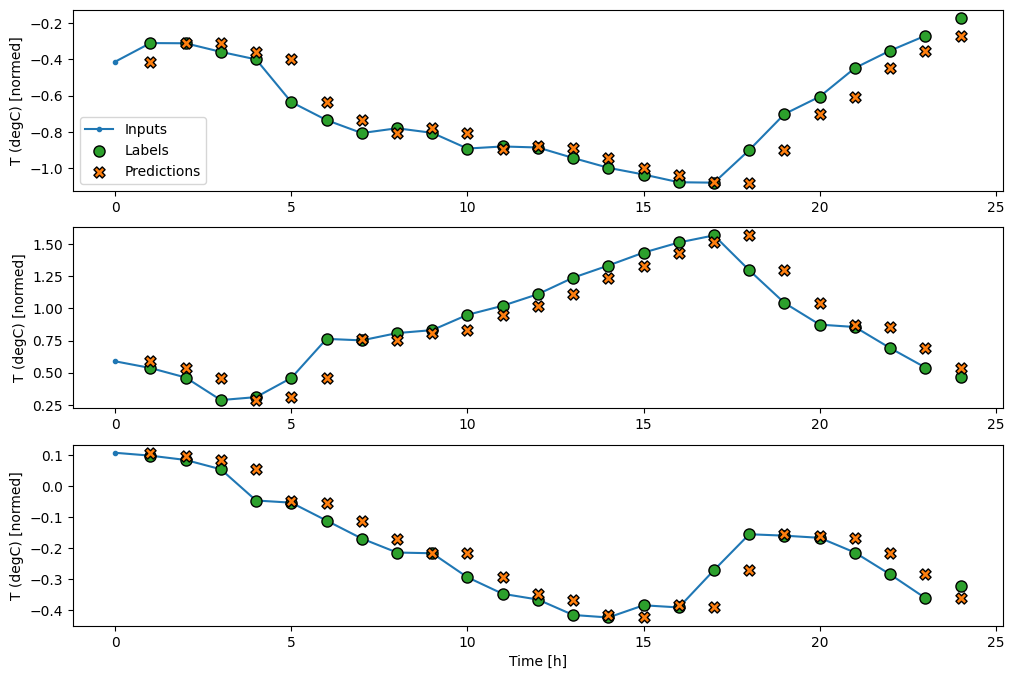

In [38]:
wide_window.plot(baseline)

In the above plots of three examples the single step model is run over the course of 24 hours. This deserves some explanation:

- The blue `Inputs` line shows the input temperature at each time step. The model receives all features, this plot only shows the temperature.
- The green `Labels` dots show the target prediction value. These dots are shown at the prediction time, not the input time. That is why the range of labels is shifted 1 step relative to the inputs.
- The orange `Predictions` crosses are the model's prediction's for each output time step. If the model were predicting perfectly the predictions would land directly on the `Labels`.

### Linear model

The simplest **trainable** model you can apply to this task is to insert linear transformation between the input and output. In this case the output from a time step only depends on that step:

![A single step prediction](images/narrow_window.png)

A `tf.keras.layers.Dense` layer with no `activation` set is a linear model. The layer only transforms the last axis of the data from `(batch, time, inputs)` to `(batch, time, units)`; it is applied independently to every item across the `batch` and `time` axes.

In [39]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [40]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 19)


Output shape: (32, 1, 1)


This tutorial trains many models, so package the training procedure into a function:

In [40]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

Train the model and evaluate its performance:

In [42]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20


   1/1534 [..............................] - ETA: 17:54 - loss: 1.7774 - mean_absolute_error: 1.1006

  21/1534 [..............................] - ETA: 3s - loss: 1.9827 - mean_absolute_error: 1.1461   

  41/1534 [..............................] - ETA: 3s - loss: 1.9007 - mean_absolute_error: 1.1033

  62/1534 [>.............................] - ETA: 3s - loss: 1.7355 - mean_absolute_error: 1.0540

  83/1534 [>.............................] - ETA: 3s - loss: 1.5773 - mean_absolute_error: 0.9989

 104/1534 [=>............................] - ETA: 3s - loss: 1.4402 - mean_absolute_error: 0.9512

 124/1534 [=>............................] - ETA: 3s - loss: 1.3448 - mean_absolute_error: 0.9163

 146/1534 [=>............................] - ETA: 3s - loss: 1.2485 - mean_absolute_error: 0.8803

 169/1534 [==>...........................] - ETA: 3s - loss: 1.1614 - mean_absolute_error: 0.8450

 190/1534 [==>...........................] - ETA: 3s - loss: 1.0962 - mean_absolute_error: 0.8188

 212/1534 [===>..........................] - ETA: 3s - loss: 1.0349 - mean_absolute_error: 0.7928

 233/1534 [===>..........................] - ETA: 3s - loss: 0.9842 - mean_absolute_error: 0.7703

 254/1534 [===>..........................] - ETA: 3s - loss: 0.9345 - mean_absolute_error: 0.7477

 275/1534 [====>.........................] - ETA: 3s - loss: 0.8920 - mean_absolute_error: 0.7284

 296/1534 [====>.........................] - ETA: 3s - loss: 0.8523 - mean_absolute_error: 0.7096

 318/1534 [=====>........................] - ETA: 2s - loss: 0.8139 - mean_absolute_error: 0.6909

 339/1534 [=====>........................] - ETA: 2s - loss: 0.7797 - mean_absolute_error: 0.6737

 361/1534 [======>.......................] - ETA: 2s - loss: 0.7468 - mean_absolute_error: 0.6564

 382/1534 [======>.......................] - ETA: 2s - loss: 0.7184 - mean_absolute_error: 0.6417

 404/1534 [======>.......................] - ETA: 2s - loss: 0.6891 - mean_absolute_error: 0.6253

 425/1534 [=======>......................] - ETA: 2s - loss: 0.6636 - mean_absolute_error: 0.6112

 446/1534 [=======>......................] - ETA: 2s - loss: 0.6392 - mean_absolute_error: 0.5968

 467/1534 [========>.....................] - ETA: 2s - loss: 0.6170 - mean_absolute_error: 0.5838

 488/1534 [========>.....................] - ETA: 2s - loss: 0.5957 - mean_absolute_error: 0.5707

 509/1534 [========>.....................] - ETA: 2s - loss: 0.5758 - mean_absolute_error: 0.5582

 531/1534 [=========>....................] - ETA: 2s - loss: 0.5559 - mean_absolute_error: 0.5453

 552/1534 [=========>....................] - ETA: 2s - loss: 0.5380 - mean_absolute_error: 0.5333

 573/1534 [==========>...................] - ETA: 2s - loss: 0.5213 - mean_absolute_error: 0.5222

 595/1534 [==========>...................] - ETA: 2s - loss: 0.5047 - mean_absolute_error: 0.5109

 617/1534 [===========>..................] - ETA: 2s - loss: 0.4892 - mean_absolute_error: 0.5000

 638/1534 [===========>..................] - ETA: 2s - loss: 0.4749 - mean_absolute_error: 0.4897

 659/1534 [===========>..................] - ETA: 2s - loss: 0.4616 - mean_absolute_error: 0.4802

 680/1534 [============>.................] - ETA: 2s - loss: 0.4488 - mean_absolute_error: 0.4706

 701/1534 [============>.................] - ETA: 2s - loss: 0.4369 - mean_absolute_error: 0.4619

 722/1534 [=============>................] - ETA: 1s - loss: 0.4255 - mean_absolute_error: 0.4534

 743/1534 [=============>................] - ETA: 1s - loss: 0.4147 - mean_absolute_error: 0.4452

 764/1534 [=============>................] - ETA: 1s - loss: 0.4043 - mean_absolute_error: 0.4371

 785/1534 [==============>...............] - ETA: 1s - loss: 0.3945 - mean_absolute_error: 0.4295

 806/1534 [==============>...............] - ETA: 1s - loss: 0.3853 - mean_absolute_error: 0.4223

 827/1534 [===============>..............] - ETA: 1s - loss: 0.3763 - mean_absolute_error: 0.4150

 849/1534 [===============>..............] - ETA: 1s - loss: 0.3673 - mean_absolute_error: 0.4077

 871/1534 [================>.............] - ETA: 1s - loss: 0.3589 - mean_absolute_error: 0.4007

 892/1534 [================>.............] - ETA: 1s - loss: 0.3510 - mean_absolute_error: 0.3942

 913/1534 [================>.............] - ETA: 1s - loss: 0.3434 - mean_absolute_error: 0.3878

 934/1534 [=================>............] - ETA: 1s - loss: 0.3362 - mean_absolute_error: 0.3817

 955/1534 [=================>............] - ETA: 1s - loss: 0.3293 - mean_absolute_error: 0.3757

 977/1534 [==================>...........] - ETA: 1s - loss: 0.3225 - mean_absolute_error: 0.3701

 998/1534 [==================>...........] - ETA: 1s - loss: 0.3161 - mean_absolute_error: 0.3646

1019/1534 [==================>...........] - ETA: 1s - loss: 0.3101 - mean_absolute_error: 0.3595

1041/1534 [===================>..........] - ETA: 1s - loss: 0.3039 - mean_absolute_error: 0.3542

1062/1534 [===================>..........] - ETA: 1s - loss: 0.2983 - mean_absolute_error: 0.3493

1083/1534 [====================>.........] - ETA: 1s - loss: 0.2929 - mean_absolute_error: 0.3447

1104/1534 [====================>.........] - ETA: 1s - loss: 0.2877 - mean_absolute_error: 0.3401

1125/1534 [=====================>........] - ETA: 0s - loss: 0.2827 - mean_absolute_error: 0.3357

1147/1534 [=====================>........] - ETA: 0s - loss: 0.2776 - mean_absolute_error: 0.3312

1169/1534 [=====================>........] - ETA: 0s - loss: 0.2727 - mean_absolute_error: 0.3268

1190/1534 [======================>.......] - ETA: 0s - loss: 0.2682 - mean_absolute_error: 0.3228

1211/1534 [======================>.......] - ETA: 0s - loss: 0.2638 - mean_absolute_error: 0.3188

1232/1534 [=======================>......] - ETA: 0s - loss: 0.2596 - mean_absolute_error: 0.3152

1254/1534 [=======================>......] - ETA: 0s - loss: 0.2553 - mean_absolute_error: 0.3112

1276/1534 [=======================>......] - ETA: 0s - loss: 0.2513 - mean_absolute_error: 0.3076

1297/1534 [========================>.....] - ETA: 0s - loss: 0.2474 - mean_absolute_error: 0.3042

1318/1534 [========================>.....] - ETA: 0s - loss: 0.2437 - mean_absolute_error: 0.3007

1339/1534 [=========================>....] - ETA: 0s - loss: 0.2401 - mean_absolute_error: 0.2974

1360/1534 [=========================>....] - ETA: 0s - loss: 0.2366 - mean_absolute_error: 0.2942

1382/1534 [==========================>...] - ETA: 0s - loss: 0.2331 - mean_absolute_error: 0.2910

1403/1534 [==========================>...] - ETA: 0s - loss: 0.2298 - mean_absolute_error: 0.2880

1424/1534 [==========================>...] - ETA: 0s - loss: 0.2267 - mean_absolute_error: 0.2850

1446/1534 [===========================>..] - ETA: 0s - loss: 0.2234 - mean_absolute_error: 0.2820

1467/1534 [===========================>..] - ETA: 0s - loss: 0.2204 - mean_absolute_error: 0.2793

1488/1534 [============================>.] - ETA: 0s - loss: 0.2175 - mean_absolute_error: 0.2765

1508/1534 [============================>.] - ETA: 0s - loss: 0.2148 - mean_absolute_error: 0.2739

1529/1534 [============================>.] - ETA: 0s - loss: 0.2120 - mean_absolute_error: 0.2714

1534/1534 [==============================] - 5s 3ms/step - loss: 0.2115 - mean_absolute_error: 0.2709 - val_loss: 0.0135 - val_mean_absolute_error: 0.0861


Epoch 2/20


   1/1534 [..............................] - ETA: 41s - loss: 0.0072 - mean_absolute_error: 0.0635

  21/1534 [..............................] - ETA: 3s - loss: 0.0129 - mean_absolute_error: 0.0856 

  42/1534 [..............................] - ETA: 3s - loss: 0.0122 - mean_absolute_error: 0.0835

  64/1534 [>.............................] - ETA: 3s - loss: 0.0128 - mean_absolute_error: 0.0846

  86/1534 [>.............................] - ETA: 3s - loss: 0.0129 - mean_absolute_error: 0.0846

 108/1534 [=>............................] - ETA: 3s - loss: 0.0127 - mean_absolute_error: 0.0833

 130/1534 [=>............................] - ETA: 3s - loss: 0.0124 - mean_absolute_error: 0.0822

 152/1534 [=>............................] - ETA: 3s - loss: 0.0125 - mean_absolute_error: 0.0826

 174/1534 [==>...........................] - ETA: 3s - loss: 0.0126 - mean_absolute_error: 0.0830

 196/1534 [==>...........................] - ETA: 3s - loss: 0.0128 - mean_absolute_error: 0.0834

 218/1534 [===>..........................] - ETA: 3s - loss: 0.0127 - mean_absolute_error: 0.0836

 239/1534 [===>..........................] - ETA: 3s - loss: 0.0127 - mean_absolute_error: 0.0838

 260/1534 [====>.........................] - ETA: 3s - loss: 0.0126 - mean_absolute_error: 0.0835

 282/1534 [====>.........................] - ETA: 2s - loss: 0.0125 - mean_absolute_error: 0.0833

 304/1534 [====>.........................] - ETA: 2s - loss: 0.0124 - mean_absolute_error: 0.0831

 325/1534 [=====>........................] - ETA: 2s - loss: 0.0123 - mean_absolute_error: 0.0829

 346/1534 [=====>........................] - ETA: 2s - loss: 0.0122 - mean_absolute_error: 0.0826

 368/1534 [======>.......................] - ETA: 2s - loss: 0.0121 - mean_absolute_error: 0.0826

 390/1534 [======>.......................] - ETA: 2s - loss: 0.0122 - mean_absolute_error: 0.0827

 412/1534 [=======>......................] - ETA: 2s - loss: 0.0121 - mean_absolute_error: 0.0825

 433/1534 [=======>......................] - ETA: 2s - loss: 0.0122 - mean_absolute_error: 0.0826

 455/1534 [=======>......................] - ETA: 2s - loss: 0.0122 - mean_absolute_error: 0.0826

 476/1534 [========>.....................] - ETA: 2s - loss: 0.0121 - mean_absolute_error: 0.0825

 498/1534 [========>.....................] - ETA: 2s - loss: 0.0121 - mean_absolute_error: 0.0823

 520/1534 [=========>....................] - ETA: 2s - loss: 0.0120 - mean_absolute_error: 0.0821

 542/1534 [=========>....................] - ETA: 2s - loss: 0.0120 - mean_absolute_error: 0.0819

 564/1534 [==========>...................] - ETA: 2s - loss: 0.0119 - mean_absolute_error: 0.0820

 585/1534 [==========>...................] - ETA: 2s - loss: 0.0119 - mean_absolute_error: 0.0817

 606/1534 [==========>...................] - ETA: 2s - loss: 0.0118 - mean_absolute_error: 0.0813

 627/1534 [===========>..................] - ETA: 2s - loss: 0.0118 - mean_absolute_error: 0.0811

 648/1534 [===========>..................] - ETA: 2s - loss: 0.0117 - mean_absolute_error: 0.0810

 670/1534 [============>.................] - ETA: 2s - loss: 0.0117 - mean_absolute_error: 0.0809

 692/1534 [============>.................] - ETA: 2s - loss: 0.0116 - mean_absolute_error: 0.0808

 713/1534 [============>.................] - ETA: 1s - loss: 0.0116 - mean_absolute_error: 0.0807

 734/1534 [=============>................] - ETA: 1s - loss: 0.0116 - mean_absolute_error: 0.0805

 756/1534 [=============>................] - ETA: 1s - loss: 0.0116 - mean_absolute_error: 0.0806

 777/1534 [==============>...............] - ETA: 1s - loss: 0.0116 - mean_absolute_error: 0.0806

 798/1534 [==============>...............] - ETA: 1s - loss: 0.0117 - mean_absolute_error: 0.0806

 819/1534 [===============>..............] - ETA: 1s - loss: 0.0117 - mean_absolute_error: 0.0806

 840/1534 [===============>..............] - ETA: 1s - loss: 0.0116 - mean_absolute_error: 0.0804

 861/1534 [===============>..............] - ETA: 1s - loss: 0.0117 - mean_absolute_error: 0.0804

 882/1534 [================>.............] - ETA: 1s - loss: 0.0116 - mean_absolute_error: 0.0803

 904/1534 [================>.............] - ETA: 1s - loss: 0.0116 - mean_absolute_error: 0.0801

 926/1534 [=================>............] - ETA: 1s - loss: 0.0115 - mean_absolute_error: 0.0799

 948/1534 [=================>............] - ETA: 1s - loss: 0.0115 - mean_absolute_error: 0.0797

 970/1534 [=================>............] - ETA: 1s - loss: 0.0114 - mean_absolute_error: 0.0797

 992/1534 [==================>...........] - ETA: 1s - loss: 0.0114 - mean_absolute_error: 0.0795

1014/1534 [==================>...........] - ETA: 1s - loss: 0.0114 - mean_absolute_error: 0.0794

1036/1534 [===================>..........] - ETA: 1s - loss: 0.0113 - mean_absolute_error: 0.0793

1058/1534 [===================>..........] - ETA: 1s - loss: 0.0113 - mean_absolute_error: 0.0792

1080/1534 [====================>.........] - ETA: 1s - loss: 0.0113 - mean_absolute_error: 0.0792

1102/1534 [====================>.........] - ETA: 1s - loss: 0.0113 - mean_absolute_error: 0.0791

1124/1534 [====================>.........] - ETA: 0s - loss: 0.0112 - mean_absolute_error: 0.0790

1145/1534 [=====================>........] - ETA: 0s - loss: 0.0112 - mean_absolute_error: 0.0789

1167/1534 [=====================>........] - ETA: 0s - loss: 0.0112 - mean_absolute_error: 0.0788

1189/1534 [======================>.......] - ETA: 0s - loss: 0.0112 - mean_absolute_error: 0.0788

1210/1534 [======================>.......] - ETA: 0s - loss: 0.0112 - mean_absolute_error: 0.0787

1231/1534 [=======================>......] - ETA: 0s - loss: 0.0112 - mean_absolute_error: 0.0787

1252/1534 [=======================>......] - ETA: 0s - loss: 0.0112 - mean_absolute_error: 0.0787

1273/1534 [=======================>......] - ETA: 0s - loss: 0.0111 - mean_absolute_error: 0.0786

1294/1534 [========================>.....] - ETA: 0s - loss: 0.0111 - mean_absolute_error: 0.0785

1315/1534 [========================>.....] - ETA: 0s - loss: 0.0111 - mean_absolute_error: 0.0785

1336/1534 [=========================>....] - ETA: 0s - loss: 0.0111 - mean_absolute_error: 0.0784

1357/1534 [=========================>....] - ETA: 0s - loss: 0.0111 - mean_absolute_error: 0.0784

1378/1534 [=========================>....] - ETA: 0s - loss: 0.0111 - mean_absolute_error: 0.0783

1399/1534 [==========================>...] - ETA: 0s - loss: 0.0111 - mean_absolute_error: 0.0782

1421/1534 [==========================>...] - ETA: 0s - loss: 0.0110 - mean_absolute_error: 0.0782

1442/1534 [===========================>..] - ETA: 0s - loss: 0.0110 - mean_absolute_error: 0.0781

1464/1534 [===========================>..] - ETA: 0s - loss: 0.0110 - mean_absolute_error: 0.0781

1486/1534 [============================>.] - ETA: 0s - loss: 0.0110 - mean_absolute_error: 0.0780

1507/1534 [============================>.] - ETA: 0s - loss: 0.0110 - mean_absolute_error: 0.0779

1529/1534 [============================>.] - ETA: 0s - loss: 0.0109 - mean_absolute_error: 0.0778

1534/1534 [==============================] - 4s 3ms/step - loss: 0.0109 - mean_absolute_error: 0.0779 - val_loss: 0.0097 - val_mean_absolute_error: 0.0731


Epoch 3/20


   1/1534 [..............................] - ETA: 40s - loss: 0.0080 - mean_absolute_error: 0.0681

  21/1534 [..............................] - ETA: 3s - loss: 0.0100 - mean_absolute_error: 0.0750 

  42/1534 [..............................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0716

  63/1534 [>.............................] - ETA: 3s - loss: 0.0097 - mean_absolute_error: 0.0733

  84/1534 [>.............................] - ETA: 3s - loss: 0.0098 - mean_absolute_error: 0.0733

 105/1534 [=>............................] - ETA: 3s - loss: 0.0097 - mean_absolute_error: 0.0727

 127/1534 [=>............................] - ETA: 3s - loss: 0.0097 - mean_absolute_error: 0.0722

 150/1534 [=>............................] - ETA: 3s - loss: 0.0097 - mean_absolute_error: 0.0723

 171/1534 [==>...........................] - ETA: 3s - loss: 0.0100 - mean_absolute_error: 0.0730

 193/1534 [==>...........................] - ETA: 3s - loss: 0.0099 - mean_absolute_error: 0.0727

 215/1534 [===>..........................] - ETA: 3s - loss: 0.0101 - mean_absolute_error: 0.0736

 237/1534 [===>..........................] - ETA: 3s - loss: 0.0100 - mean_absolute_error: 0.0738

 259/1534 [====>.........................] - ETA: 3s - loss: 0.0100 - mean_absolute_error: 0.0738

 281/1534 [====>.........................] - ETA: 2s - loss: 0.0099 - mean_absolute_error: 0.0735

 302/1534 [====>.........................] - ETA: 2s - loss: 0.0098 - mean_absolute_error: 0.0733

 323/1534 [=====>........................] - ETA: 2s - loss: 0.0098 - mean_absolute_error: 0.0734

 345/1534 [=====>........................] - ETA: 2s - loss: 0.0097 - mean_absolute_error: 0.0731

 367/1534 [======>.......................] - ETA: 2s - loss: 0.0097 - mean_absolute_error: 0.0733

 389/1534 [======>.......................] - ETA: 2s - loss: 0.0098 - mean_absolute_error: 0.0736

 410/1534 [=======>......................] - ETA: 2s - loss: 0.0098 - mean_absolute_error: 0.0736

 432/1534 [=======>......................] - ETA: 2s - loss: 0.0099 - mean_absolute_error: 0.0737

 454/1534 [=======>......................] - ETA: 2s - loss: 0.0099 - mean_absolute_error: 0.0737

 475/1534 [========>.....................] - ETA: 2s - loss: 0.0098 - mean_absolute_error: 0.0737

 497/1534 [========>.....................] - ETA: 2s - loss: 0.0099 - mean_absolute_error: 0.0738

 518/1534 [=========>....................] - ETA: 2s - loss: 0.0098 - mean_absolute_error: 0.0737

 539/1534 [=========>....................] - ETA: 2s - loss: 0.0098 - mean_absolute_error: 0.0737

 561/1534 [=========>....................] - ETA: 2s - loss: 0.0098 - mean_absolute_error: 0.0737

 583/1534 [==========>...................] - ETA: 2s - loss: 0.0098 - mean_absolute_error: 0.0737

 604/1534 [==========>...................] - ETA: 2s - loss: 0.0098 - mean_absolute_error: 0.0734

 625/1534 [===========>..................] - ETA: 2s - loss: 0.0098 - mean_absolute_error: 0.0733

 647/1534 [===========>..................] - ETA: 2s - loss: 0.0098 - mean_absolute_error: 0.0732

 668/1534 [============>.................] - ETA: 2s - loss: 0.0097 - mean_absolute_error: 0.0732

 689/1534 [============>.................] - ETA: 2s - loss: 0.0097 - mean_absolute_error: 0.0732

 711/1534 [============>.................] - ETA: 1s - loss: 0.0097 - mean_absolute_error: 0.0731

 733/1534 [=============>................] - ETA: 1s - loss: 0.0097 - mean_absolute_error: 0.0731

 754/1534 [=============>................] - ETA: 1s - loss: 0.0097 - mean_absolute_error: 0.0731

 775/1534 [==============>...............] - ETA: 1s - loss: 0.0098 - mean_absolute_error: 0.0732

 797/1534 [==============>...............] - ETA: 1s - loss: 0.0099 - mean_absolute_error: 0.0734

 818/1534 [==============>...............] - ETA: 1s - loss: 0.0099 - mean_absolute_error: 0.0734

 839/1534 [===============>..............] - ETA: 1s - loss: 0.0098 - mean_absolute_error: 0.0732

 860/1534 [===============>..............] - ETA: 1s - loss: 0.0098 - mean_absolute_error: 0.0732

 881/1534 [================>.............] - ETA: 1s - loss: 0.0099 - mean_absolute_error: 0.0733

 903/1534 [================>.............] - ETA: 1s - loss: 0.0098 - mean_absolute_error: 0.0732

 924/1534 [=================>............] - ETA: 1s - loss: 0.0098 - mean_absolute_error: 0.0731

 945/1534 [=================>............] - ETA: 1s - loss: 0.0098 - mean_absolute_error: 0.0730

 966/1534 [=================>............] - ETA: 1s - loss: 0.0098 - mean_absolute_error: 0.0730

 987/1534 [==================>...........] - ETA: 1s - loss: 0.0098 - mean_absolute_error: 0.0730

1008/1534 [==================>...........] - ETA: 1s - loss: 0.0097 - mean_absolute_error: 0.0729

1028/1534 [===================>..........] - ETA: 1s - loss: 0.0097 - mean_absolute_error: 0.0729

1048/1534 [===================>..........] - ETA: 1s - loss: 0.0097 - mean_absolute_error: 0.0728

1069/1534 [===================>..........] - ETA: 1s - loss: 0.0097 - mean_absolute_error: 0.0728

1090/1534 [====================>.........] - ETA: 1s - loss: 0.0097 - mean_absolute_error: 0.0729

1110/1534 [====================>.........] - ETA: 1s - loss: 0.0097 - mean_absolute_error: 0.0728

1131/1534 [=====================>........] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0728

1152/1534 [=====================>........] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0728

1173/1534 [=====================>........] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0728

1194/1534 [======================>.......] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0728

1215/1534 [======================>.......] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0727

1236/1534 [=======================>......] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0727

1257/1534 [=======================>......] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0727

1278/1534 [=======================>......] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0728

1299/1534 [========================>.....] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0727

1320/1534 [========================>.....] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0727

1342/1534 [=========================>....] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0728

1364/1534 [=========================>....] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0727

1386/1534 [==========================>...] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0727

1408/1534 [==========================>...] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0727

1429/1534 [==========================>...] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0726

1450/1534 [===========================>..] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0727

1471/1534 [===========================>..] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0726

1492/1534 [============================>.] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0726

1513/1534 [============================>.] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0725

1534/1534 [==============================] - 4s 3ms/step - loss: 0.0097 - mean_absolute_error: 0.0726 - val_loss: 0.0091 - val_mean_absolute_error: 0.0703


Epoch 4/20


   1/1534 [..............................] - ETA: 37s - loss: 0.0111 - mean_absolute_error: 0.0798

  21/1534 [..............................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0716 

  42/1534 [..............................] - ETA: 3s - loss: 0.0085 - mean_absolute_error: 0.0695

  63/1534 [>.............................] - ETA: 3s - loss: 0.0088 - mean_absolute_error: 0.0705

  85/1534 [>.............................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0708

 106/1534 [=>............................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0697

 128/1534 [=>............................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0703

 150/1534 [=>............................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0704

 171/1534 [==>...........................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0708

 193/1534 [==>...........................] - ETA: 3s - loss: 0.0095 - mean_absolute_error: 0.0710

 214/1534 [===>..........................] - ETA: 3s - loss: 0.0096 - mean_absolute_error: 0.0716

 235/1534 [===>..........................] - ETA: 3s - loss: 0.0096 - mean_absolute_error: 0.0716

 256/1534 [====>.........................] - ETA: 3s - loss: 0.0095 - mean_absolute_error: 0.0716

 277/1534 [====>.........................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0713

 299/1534 [====>.........................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0711

 320/1534 [=====>........................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0711

 342/1534 [=====>........................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0712

 363/1534 [======>.......................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0713

 384/1534 [======>.......................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0714

 405/1534 [======>.......................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0715

 426/1534 [=======>......................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0716

 447/1534 [=======>......................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0717

 468/1534 [========>.....................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0718

 489/1534 [========>.....................] - ETA: 2s - loss: 0.0095 - mean_absolute_error: 0.0719

 511/1534 [========>.....................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0717

 532/1534 [=========>....................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0718

 554/1534 [=========>....................] - ETA: 2s - loss: 0.0095 - mean_absolute_error: 0.0718

 576/1534 [==========>...................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0717

 597/1534 [==========>...................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0716

 618/1534 [===========>..................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0714

 640/1534 [===========>..................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0713

 662/1534 [===========>..................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0713

 684/1534 [============>.................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0713

 706/1534 [============>.................] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0712

 727/1534 [=============>................] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0713

 749/1534 [=============>................] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0713

 770/1534 [==============>...............] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0714

 791/1534 [==============>...............] - ETA: 1s - loss: 0.0095 - mean_absolute_error: 0.0715

 812/1534 [==============>...............] - ETA: 1s - loss: 0.0095 - mean_absolute_error: 0.0716

 833/1534 [===============>..............] - ETA: 1s - loss: 0.0095 - mean_absolute_error: 0.0715

 854/1534 [===============>..............] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0715

 875/1534 [================>.............] - ETA: 1s - loss: 0.0095 - mean_absolute_error: 0.0716

 896/1534 [================>.............] - ETA: 1s - loss: 0.0095 - mean_absolute_error: 0.0715

 918/1534 [================>.............] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0714

 939/1534 [=================>............] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0714

 961/1534 [=================>............] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0714

 982/1534 [==================>...........] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0714

1003/1534 [==================>...........] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0713

1025/1534 [===================>..........] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0713

1048/1534 [===================>..........] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0712

1070/1534 [===================>..........] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0713

1092/1534 [====================>.........] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0713

1114/1534 [====================>.........] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0713

1135/1534 [=====================>........] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0712

1157/1534 [=====================>........] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0712

1179/1534 [======================>.......] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0712

1200/1534 [======================>.......] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0712

1221/1534 [======================>.......] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0712

1242/1534 [=======================>......] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0712

1263/1534 [=======================>......] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0712

1284/1534 [========================>.....] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0712

1305/1534 [========================>.....] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0712

1326/1534 [========================>.....] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0713

1347/1534 [=========================>....] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0713

1368/1534 [=========================>....] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0713

1389/1534 [==========================>...] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0713

1410/1534 [==========================>...] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0712

1431/1534 [==========================>...] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0712

1452/1534 [===========================>..] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0712

1473/1534 [===========================>..] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0712

1494/1534 [============================>.] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0712

1516/1534 [============================>.] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0712

1534/1534 [==============================] - 4s 3ms/step - loss: 0.0094 - mean_absolute_error: 0.0712 - val_loss: 0.0090 - val_mean_absolute_error: 0.0698


Epoch 5/20


   1/1534 [..............................] - ETA: 39s - loss: 0.0128 - mean_absolute_error: 0.0855

  21/1534 [..............................] - ETA: 3s - loss: 0.0085 - mean_absolute_error: 0.0692 

  42/1534 [..............................] - ETA: 3s - loss: 0.0080 - mean_absolute_error: 0.0670

  65/1534 [>.............................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0697

  88/1534 [>.............................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0699

 110/1534 [=>............................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0695

 133/1534 [=>............................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0694

 155/1534 [==>...........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0698

 177/1534 [==>...........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0702

 198/1534 [==>...........................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0708

 220/1534 [===>..........................] - ETA: 3s - loss: 0.0095 - mean_absolute_error: 0.0710

 241/1534 [===>..........................] - ETA: 3s - loss: 0.0095 - mean_absolute_error: 0.0711

 262/1534 [====>.........................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0709

 284/1534 [====>.........................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0706

 305/1534 [====>.........................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0704

 326/1534 [=====>........................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0704

 348/1534 [=====>........................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0705

 369/1534 [======>.......................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0707

 391/1534 [======>.......................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0710

 412/1534 [=======>......................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0710

 434/1534 [=======>......................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0711

 455/1534 [=======>......................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0711

 476/1534 [========>.....................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0712

 497/1534 [========>.....................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0712

 519/1534 [=========>....................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0712

 541/1534 [=========>....................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0712

 563/1534 [==========>...................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0712

 585/1534 [==========>...................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0711

 606/1534 [==========>...................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0710

 627/1534 [===========>..................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0708

 649/1534 [===========>..................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0709

 670/1534 [============>.................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0708

 691/1534 [============>.................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0708

 712/1534 [============>.................] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0707

 734/1534 [=============>................] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0707

 756/1534 [=============>................] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0707

 778/1534 [==============>...............] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0709

 800/1534 [==============>...............] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0710

 821/1534 [===============>..............] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0710

 842/1534 [===============>..............] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0709

 864/1534 [===============>..............] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0710

 885/1534 [================>.............] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0711

 907/1534 [================>.............] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0710

 929/1534 [=================>............] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0709

 951/1534 [=================>............] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0709

 972/1534 [==================>...........] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0710

 993/1534 [==================>...........] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0709

1014/1534 [==================>...........] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0709

1036/1534 [===================>..........] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0708

1058/1534 [===================>..........] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0708

1079/1534 [====================>.........] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0708

1100/1534 [====================>.........] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0708

1121/1534 [====================>.........] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0708

1142/1534 [=====================>........] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0708

1164/1534 [=====================>........] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0708

1185/1534 [======================>.......] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0708

1206/1534 [======================>.......] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0708

1227/1534 [======================>.......] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0708

1247/1534 [=======================>......] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0708

1268/1534 [=======================>......] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0708

1290/1534 [========================>.....] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0708

1312/1534 [========================>.....] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0708

1333/1534 [=========================>....] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0709

1355/1534 [=========================>....] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0709

1377/1534 [=========================>....] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0708

1399/1534 [==========================>...] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0708

1421/1534 [==========================>...] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0708

1443/1534 [===========================>..] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0708

1464/1534 [===========================>..] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0708

1485/1534 [============================>.] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0708

1506/1534 [============================>.] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0708

1528/1534 [============================>.] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0708

1534/1534 [==============================] - 4s 3ms/step - loss: 0.0093 - mean_absolute_error: 0.0708 - val_loss: 0.0089 - val_mean_absolute_error: 0.0695


Epoch 6/20


   1/1534 [..............................] - ETA: 38s - loss: 0.0140 - mean_absolute_error: 0.0808

  22/1534 [..............................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0713 

  43/1534 [..............................] - ETA: 3s - loss: 0.0081 - mean_absolute_error: 0.0680

  64/1534 [>.............................] - ETA: 3s - loss: 0.0087 - mean_absolute_error: 0.0696

  85/1534 [>.............................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0698

 106/1534 [=>............................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0695

 128/1534 [=>............................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0692

 152/1534 [=>............................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0696

 173/1534 [==>...........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0698

 195/1534 [==>...........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0700

 216/1534 [===>..........................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0707

 238/1534 [===>..........................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0709

 260/1534 [====>.........................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0708

 281/1534 [====>.........................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0705

 303/1534 [====>.........................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0704

 324/1534 [=====>........................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0705

 345/1534 [=====>........................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0704

 367/1534 [======>.......................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0707

 389/1534 [======>.......................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0709

 411/1534 [=======>......................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0708

 432/1534 [=======>......................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0710

 453/1534 [=======>......................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0711

 474/1534 [========>.....................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0712

 495/1534 [========>.....................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0712

 516/1534 [=========>....................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0711

 538/1534 [=========>....................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0711

 560/1534 [=========>....................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0711

 582/1534 [==========>...................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0710

 603/1534 [==========>...................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0708

 624/1534 [===========>..................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0707

 646/1534 [===========>..................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0708

 668/1534 [============>.................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0707

 690/1534 [============>.................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0706

 712/1534 [============>.................] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0706

 733/1534 [=============>................] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0706

 755/1534 [=============>................] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0706

 777/1534 [==============>...............] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0708

 798/1534 [==============>...............] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0709

 819/1534 [===============>..............] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0709

 840/1534 [===============>..............] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0709

 861/1534 [===============>..............] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0709

 882/1534 [================>.............] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0710

 903/1534 [================>.............] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0709

 924/1534 [=================>............] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0708

 945/1534 [=================>............] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0708

 966/1534 [=================>............] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0708

 987/1534 [==================>...........] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0708

1009/1534 [==================>...........] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0707

1031/1534 [===================>..........] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0707

1053/1534 [===================>..........] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0706

1075/1534 [====================>.........] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0707

1096/1534 [====================>.........] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0707

1118/1534 [====================>.........] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0707

1140/1534 [=====================>........] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0706

1161/1534 [=====================>........] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0706

1182/1534 [======================>.......] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0706

1203/1534 [======================>.......] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0706

1224/1534 [======================>.......] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0707

1245/1534 [=======================>......] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0707

1266/1534 [=======================>......] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0706

1287/1534 [========================>.....] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0706

1308/1534 [========================>.....] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0706

1329/1534 [========================>.....] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0706

1350/1534 [=========================>....] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0706

1371/1534 [=========================>....] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0706

1392/1534 [==========================>...] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0706

1413/1534 [==========================>...] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0706

1434/1534 [===========================>..] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0706

1455/1534 [===========================>..] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0706

1476/1534 [===========================>..] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0706

1497/1534 [============================>.] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0706

1519/1534 [============================>.] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0706

1534/1534 [==============================] - 4s 3ms/step - loss: 0.0092 - mean_absolute_error: 0.0706 - val_loss: 0.0088 - val_mean_absolute_error: 0.0688


Epoch 7/20


   1/1534 [..............................] - ETA: 41s - loss: 0.0148 - mean_absolute_error: 0.0952

  22/1534 [..............................] - ETA: 3s - loss: 0.0082 - mean_absolute_error: 0.0688 

  44/1534 [..............................] - ETA: 3s - loss: 0.0081 - mean_absolute_error: 0.0677

  66/1534 [>.............................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0701

  88/1534 [>.............................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0693

 110/1534 [=>............................] - ETA: 3s - loss: 0.0088 - mean_absolute_error: 0.0691

 133/1534 [=>............................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0693

 156/1534 [==>...........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0696

 177/1534 [==>...........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0698

 198/1534 [==>...........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0701

 220/1534 [===>..........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0703

 242/1534 [===>..........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0703

 264/1534 [====>.........................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0703

 285/1534 [====>.........................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0701

 306/1534 [====>.........................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0699

 327/1534 [=====>........................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0701

 348/1534 [=====>........................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0702

 370/1534 [======>.......................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0702

 392/1534 [======>.......................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0704

 414/1534 [=======>......................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0705

 436/1534 [=======>......................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0706

 458/1534 [=======>......................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0707

 480/1534 [========>.....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0708

 501/1534 [========>.....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0708

 522/1534 [=========>....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0707

 544/1534 [=========>....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0708

 565/1534 [==========>...................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0708

 586/1534 [==========>...................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0706

 607/1534 [==========>...................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0704

 628/1534 [===========>..................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0703

 650/1534 [===========>..................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0703

 672/1534 [============>.................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0703

 693/1534 [============>.................] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0703

 715/1534 [============>.................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0702

 736/1534 [=============>................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0702

 757/1534 [=============>................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0703

 778/1534 [==============>...............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0705

 800/1534 [==============>...............] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0705

 821/1534 [===============>..............] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0706

 843/1534 [===============>..............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0705

 865/1534 [===============>..............] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0706

 887/1534 [================>.............] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0706

 908/1534 [================>.............] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0705

 930/1534 [=================>............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0705

 952/1534 [=================>............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0704

 974/1534 [==================>...........] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0705

 995/1534 [==================>...........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0705

1016/1534 [==================>...........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0704

1038/1534 [===================>..........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0703

1060/1534 [===================>..........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0704

1081/1534 [====================>.........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0704

1102/1534 [====================>.........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0704

1123/1534 [====================>.........] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0704

1144/1534 [=====================>........] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0703

1165/1534 [=====================>........] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0703

1186/1534 [======================>.......] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0703

1207/1534 [======================>.......] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0703

1228/1534 [=======================>......] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0704

1249/1534 [=======================>......] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0703

1271/1534 [=======================>......] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0703

1293/1534 [========================>.....] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0703

1314/1534 [========================>.....] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0703

1335/1534 [=========================>....] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0704

1357/1534 [=========================>....] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0704

1378/1534 [=========================>....] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0703

1399/1534 [==========================>...] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0704

1420/1534 [==========================>...] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0703

1441/1534 [===========================>..] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0703

1462/1534 [===========================>..] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0704

1483/1534 [============================>.] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0703

1504/1534 [============================>.] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0703

1524/1534 [============================>.] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0703

1534/1534 [==============================] - 4s 3ms/step - loss: 0.0092 - mean_absolute_error: 0.0703 - val_loss: 0.0088 - val_mean_absolute_error: 0.0688


Epoch 8/20


   1/1534 [..............................] - ETA: 35s - loss: 0.0056 - mean_absolute_error: 0.0629

  22/1534 [..............................] - ETA: 3s - loss: 0.0087 - mean_absolute_error: 0.0696 

  44/1534 [..............................] - ETA: 3s - loss: 0.0080 - mean_absolute_error: 0.0677

  66/1534 [>.............................] - ETA: 3s - loss: 0.0085 - mean_absolute_error: 0.0687

  88/1534 [>.............................] - ETA: 3s - loss: 0.0086 - mean_absolute_error: 0.0689

 109/1534 [=>............................] - ETA: 3s - loss: 0.0088 - mean_absolute_error: 0.0689

 131/1534 [=>............................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0694

 154/1534 [==>...........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0693

 176/1534 [==>...........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0698

 197/1534 [==>...........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0697

 218/1534 [===>..........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0701

 239/1534 [===>..........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0703

 260/1534 [====>.........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0701

 281/1534 [====>.........................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0699

 302/1534 [====>.........................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0697

 323/1534 [=====>........................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0698

 344/1534 [=====>........................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0696

 366/1534 [======>.......................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0699

 388/1534 [======>.......................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0702

 409/1534 [======>.......................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0702

 431/1534 [=======>......................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0704

 452/1534 [=======>......................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0705

 473/1534 [========>.....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0705

 494/1534 [========>.....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0707

 515/1534 [=========>....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0704

 536/1534 [=========>....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0706

 557/1534 [=========>....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0705

 578/1534 [==========>...................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0705

 599/1534 [==========>...................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0704

 620/1534 [===========>..................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0701

 641/1534 [===========>..................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0701

 662/1534 [===========>..................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0701

 683/1534 [============>.................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0701

 704/1534 [============>.................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

 724/1534 [=============>................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

 745/1534 [=============>................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0701

 766/1534 [=============>................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0702

 787/1534 [==============>...............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0702

 808/1534 [==============>...............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0704

 829/1534 [===============>..............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0704

 850/1534 [===============>..............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0703

 871/1534 [================>.............] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0704

 891/1534 [================>.............] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0704

 911/1534 [================>.............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0703

 931/1534 [=================>............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0703

 952/1534 [=================>............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0703

 973/1534 [==================>...........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0703

 995/1534 [==================>...........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0703

1016/1534 [==================>...........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0702

1037/1534 [===================>..........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0702

1058/1534 [===================>..........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0701

1079/1534 [====================>.........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0702

1100/1534 [====================>.........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0702

1120/1534 [====================>.........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0702

1141/1534 [=====================>........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0701

1162/1534 [=====================>........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0701

1183/1534 [======================>.......] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0701

1204/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0701

1224/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0701

1244/1534 [=======================>......] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0701

1265/1534 [=======================>......] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0701

1286/1534 [========================>.....] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0701

1307/1534 [========================>.....] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0701

1328/1534 [========================>.....] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0701

1349/1534 [=========================>....] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0702

1371/1534 [=========================>....] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0702

1393/1534 [==========================>...] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0701

1414/1534 [==========================>...] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0701

1435/1534 [===========================>..] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0701

1456/1534 [===========================>..] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0702

1477/1534 [===========================>..] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0701

1498/1534 [============================>.] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0701

1519/1534 [============================>.] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0701

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0092 - mean_absolute_error: 0.0701 - val_loss: 0.0088 - val_mean_absolute_error: 0.0689


Epoch 9/20


   1/1534 [..............................] - ETA: 39s - loss: 0.0067 - mean_absolute_error: 0.0637

  21/1534 [..............................] - ETA: 3s - loss: 0.0086 - mean_absolute_error: 0.0704 

  42/1534 [..............................] - ETA: 3s - loss: 0.0079 - mean_absolute_error: 0.0674

  64/1534 [>.............................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0697

  86/1534 [>.............................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0697

 108/1534 [=>............................] - ETA: 3s - loss: 0.0087 - mean_absolute_error: 0.0689

 130/1534 [=>............................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0692

 152/1534 [=>............................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0691

 174/1534 [==>...........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0696

 196/1534 [==>...........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0699

 217/1534 [===>..........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0699

 238/1534 [===>..........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0699

 259/1534 [====>.........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0699

 280/1534 [====>.........................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0698

 301/1534 [====>.........................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0696

 322/1534 [=====>........................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0696

 344/1534 [=====>........................] - ETA: 2s - loss: 0.0089 - mean_absolute_error: 0.0694

 366/1534 [======>.......................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0699

 388/1534 [======>.......................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0700

 410/1534 [=======>......................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0701

 431/1534 [=======>......................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0701

 453/1534 [=======>......................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0703

 475/1534 [========>.....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0702

 496/1534 [========>.....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0704

 517/1534 [=========>....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0703

 538/1534 [=========>....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0704

 559/1534 [=========>....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0702

 580/1534 [==========>...................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0703

 601/1534 [==========>...................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0701

 622/1534 [===========>..................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0699

 643/1534 [===========>..................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0700

 664/1534 [===========>..................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0699

 685/1534 [============>.................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0699

 707/1534 [============>.................] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0699

 728/1534 [=============>................] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0699

 750/1534 [=============>................] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0699

 771/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0701

 792/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0701

 813/1534 [==============>...............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0702

 835/1534 [===============>..............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0702

 856/1534 [===============>..............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0702

 878/1534 [================>.............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0702

 900/1534 [================>.............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0702

 920/1534 [================>.............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0701

 942/1534 [=================>............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

 964/1534 [=================>............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0701

 986/1534 [==================>...........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0701

1008/1534 [==================>...........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

1029/1534 [===================>..........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

1051/1534 [===================>..........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

1072/1534 [===================>..........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

1093/1534 [====================>.........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

1115/1534 [====================>.........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

1136/1534 [=====================>........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1157/1534 [=====================>........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1178/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1200/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1222/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1243/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1265/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1287/1534 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1309/1534 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1330/1534 [=========================>....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1352/1534 [=========================>....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0701

1373/1534 [=========================>....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1394/1534 [==========================>...] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1415/1534 [==========================>...] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1436/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1457/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0701

1478/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1500/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1522/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1534/1534 [==============================] - 4s 3ms/step - loss: 0.0091 - mean_absolute_error: 0.0700 - val_loss: 0.0088 - val_mean_absolute_error: 0.0691


  1/439 [..............................] - ETA: 29s - loss: 0.0137 - mean_absolute_error: 0.0915

 25/439 [>.............................] - ETA: 0s - loss: 0.0099 - mean_absolute_error: 0.0711 

 50/439 [==>...........................] - ETA: 0s - loss: 0.0088 - mean_absolute_error: 0.0682

 75/439 [====>.........................] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.0684

101/439 [=====>........................] - ETA: 0s - loss: 0.0086 - mean_absolute_error: 0.0684

127/439 [=======>......................] - ETA: 0s - loss: 0.0085 - mean_absolute_error: 0.0678

153/439 [=========>....................] - ETA: 0s - loss: 0.0086 - mean_absolute_error: 0.0685

181/439 [===========>..................] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.0689

207/439 [=============>................] - ETA: 0s - loss: 0.0088 - mean_absolute_error: 0.0692

234/439 [==============>...............] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.0691

260/439 [================>.............] - ETA: 0s - loss: 0.0088 - mean_absolute_error: 0.0691

286/439 [==================>...........] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.0688

312/439 [====================>.........] - ETA: 0s - loss: 0.0086 - mean_absolute_error: 0.0687

338/439 [======================>.......] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.0690

364/439 [=======================>......] - ETA: 0s - loss: 0.0086 - mean_absolute_error: 0.0688

390/439 [=========================>....] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.0689

416/439 [===========================>..] - ETA: 0s - loss: 0.0088 - mean_absolute_error: 0.0690

439/439 [==============================] - 1s 2ms/step - loss: 0.0088 - mean_absolute_error: 0.0691


Like the `baseline` model, the linear model can be called on batches of wide windows. Used this way the model makes a set of independent predictions on consecutive time steps. The `time` axis acts like another `batch` axis. There are no interactions between the predictions at each time step.

![A single step prediction](images/wide_window.png)

In [39]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 19)


NameError: name 'baseline' is not defined

Here is the plot of its example predictions on the `wide_window`, note how in many cases the prediction is clearly better than just returning the input temperature, but in a few cases it's worse:

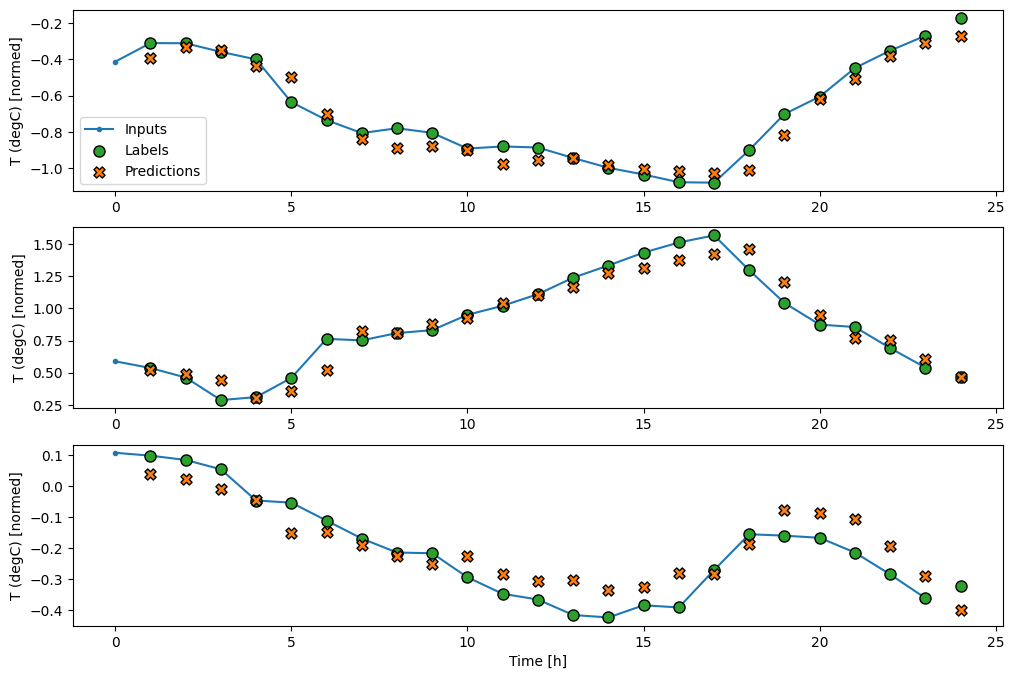

In [44]:
wide_window.plot(linear)

One advantage to linear models is that they're relatively simple to  interpret.
You can pull out the layer's weights and visualize the weight assigned to each input:

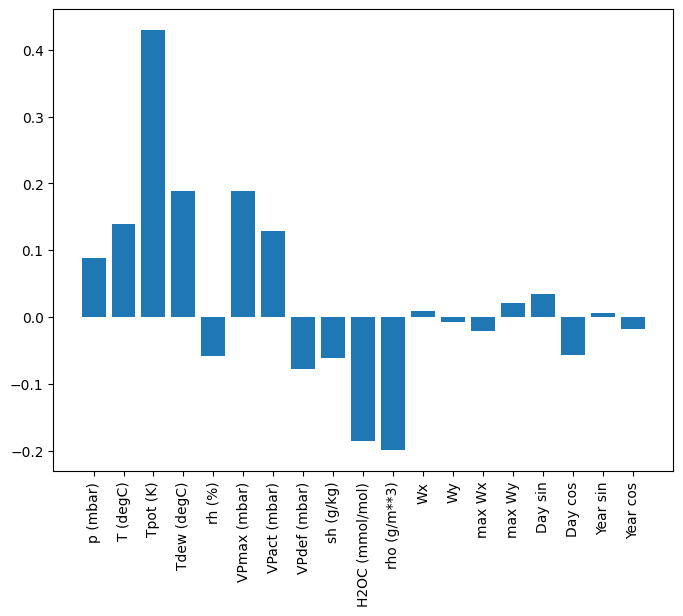

In [45]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

Sometimes the model doesn't even place the most weight on the input `T (degC)`. This is one of the risks of random initialization. 

### Dense

Before applying models that actually operate on multiple time-steps, it's worth checking the performance of deeper, more powerful, single input step models.

Here's a model similar to the `linear` model, except it stacks several a few `Dense` layers between the input and the output: 

In [41]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20


   1/1534 [..............................] - ETA: 18:56 - loss: 1.2348 - mean_absolute_error: 0.8587

  52/1534 [>.............................] - ETA: 1s - loss: 0.1828 - mean_absolute_error: 0.2681   

 107/1534 [=>............................] - ETA: 1s - loss: 0.0990 - mean_absolute_error: 0.1856

 167/1534 [==>...........................] - ETA: 1s - loss: 0.0686 - mean_absolute_error: 0.1517

 228/1534 [===>..........................] - ETA: 1s - loss: 0.0538 - mean_absolute_error: 0.1340

 288/1534 [====>.........................] - ETA: 1s - loss: 0.0452 - mean_absolute_error: 0.1239

 349/1534 [=====>........................] - ETA: 1s - loss: 0.0394 - mean_absolute_error: 0.1164

 409/1534 [======>.......................] - ETA: 0s - loss: 0.0352 - mean_absolute_error: 0.1106

 470/1534 [========>.....................] - ETA: 0s - loss: 0.0319 - mean_absolute_error: 0.1059

 531/1534 [=========>....................] - ETA: 0s - loss: 0.0294 - mean_absolute_error: 0.1026

 592/1534 [==========>...................] - ETA: 0s - loss: 0.0274 - mean_absolute_error: 0.0997

 653/1534 [===========>..................] - ETA: 0s - loss: 0.0257 - mean_absolute_error: 0.0970

 714/1534 [============>.................] - ETA: 0s - loss: 0.0244 - mean_absolute_error: 0.0951

 775/1534 [==============>...............] - ETA: 0s - loss: 0.0232 - mean_absolute_error: 0.0932

 836/1534 [===============>..............] - ETA: 0s - loss: 0.0221 - mean_absolute_error: 0.0913

 897/1534 [================>.............] - ETA: 0s - loss: 0.0212 - mean_absolute_error: 0.0898

 958/1534 [=================>............] - ETA: 0s - loss: 0.0204 - mean_absolute_error: 0.0886

1019/1534 [==================>...........] - ETA: 0s - loss: 0.0197 - mean_absolute_error: 0.0871

1081/1534 [====================>.........] - ETA: 0s - loss: 0.0191 - mean_absolute_error: 0.0863

1143/1534 [=====================>........] - ETA: 0s - loss: 0.0185 - mean_absolute_error: 0.0853

1204/1534 [======================>.......] - ETA: 0s - loss: 0.0180 - mean_absolute_error: 0.0843

1266/1534 [=======================>......] - ETA: 0s - loss: 0.0175 - mean_absolute_error: 0.0834

1328/1534 [========================>.....] - ETA: 0s - loss: 0.0171 - mean_absolute_error: 0.0825

1390/1534 [==========================>...] - ETA: 0s - loss: 0.0167 - mean_absolute_error: 0.0819

1452/1534 [===========================>..] - ETA: 0s - loss: 0.0163 - mean_absolute_error: 0.0812

1514/1534 [============================>.] - ETA: 0s - loss: 0.0160 - mean_absolute_error: 0.0806

1534/1534 [==============================] - 3s 1ms/step - loss: 0.0159 - mean_absolute_error: 0.0804 - val_loss: 0.0077 - val_mean_absolute_error: 0.0636


Epoch 2/20


   1/1534 [..............................] - ETA: 40s - loss: 0.0151 - mean_absolute_error: 0.0869

  61/1534 [>.............................] - ETA: 1s - loss: 0.0088 - mean_absolute_error: 0.0679 

 123/1534 [=>............................] - ETA: 1s - loss: 0.0083 - mean_absolute_error: 0.0666

 185/1534 [==>...........................] - ETA: 1s - loss: 0.0081 - mean_absolute_error: 0.0655

 247/1534 [===>..........................] - ETA: 1s - loss: 0.0082 - mean_absolute_error: 0.0658

 309/1534 [=====>........................] - ETA: 1s - loss: 0.0083 - mean_absolute_error: 0.0664

 370/1534 [======>.......................] - ETA: 0s - loss: 0.0084 - mean_absolute_error: 0.0668

 433/1534 [=======>......................] - ETA: 0s - loss: 0.0084 - mean_absolute_error: 0.0667

 494/1534 [========>.....................] - ETA: 0s - loss: 0.0083 - mean_absolute_error: 0.0665

 556/1534 [=========>....................] - ETA: 0s - loss: 0.0084 - mean_absolute_error: 0.0665

 618/1534 [===========>..................] - ETA: 0s - loss: 0.0082 - mean_absolute_error: 0.0660

 679/1534 [============>.................] - ETA: 0s - loss: 0.0082 - mean_absolute_error: 0.0657

 741/1534 [=============>................] - ETA: 0s - loss: 0.0083 - mean_absolute_error: 0.0660

 802/1534 [==============>...............] - ETA: 0s - loss: 0.0082 - mean_absolute_error: 0.0657

 863/1534 [===============>..............] - ETA: 0s - loss: 0.0082 - mean_absolute_error: 0.0655

 924/1534 [=================>............] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0653

 986/1534 [==================>...........] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0651

1048/1534 [===================>..........] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0651

1109/1534 [====================>.........] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0651

1170/1534 [=====================>........] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0650

1231/1534 [=======================>......] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0647

1292/1534 [========================>.....] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0646

1353/1534 [=========================>....] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0646

1415/1534 [==========================>...] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0646

1476/1534 [===========================>..] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0645

1534/1534 [==============================] - 2s 1ms/step - loss: 0.0079 - mean_absolute_error: 0.0644 - val_loss: 0.0073 - val_mean_absolute_error: 0.0620


Epoch 3/20


   1/1534 [..............................] - ETA: 42s - loss: 0.0075 - mean_absolute_error: 0.0650

  60/1534 [>.............................] - ETA: 1s - loss: 0.0081 - mean_absolute_error: 0.0639 

 121/1534 [=>............................] - ETA: 1s - loss: 0.0079 - mean_absolute_error: 0.0638

 182/1534 [==>...........................] - ETA: 1s - loss: 0.0078 - mean_absolute_error: 0.0637

 243/1534 [===>..........................] - ETA: 1s - loss: 0.0080 - mean_absolute_error: 0.0642

 304/1534 [====>.........................] - ETA: 1s - loss: 0.0081 - mean_absolute_error: 0.0644

 365/1534 [======>.......................] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0644

 427/1534 [=======>......................] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0642

 487/1534 [========>.....................] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0639

 548/1534 [=========>....................] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0640

 609/1534 [==========>...................] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0640

 669/1534 [============>.................] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0636

 729/1534 [=============>................] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0637

 790/1534 [==============>...............] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0637

 850/1534 [===============>..............] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0634

 911/1534 [================>.............] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.0632

 971/1534 [=================>............] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.0632

1031/1534 [===================>..........] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0629

1091/1534 [====================>.........] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0628

1151/1534 [=====================>........] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0627

1205/1534 [======================>.......] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0626

1263/1534 [=======================>......] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0626

1322/1534 [========================>.....] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0625

1381/1534 [==========================>...] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0624

1440/1534 [===========================>..] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0622

1499/1534 [============================>.] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0622

1534/1534 [==============================] - 2s 1ms/step - loss: 0.0075 - mean_absolute_error: 0.0622 - val_loss: 0.0070 - val_mean_absolute_error: 0.0607


Epoch 4/20


   1/1534 [..............................] - ETA: 42s - loss: 0.0068 - mean_absolute_error: 0.0567

  59/1534 [>.............................] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0613 

 120/1534 [=>............................] - ETA: 1s - loss: 0.0074 - mean_absolute_error: 0.0620

 180/1534 [==>...........................] - ETA: 1s - loss: 0.0073 - mean_absolute_error: 0.0614

 240/1534 [===>..........................] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0620

 299/1534 [====>.........................] - ETA: 1s - loss: 0.0076 - mean_absolute_error: 0.0622

 357/1534 [=====>........................] - ETA: 1s - loss: 0.0076 - mean_absolute_error: 0.0621

 416/1534 [=======>......................] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0622

 476/1534 [========>.....................] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0618

 536/1534 [=========>....................] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0618

 594/1534 [==========>...................] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0617

 653/1534 [===========>..................] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0614

 713/1534 [============>.................] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0615

 772/1534 [==============>...............] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0615

 830/1534 [===============>..............] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0613

 888/1534 [================>.............] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0611

 947/1534 [=================>............] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0612

1006/1534 [==================>...........] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0610

1065/1534 [===================>..........] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0609

1123/1534 [====================>.........] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0608

1183/1534 [======================>.......] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0608

1243/1534 [=======================>......] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0606

1301/1534 [========================>.....] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0606

1360/1534 [=========================>....] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0606

1419/1534 [==========================>...] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0606

1478/1534 [===========================>..] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0606

1534/1534 [==============================] - 2s 1ms/step - loss: 0.0072 - mean_absolute_error: 0.0605 - val_loss: 0.0067 - val_mean_absolute_error: 0.0588


Epoch 5/20


   1/1534 [..............................] - ETA: 42s - loss: 0.0034 - mean_absolute_error: 0.0421

  59/1534 [>.............................] - ETA: 1s - loss: 0.0073 - mean_absolute_error: 0.0600 

 119/1534 [=>............................] - ETA: 1s - loss: 0.0073 - mean_absolute_error: 0.0605

 179/1534 [==>...........................] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0601

 241/1534 [===>..........................] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0603

 301/1534 [====>.........................] - ETA: 1s - loss: 0.0073 - mean_absolute_error: 0.0607

 360/1534 [======>.......................] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0614

 420/1534 [=======>......................] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0617

 480/1534 [========>.....................] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0612

 540/1534 [=========>....................] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0612

 600/1534 [==========>...................] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0609

 658/1534 [===========>..................] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0605

 717/1534 [=============>................] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0608

 779/1534 [==============>...............] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0610

 840/1534 [===============>..............] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0606

 900/1534 [================>.............] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0605

 959/1534 [=================>............] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0603

1018/1534 [==================>...........] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0601

1077/1534 [====================>.........] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0600

1137/1534 [=====================>........] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0600

1196/1534 [======================>.......] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0599

1256/1534 [=======================>......] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0599

1316/1534 [========================>.....] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0597

1376/1534 [=========================>....] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0597

1436/1534 [===========================>..] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0596

1495/1534 [============================>.] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0596

1534/1534 [==============================] - 2s 1ms/step - loss: 0.0070 - mean_absolute_error: 0.0595 - val_loss: 0.0072 - val_mean_absolute_error: 0.0616


Epoch 6/20


   1/1534 [..............................] - ETA: 40s - loss: 0.0037 - mean_absolute_error: 0.0494

  60/1534 [>.............................] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0556 

 120/1534 [=>............................] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0571

 179/1534 [==>...........................] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0569

 240/1534 [===>..........................] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0590

 299/1534 [====>.........................] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0594

 358/1534 [======>.......................] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0596

 417/1534 [=======>......................] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0596

 473/1534 [========>.....................] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0594

 532/1534 [=========>....................] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0596

 592/1534 [==========>...................] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0595

 652/1534 [===========>..................] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0590

 711/1534 [============>.................] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0592

 771/1534 [==============>...............] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0594

 830/1534 [===============>..............] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0593

 890/1534 [================>.............] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0591

 950/1534 [=================>............] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0592

1009/1534 [==================>...........] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0590

1069/1534 [===================>..........] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0591

1128/1534 [=====================>........] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0591

1188/1534 [======================>.......] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0591

1247/1534 [=======================>......] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0590

1306/1534 [========================>.....] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0590

1366/1534 [=========================>....] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0590

1425/1534 [==========================>...] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0591

1485/1534 [============================>.] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0590

1534/1534 [==============================] - 2s 1ms/step - loss: 0.0069 - mean_absolute_error: 0.0590 - val_loss: 0.0066 - val_mean_absolute_error: 0.0580


Epoch 7/20


   1/1534 [..............................] - ETA: 40s - loss: 0.0031 - mean_absolute_error: 0.0423

  60/1534 [>.............................] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0568 

 118/1534 [=>............................] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0577

 178/1534 [==>...........................] - ETA: 1s - loss: 0.0064 - mean_absolute_error: 0.0570

 237/1534 [===>..........................] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0580

 297/1534 [====>.........................] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0583

 355/1534 [=====>........................] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0586

 415/1534 [=======>......................] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0586

 474/1534 [========>.....................] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0584

 531/1534 [=========>....................] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0587

 590/1534 [==========>...................] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0587

 649/1534 [===========>..................] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0585

 708/1534 [============>.................] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0588

 767/1534 [==============>...............] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0591

 831/1534 [===============>..............] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0589

 892/1534 [================>.............] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0587

 950/1534 [=================>............] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0587

1008/1534 [==================>...........] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0585

1067/1534 [===================>..........] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0584

1126/1534 [=====================>........] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0584

1185/1534 [======================>.......] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0584

1244/1534 [=======================>......] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0583

1303/1534 [========================>.....] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0582

1362/1534 [=========================>....] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0583

1422/1534 [==========================>...] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0583

1481/1534 [===========================>..] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0583

1534/1534 [==============================] - 2s 1ms/step - loss: 0.0067 - mean_absolute_error: 0.0583 - val_loss: 0.0067 - val_mean_absolute_error: 0.0584


Epoch 8/20


   1/1534 [..............................] - ETA: 40s - loss: 0.0081 - mean_absolute_error: 0.0663

  57/1534 [>.............................] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0569 

 115/1534 [=>............................] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0574

 174/1534 [==>...........................] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0571

 233/1534 [===>..........................] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0582

 292/1534 [====>.........................] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0588

 351/1534 [=====>........................] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0599

 409/1534 [======>.......................] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0600

 469/1534 [========>.....................] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0595

 527/1534 [=========>....................] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0598

 585/1534 [==========>...................] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0596

 643/1534 [===========>..................] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0591

 701/1534 [============>.................] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0592

 759/1534 [=============>................] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0592

 819/1534 [===============>..............] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0590

 880/1534 [================>.............] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0589

 938/1534 [=================>............] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0587

 997/1534 [==================>...........] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0587

1056/1534 [===================>..........] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0586

1114/1534 [====================>.........] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0585

1173/1534 [=====================>........] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0585

1232/1534 [=======================>......] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0583

1291/1534 [========================>.....] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0584

1349/1534 [=========================>....] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0583

1407/1534 [==========================>...] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0583

1465/1534 [===========================>..] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0583

1524/1534 [============================>.] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0583

1534/1534 [==============================] - 2s 1ms/step - loss: 0.0068 - mean_absolute_error: 0.0583 - val_loss: 0.0065 - val_mean_absolute_error: 0.0575


Epoch 9/20


   1/1534 [..............................] - ETA: 40s - loss: 0.0034 - mean_absolute_error: 0.0461

  59/1534 [>.............................] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0572 

 117/1534 [=>............................] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0581

 177/1534 [==>...........................] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0573

 236/1534 [===>..........................] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0579

 295/1534 [====>.........................] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0584

 353/1534 [=====>........................] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0589

 411/1534 [=======>......................] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0588

 470/1534 [========>.....................] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0586

 529/1534 [=========>....................] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0587

 588/1534 [==========>...................] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0587

 648/1534 [===========>..................] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0583

 707/1534 [============>.................] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0583

 768/1534 [==============>...............] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0583

 829/1534 [===============>..............] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0581

 888/1534 [================>.............] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0580

 947/1534 [=================>............] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0579

1006/1534 [==================>...........] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0578

1065/1534 [===================>..........] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0578

1123/1534 [====================>.........] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0578

1181/1534 [======================>.......] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0578

1241/1534 [=======================>......] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0578

1300/1534 [========================>.....] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0578

1359/1534 [=========================>....] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0577

1417/1534 [==========================>...] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0577

1476/1534 [===========================>..] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0577

1534/1534 [==============================] - 2s 1ms/step - loss: 0.0067 - mean_absolute_error: 0.0576 - val_loss: 0.0069 - val_mean_absolute_error: 0.0611


Epoch 10/20


   1/1534 [..............................] - ETA: 40s - loss: 0.0072 - mean_absolute_error: 0.0669

  60/1534 [>.............................] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0561 

 120/1534 [=>............................] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0564

 180/1534 [==>...........................] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0564

 240/1534 [===>..........................] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0573

 300/1534 [====>.........................] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0578

 359/1534 [======>.......................] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0582

 421/1534 [=======>......................] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0582

 482/1534 [========>.....................] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0579

 541/1534 [=========>....................] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0581

 600/1534 [==========>...................] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0581

 659/1534 [===========>..................] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0577

 718/1534 [=============>................] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0579

 778/1534 [==============>...............] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0579

 837/1534 [===============>..............] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0577

 896/1534 [================>.............] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0578

 956/1534 [=================>............] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0577

1015/1534 [==================>...........] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0576

1073/1534 [===================>..........] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0575

1132/1534 [=====================>........] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0575

1191/1534 [======================>.......] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0575

1249/1534 [=======================>......] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0574

1308/1534 [========================>.....] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0573

1368/1534 [=========================>....] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0572

1428/1534 [==========================>...] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0572

1487/1534 [============================>.] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0573

1534/1534 [==============================] - 2s 1ms/step - loss: 0.0066 - mean_absolute_error: 0.0573 - val_loss: 0.0066 - val_mean_absolute_error: 0.0582


  1/439 [..............................] - ETA: 30s - loss: 0.0042 - mean_absolute_error: 0.0544

 78/439 [====>.........................] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0601 

157/439 [=========>....................] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0593

235/439 [===============>..............] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0584

314/439 [====================>.........] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0581

392/439 [=========================>....] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0584

439/439 [==============================] - 0s 646us/step - loss: 0.0066 - mean_absolute_error: 0.0582


NameError: name 'val_performance' is not defined

### Multi-step dense

A single-time-step model has no context for the current values of its inputs. It can't see how the input features are changing over time. To address this issue the model needs access to multiple time steps when making predictions:

![Three time steps are used for each prediction.](images/conv_window.png)


The `baseline`, `linear` and `dense` models handled each time step independently. Here the model will take multiple time steps as input to produce a single output.

Create a `WindowGenerator` that will produce batches of three-hour inputs and one-hour labels:

Note that the `Window`'s `shift` parameter is relative to the end of the two windows.


In [47]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['T (degC)'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['T (degC)']

Text(0.5, 1.0, 'Given 3 hours of inputs, predict 1 hour into the future.')

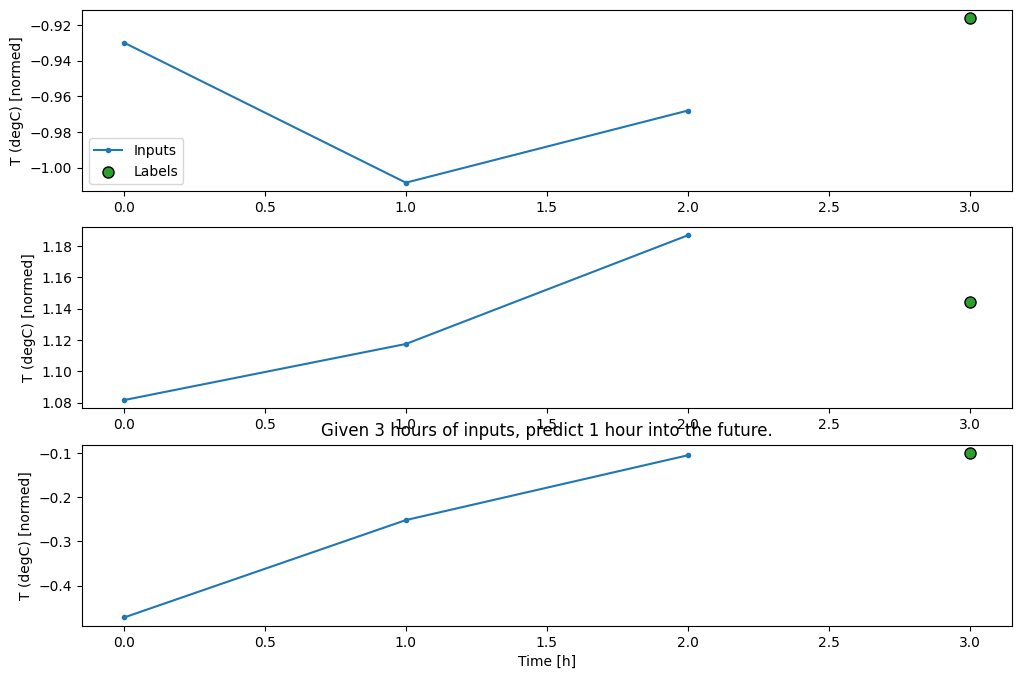

In [48]:
conv_window.plot()
plt.title("Given 3 hours of inputs, predict 1 hour into the future.")

You could train a `dense` model on a multiple-input-step window by adding a `tf.keras.layers.Flatten` as the first layer of the model:

In [49]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [50]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


In [51]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

  1/438 [..............................] - ETA: 28s - loss: 0.0076 - mean_absolute_error: 0.0634

 26/438 [>.............................] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0592 

 52/438 [==>...........................] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0582

 78/438 [====>.........................] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0586

104/438 [======>.......................] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0591

131/438 [=======>......................] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0586

159/438 [=========>....................] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0587

188/438 [===========>..................] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0591

216/438 [=============>................] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0594

244/438 [===============>..............] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0597

271/438 [=================>............] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0596

297/438 [===================>..........] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0592

324/438 [=====================>........] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0594

351/438 [=======================>......] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0593

378/438 [========================>.....] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0594

405/438 [==========================>...] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0596

433/438 [============================>.] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0595

438/438 [==============================] - 1s 2ms/step - loss: 0.0069 - mean_absolute_error: 0.0595


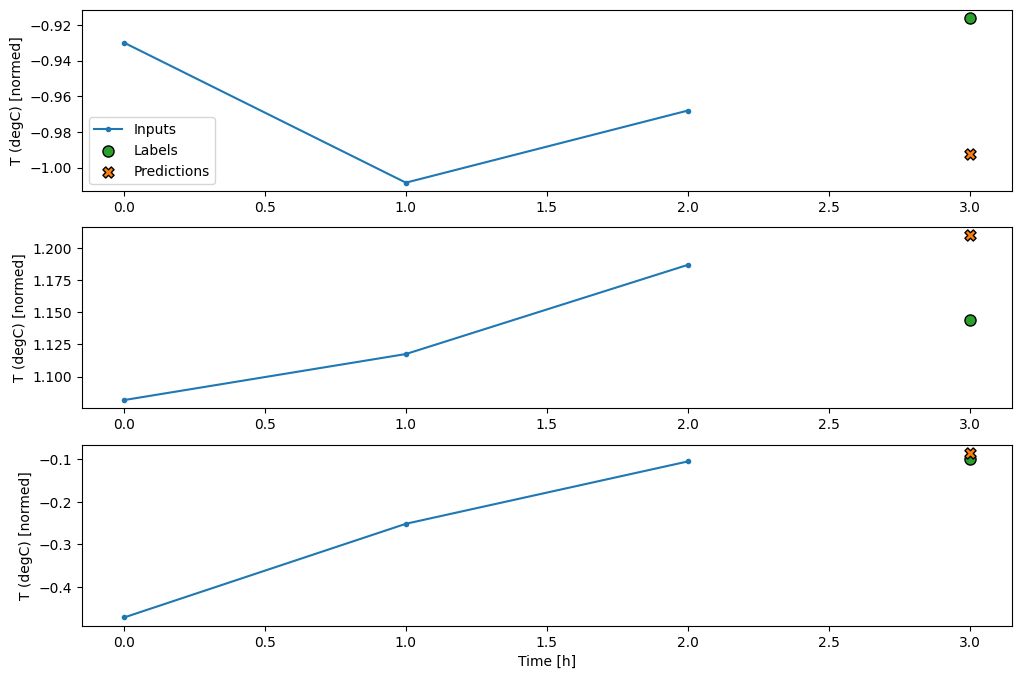

In [52]:
conv_window.plot(multi_step_dense)

The main down-side of this approach is that the resulting model can only be executed on input windows of exactly this shape. 

In [53]:
print('Input shape:', wide_window.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 24, 19)

ValueError:Exception encountered when calling layer 'sequential_2' (type Sequential).

Input 0 of layer "dense_4" is incompatible with the layer: expected axis -1 of input shape to have value 57, but received input with shape (32, 456)

Call arguments received by layer 'sequential_2' (type Sequential):
  • inputs=tf.Tensor(shape=(32, 24, 19), dtype=float32)
  • training=None
  • mask=None


The convolutional models in the next section fix this problem.

### Convolution neural network
 
A convolution layer (`tf.keras.layers.Conv1D`) also takes multiple time steps as input to each prediction.

Below is the **same** model as `multi_step_dense`, re-written with a convolution. 

Note the changes:
* The `tf.keras.layers.Flatten` and the first `tf.keras.layers.Dense` are replaced by a `tf.keras.layers.Conv1D`.
* The `tf.keras.layers.Reshape` is no longer necessary since the convolution keeps the time axis in its output.

In [54]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

Run it on an example batch to check that the model produces outputs with the expected shape:

In [55]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


Train and evaluate it on the ` conv_window` and it should give performance similar to the `multi_step_dense` model.

In [56]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

  1/438 [..............................] - ETA: 29s - loss: 0.0046 - mean_absolute_error: 0.0537

 21/438 [>.............................] - ETA: 1s - loss: 0.0059 - mean_absolute_error: 0.0571 

 41/438 [=>............................] - ETA: 1s - loss: 0.0062 - mean_absolute_error: 0.0581

 62/438 [===>..........................] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0582

 83/438 [====>.........................] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0588

104/438 [======>.......................] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0596

125/438 [=======>......................] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0598

147/438 [=========>....................] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0602

167/438 [==========>...................] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0597

187/438 [===========>..................] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0597

207/438 [=============>................] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0600

227/438 [==============>...............] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0603

247/438 [===============>..............] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0604

268/438 [=================>............] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0601

288/438 [==================>...........] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0602

309/438 [====================>.........] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0601

329/438 [=====================>........] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0600

349/438 [======================>.......] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0599

369/438 [========================>.....] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0598

389/438 [=========================>....] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0597

410/438 [===========================>..] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0596

430/438 [============================>.] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0597

438/438 [==============================] - 1s 3ms/step - loss: 0.0069 - mean_absolute_error: 0.0598


The difference between this `conv_model` and the `multi_step_dense` model is that the `conv_model` can be run on inputs of any length. The convolutional layer is applied to a sliding window of inputs:

![Executing a convolutional model on a sequence](images/wide_conv_window.png)

If you run it on wider input, it produces wider output:

In [57]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 19)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


Note that the output is shorter than the input. To make training or plotting work, you need the labels, and prediction to have the same length. So build a `WindowGenerator` to produce wide windows with a few extra input time steps so the label and prediction lengths match: 

In [58]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['T (degC)'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['T (degC)']

In [59]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 26, 19)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


Now, you can plot the model's predictions on a wider window. Note the 3 input time steps before the first prediction. Every prediction here is based on the 3 preceding time steps:

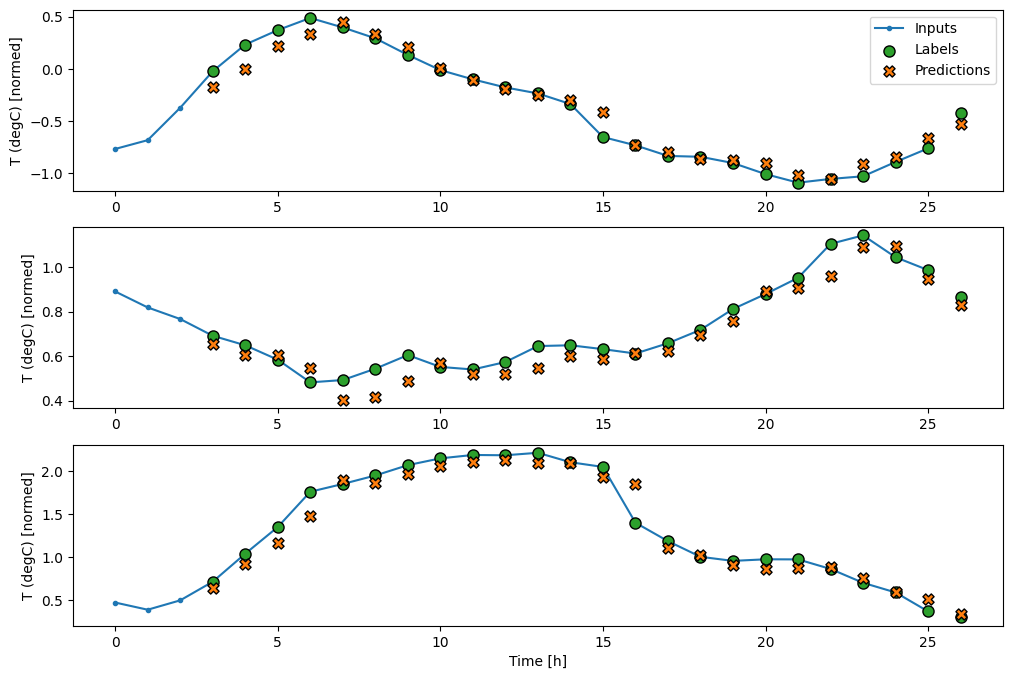

In [60]:
wide_conv_window.plot(conv_model)

### Recurrent neural network

A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state from time-step to time-step.

You can learn more in the [Text generation with an RNN](https://www.tensorflow.org/text/tutorials/text_generation) tutorial and the [Recurrent Neural Networks (RNN) with Keras](https://www.tensorflow.org/guide/keras/rnn) guide.

In this tutorial, you will use an RNN layer called Long Short-Term Memory (`tf.keras.layers.LSTM`).

An important constructor argument for all Keras RNN layers, such as `tf.keras.layers.LSTM`, is the `return_sequences` argument. This setting can configure the layer in one of two ways:

1. If `False`, the default, the layer only returns the output of the final time step, giving the model time to warm up its internal state before making a single prediction: 

![An LSTM warming up and making a single prediction](images/lstm_1_window.png)

2. If `True`, the layer returns an output for each input. This is useful for:
  * Stacking RNN layers. 
  * Training a model on multiple time steps simultaneously.

![An LSTM making a prediction after every time step](images/lstm_many_window.png)

In [34]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

With `return_sequences=True`, the model can be trained on 24 hours of data at a time.

Note: This will give a pessimistic view of the model's performance. On the first time step, the model has no access to previous steps and, therefore, can't do any better than the simple `linear` and `dense` models shown earlier.

In [35]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

NameError: name 'wide_window' is not defined

In [63]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

  1/438 [..............................] - ETA: 29s - loss: 0.0057 - mean_absolute_error: 0.0513

 18/438 [>.............................] - ETA: 1s - loss: 0.0056 - mean_absolute_error: 0.0510 

 36/438 [=>............................] - ETA: 1s - loss: 0.0057 - mean_absolute_error: 0.0513

 54/438 [==>...........................] - ETA: 1s - loss: 0.0056 - mean_absolute_error: 0.0512

 71/438 [===>..........................] - ETA: 1s - loss: 0.0056 - mean_absolute_error: 0.0512

 89/438 [=====>........................] - ETA: 1s - loss: 0.0056 - mean_absolute_error: 0.0512

107/438 [======>.......................] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0514

125/438 [=======>......................] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0512

143/438 [========>.....................] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0513

161/438 [==========>...................] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0513

179/438 [===========>..................] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0513

197/438 [============>.................] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0512

215/438 [=============>................] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0511

235/438 [===============>..............] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0511

254/438 [================>.............] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0511

273/438 [=================>............] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0510

291/438 [==================>...........] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0510

309/438 [====================>.........] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0511

327/438 [=====================>........] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0511

345/438 [======================>.......] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0511

363/438 [=======================>......] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0512

381/438 [=========================>....] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0512

399/438 [==========================>...] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0511

417/438 [===========================>..] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0511

436/438 [============================>.] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0511

438/438 [==============================] - 1s 3ms/step - loss: 0.0055 - mean_absolute_error: 0.0511


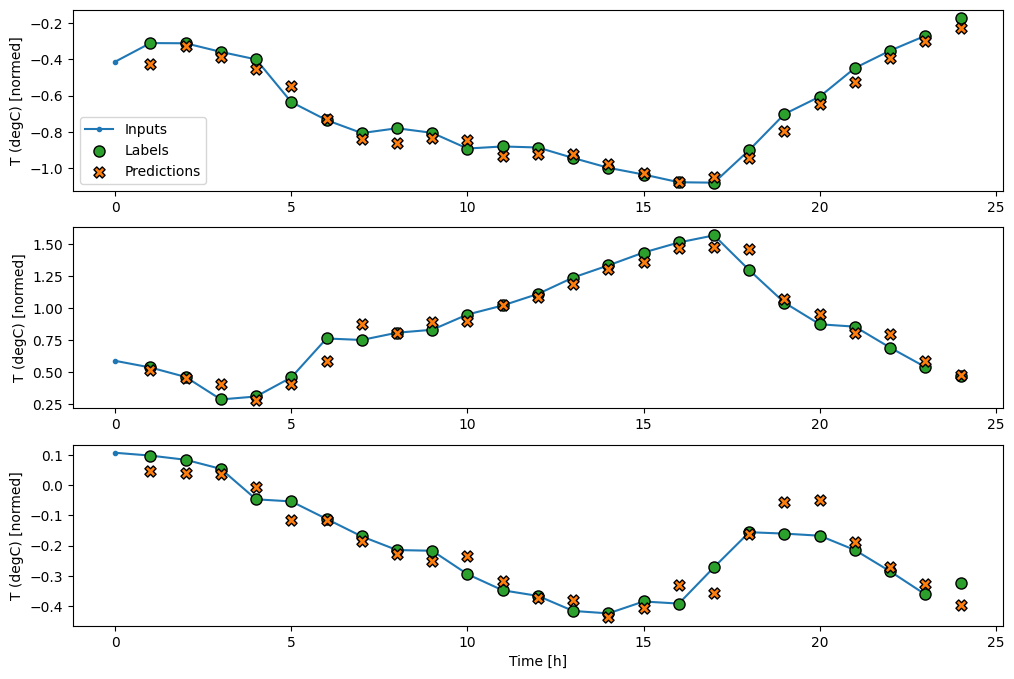

In [64]:
wide_window.plot(lstm_model)

### Performance

With this dataset typically each of the models does slightly better than the one before it:

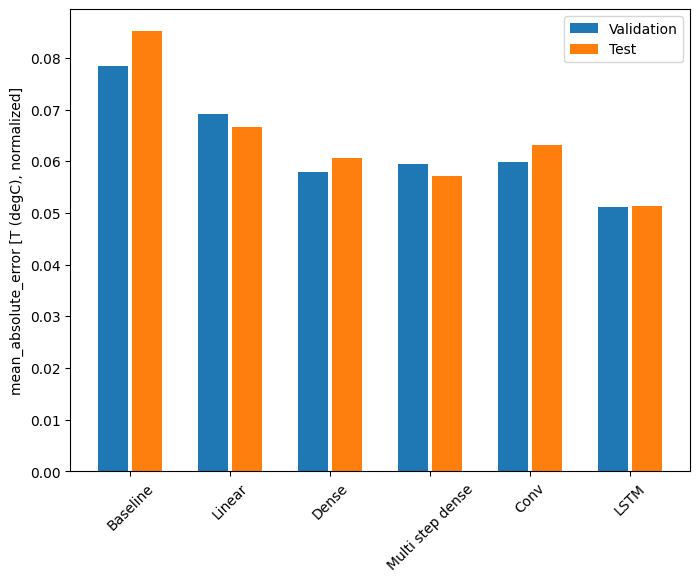

In [65]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [66]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.0852
Linear      : 0.0666
Dense       : 0.0608
Multi step dense: 0.0571
Conv        : 0.0632
LSTM        : 0.0514


### Multi-output models

The models so far all predicted a single output feature, `T (degC)`, for a single time step.

All of these models can be converted to predict multiple features just by changing the number of units in the output layer and adjusting the training windows to include all features in the `labels` (`example_labels`):

In [67]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 19)
Labels shape (batch, time, features): (32, 24, 19)


Note above that the `features` axis of the labels now has the same depth as the inputs, instead of `1`.

#### Baseline

The same baseline model (`Baseline`) can be used here, but this time repeating all features instead of selecting a specific `label_index`:

In [68]:
baseline = Baseline()
baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [69]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

  1/438 [..............................] - ETA: 58s - loss: 0.0742 - mean_absolute_error: 0.1493

 29/438 [>.............................] - ETA: 0s - loss: 0.0879 - mean_absolute_error: 0.1588 

 57/438 [==>...........................] - ETA: 0s - loss: 0.0890 - mean_absolute_error: 0.1599

 86/438 [====>.........................] - ETA: 0s - loss: 0.0899 - mean_absolute_error: 0.1602

113/438 [======>.......................] - ETA: 0s - loss: 0.0892 - mean_absolute_error: 0.1597

142/438 [========>.....................] - ETA: 0s - loss: 0.0894 - mean_absolute_error: 0.1598

172/438 [==========>...................] - ETA: 0s - loss: 0.0892 - mean_absolute_error: 0.1596

203/438 [============>.................] - ETA: 0s - loss: 0.0891 - mean_absolute_error: 0.1595

232/438 [==============>...............] - ETA: 0s - loss: 0.0890 - mean_absolute_error: 0.1595

261/438 [================>.............] - ETA: 0s - loss: 0.0885 - mean_absolute_error: 0.1590

290/438 [==================>...........] - ETA: 0s - loss: 0.0884 - mean_absolute_error: 0.1588

319/438 [====================>.........] - ETA: 0s - loss: 0.0883 - mean_absolute_error: 0.1587

348/438 [======================>.......] - ETA: 0s - loss: 0.0887 - mean_absolute_error: 0.1590

377/438 [========================>.....] - ETA: 0s - loss: 0.0887 - mean_absolute_error: 0.1590

404/438 [==========================>...] - ETA: 0s - loss: 0.0886 - mean_absolute_error: 0.1590

432/438 [============================>.] - ETA: 0s - loss: 0.0886 - mean_absolute_error: 0.1590

438/438 [==============================] - 1s 2ms/step - loss: 0.0886 - mean_absolute_error: 0.1589


#### Dense

In [70]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [71]:
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

  1/439 [..............................] - ETA: 27s - loss: 0.0783 - mean_absolute_error: 0.1365

 20/439 [>.............................] - ETA: 1s - loss: 0.0692 - mean_absolute_error: 0.1317 

 40/439 [=>............................] - ETA: 1s - loss: 0.0705 - mean_absolute_error: 0.1340

 60/439 [===>..........................] - ETA: 0s - loss: 0.0711 - mean_absolute_error: 0.1332

 81/439 [====>.........................] - ETA: 0s - loss: 0.0686 - mean_absolute_error: 0.1314

101/439 [=====>........................] - ETA: 0s - loss: 0.0684 - mean_absolute_error: 0.1314

121/439 [=======>......................] - ETA: 0s - loss: 0.0674 - mean_absolute_error: 0.1308

143/439 [========>.....................] - ETA: 0s - loss: 0.0671 - mean_absolute_error: 0.1308

164/439 [==========>...................] - ETA: 0s - loss: 0.0680 - mean_absolute_error: 0.1313

185/439 [===========>..................] - ETA: 0s - loss: 0.0683 - mean_absolute_error: 0.1315

206/439 [=============>................] - ETA: 0s - loss: 0.0685 - mean_absolute_error: 0.1318

227/439 [==============>...............] - ETA: 0s - loss: 0.0685 - mean_absolute_error: 0.1317

246/439 [===============>..............] - ETA: 0s - loss: 0.0680 - mean_absolute_error: 0.1313

266/439 [=================>............] - ETA: 0s - loss: 0.0679 - mean_absolute_error: 0.1312

287/439 [==================>...........] - ETA: 0s - loss: 0.0676 - mean_absolute_error: 0.1311

308/439 [====================>.........] - ETA: 0s - loss: 0.0673 - mean_absolute_error: 0.1309

328/439 [=====================>........] - ETA: 0s - loss: 0.0674 - mean_absolute_error: 0.1307

348/439 [======================>.......] - ETA: 0s - loss: 0.0676 - mean_absolute_error: 0.1309

369/439 [========================>.....] - ETA: 0s - loss: 0.0678 - mean_absolute_error: 0.1310

390/439 [=========================>....] - ETA: 0s - loss: 0.0678 - mean_absolute_error: 0.1310

411/439 [===========================>..] - ETA: 0s - loss: 0.0677 - mean_absolute_error: 0.1309

433/439 [============================>.] - ETA: 0s - loss: 0.0678 - mean_absolute_error: 0.1309

439/439 [==============================] - 1s 2ms/step - loss: 0.0678 - mean_absolute_error: 0.1309


#### RNN


In [36]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

NameError: name 'compile_and_fit' is not defined

<a id="residual"></a>

#### Advanced: Residual connections

The `Baseline` model from earlier took advantage of the fact that the sequence doesn't change drastically from time step to time step. Every model trained in this tutorial so far was randomly initialized, and then had to learn that the output is a a small change from the previous time step.

While you can get around this issue with careful initialization, it's  simpler to build this into the model structure.

It's common in time series analysis to build models that instead of predicting the next value, predict how the value will change in the next time step. Similarly, <a href="https://arxiv.org/abs/1512.03385" class="external">residual networks</a>—or ResNets—in deep learning refer to architectures where each layer adds to the model's accumulating result.

That is how you take advantage of the knowledge that the change should be small.

![A model with a residual connection](images/residual.png)

Essentially, this initializes the model to match the `Baseline`. For this task it helps models converge faster, with slightly better performance.

This approach can be used in conjunction with any model discussed in this tutorial. 

Here, it is being applied to the LSTM model, note the use of the `tf.initializers.zeros` to ensure that the initial predicted changes are small, and don't overpower the residual connection. There are no symmetry-breaking concerns for the gradients here, since the `zeros` are only used on the last layer.

In [73]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each time step is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [74]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

  1/438 [..............................] - ETA: 28s - loss: 0.0606 - mean_absolute_error: 0.1174

 17/438 [>.............................] - ETA: 1s - loss: 0.0636 - mean_absolute_error: 0.1185 

 34/438 [=>............................] - ETA: 1s - loss: 0.0631 - mean_absolute_error: 0.1183

 51/438 [==>...........................] - ETA: 1s - loss: 0.0628 - mean_absolute_error: 0.1180

 68/438 [===>..........................] - ETA: 1s - loss: 0.0626 - mean_absolute_error: 0.1178

 85/438 [====>.........................] - ETA: 1s - loss: 0.0622 - mean_absolute_error: 0.1177

103/438 [======>.......................] - ETA: 1s - loss: 0.0622 - mean_absolute_error: 0.1177

121/438 [=======>......................] - ETA: 0s - loss: 0.0622 - mean_absolute_error: 0.1178

139/438 [========>.....................] - ETA: 0s - loss: 0.0624 - mean_absolute_error: 0.1179

157/438 [=========>....................] - ETA: 0s - loss: 0.0625 - mean_absolute_error: 0.1180

174/438 [==========>...................] - ETA: 0s - loss: 0.0623 - mean_absolute_error: 0.1179

192/438 [============>.................] - ETA: 0s - loss: 0.0623 - mean_absolute_error: 0.1179

210/438 [=============>................] - ETA: 0s - loss: 0.0621 - mean_absolute_error: 0.1178

228/438 [==============>...............] - ETA: 0s - loss: 0.0621 - mean_absolute_error: 0.1178

246/438 [===============>..............] - ETA: 0s - loss: 0.0623 - mean_absolute_error: 0.1180

264/438 [=================>............] - ETA: 0s - loss: 0.0624 - mean_absolute_error: 0.1182

282/438 [==================>...........] - ETA: 0s - loss: 0.0623 - mean_absolute_error: 0.1181

300/438 [===================>..........] - ETA: 0s - loss: 0.0623 - mean_absolute_error: 0.1181

317/438 [====================>.........] - ETA: 0s - loss: 0.0624 - mean_absolute_error: 0.1181

335/438 [=====================>........] - ETA: 0s - loss: 0.0624 - mean_absolute_error: 0.1181

353/438 [=======================>......] - ETA: 0s - loss: 0.0623 - mean_absolute_error: 0.1180

371/438 [========================>.....] - ETA: 0s - loss: 0.0623 - mean_absolute_error: 0.1180

389/438 [=========================>....] - ETA: 0s - loss: 0.0622 - mean_absolute_error: 0.1180

406/438 [==========================>...] - ETA: 0s - loss: 0.0622 - mean_absolute_error: 0.1180

424/438 [============================>.] - ETA: 0s - loss: 0.0623 - mean_absolute_error: 0.1180

438/438 [==============================] - 1s 3ms/step - loss: 0.0623 - mean_absolute_error: 0.1181



CPU times: user 2min 21s, sys: 35 s, total: 2min 56s
Wall time: 56.1 s


#### Performance

Here is the overall performance for these multi-output models.

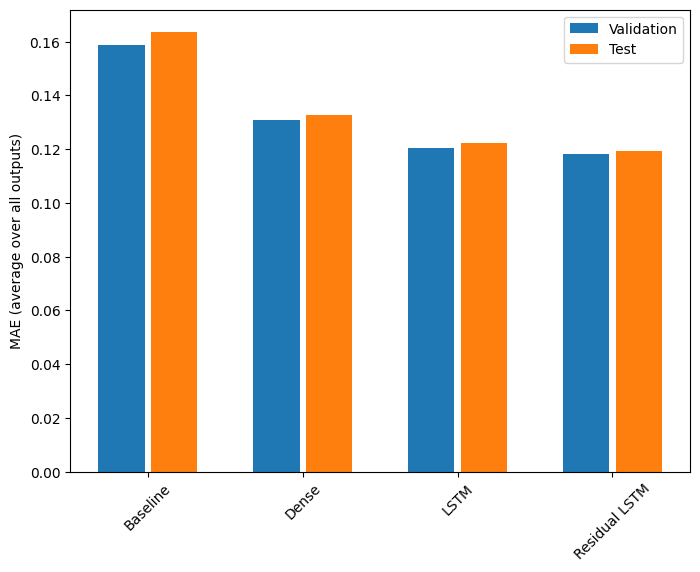

In [75]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [76]:
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

Baseline       : 0.1638
Dense          : 0.1327
LSTM           : 0.1224
Residual LSTM  : 0.1195


The above performances are averaged across all model outputs.

## Multi-step models

Both the single-output and multiple-output models in the previous sections made **single time step predictions**, one hour into the future.

This section looks at how to expand these models to make **multiple time step predictions**.

In a multi-step prediction, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predicts a sequence of the future values.

There are two rough approaches to this:

1. Single shot predictions where the entire time series is predicted at once.
2. Autoregressive predictions where the model only makes single step predictions and its output is fed back as its input.

In this section all the models will predict **all the features across all output time steps**.


For the multi-step model, the training data again consists of hourly samples. However, here, the models will learn to predict 24 hours into the future, given 24 hours of the past.

Here is a `Window` object that generates these slices from the dataset:

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

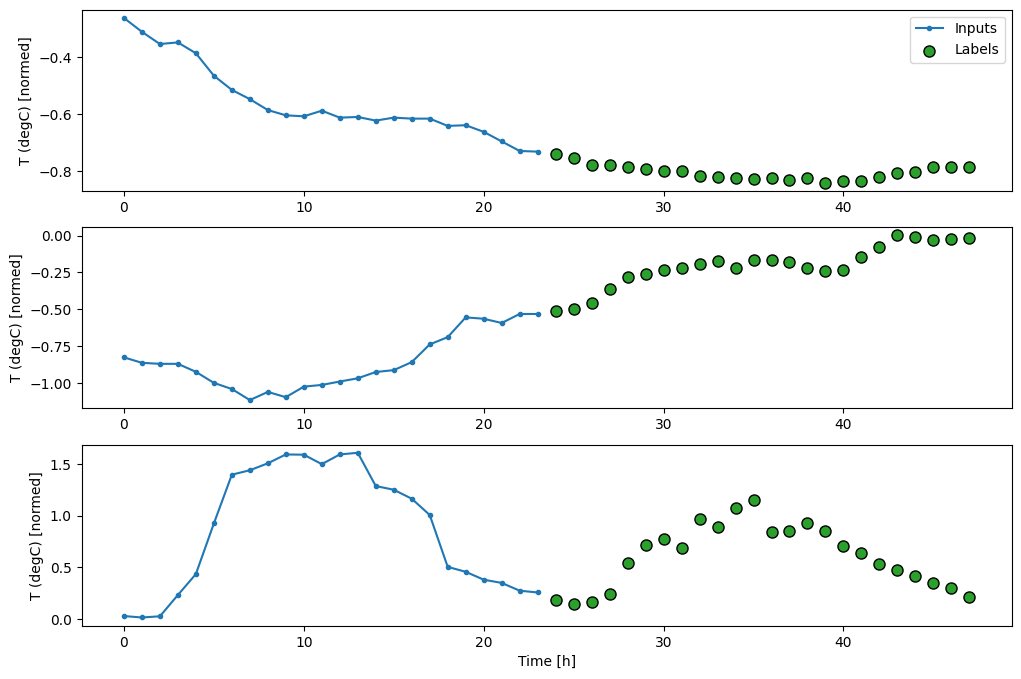

In [77]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

### Baselines

A simple baseline for this task is to repeat the last input time step for the required number of output time steps:

![Repeat the last input, for each output step](images/multistep_last.png)

  1/437 [..............................] - ETA: 1:10 - loss: 0.5638 - mean_absolute_error: 0.4671

 27/437 [>.............................] - ETA: 0s - loss: 0.6166 - mean_absolute_error: 0.4967  

 55/437 [==>...........................] - ETA: 0s - loss: 0.6164 - mean_absolute_error: 0.4962

 84/437 [====>.........................] - ETA: 0s - loss: 0.6269 - mean_absolute_error: 0.5004

111/437 [======>.......................] - ETA: 0s - loss: 0.6308 - mean_absolute_error: 0.5025

138/437 [========>.....................] - ETA: 0s - loss: 0.6293 - mean_absolute_error: 0.5022

168/437 [==========>...................] - ETA: 0s - loss: 0.6329 - mean_absolute_error: 0.5033

198/437 [============>.................] - ETA: 0s - loss: 0.6314 - mean_absolute_error: 0.5028

226/437 [==============>...............] - ETA: 0s - loss: 0.6316 - mean_absolute_error: 0.5029

254/437 [================>.............] - ETA: 0s - loss: 0.6314 - mean_absolute_error: 0.5023

281/437 [==================>...........] - ETA: 0s - loss: 0.6308 - mean_absolute_error: 0.5019

309/437 [====================>.........] - ETA: 0s - loss: 0.6298 - mean_absolute_error: 0.5014

337/437 [======================>.......] - ETA: 0s - loss: 0.6286 - mean_absolute_error: 0.5007

366/437 [========================>.....] - ETA: 0s - loss: 0.6301 - mean_absolute_error: 0.5013

393/437 [=========================>....] - ETA: 0s - loss: 0.6295 - mean_absolute_error: 0.5010

420/437 [===========================>..] - ETA: 0s - loss: 0.6293 - mean_absolute_error: 0.5009

437/437 [==============================] - 1s 2ms/step - loss: 0.6285 - mean_absolute_error: 0.5007


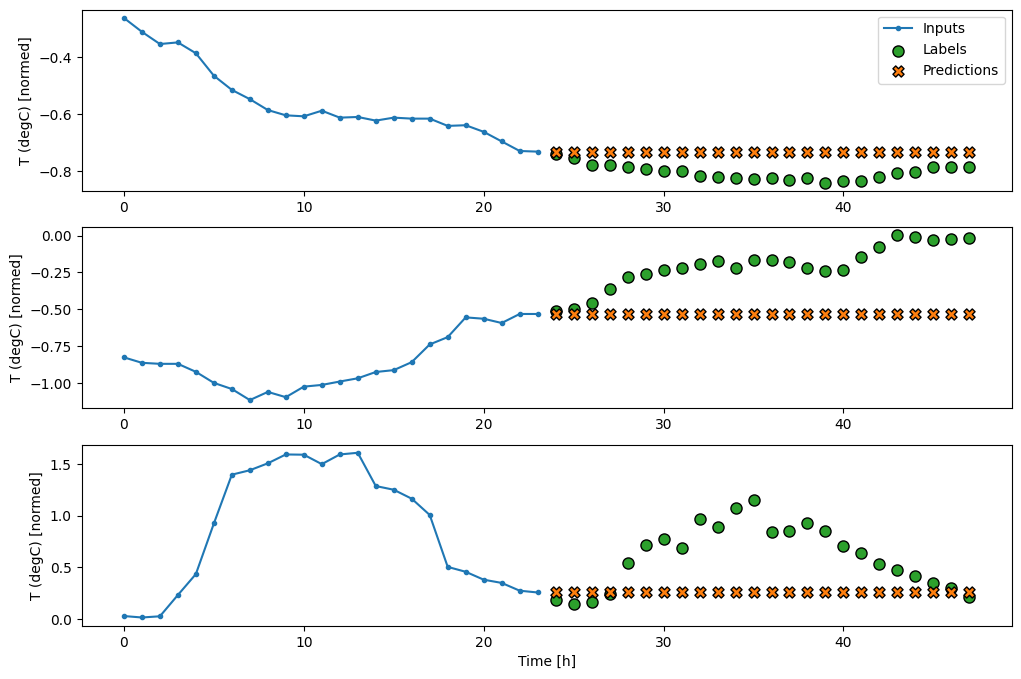

In [78]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

Since this task is to predict 24 hours into the future, given 24 hours of the past, another simple approach is to repeat the previous day, assuming tomorrow will be similar:

![Repeat the previous day](images/multistep_repeat.png)

  1/437 [..............................] - ETA: 56s - loss: 0.4320 - mean_absolute_error: 0.3949

 28/437 [>.............................] - ETA: 0s - loss: 0.4362 - mean_absolute_error: 0.4001 

 57/437 [==>...........................] - ETA: 0s - loss: 0.4320 - mean_absolute_error: 0.4004

 87/437 [====>.........................] - ETA: 0s - loss: 0.4234 - mean_absolute_error: 0.3959

117/437 [=======>......................] - ETA: 0s - loss: 0.4269 - mean_absolute_error: 0.3963

146/437 [=========>....................] - ETA: 0s - loss: 0.4302 - mean_absolute_error: 0.3975

175/437 [===========>..................] - ETA: 0s - loss: 0.4276 - mean_absolute_error: 0.3966

203/437 [============>.................] - ETA: 0s - loss: 0.4270 - mean_absolute_error: 0.3959

232/437 [==============>...............] - ETA: 0s - loss: 0.4269 - mean_absolute_error: 0.3955

261/437 [================>.............] - ETA: 0s - loss: 0.4290 - mean_absolute_error: 0.3966

291/437 [==================>...........] - ETA: 0s - loss: 0.4278 - mean_absolute_error: 0.3961

321/437 [=====================>........] - ETA: 0s - loss: 0.4270 - mean_absolute_error: 0.3957

351/437 [=======================>......] - ETA: 0s - loss: 0.4280 - mean_absolute_error: 0.3962

381/437 [=========================>....] - ETA: 0s - loss: 0.4275 - mean_absolute_error: 0.3962

411/437 [===========================>..] - ETA: 0s - loss: 0.4266 - mean_absolute_error: 0.3956

437/437 [==============================] - 1s 2ms/step - loss: 0.4270 - mean_absolute_error: 0.3959


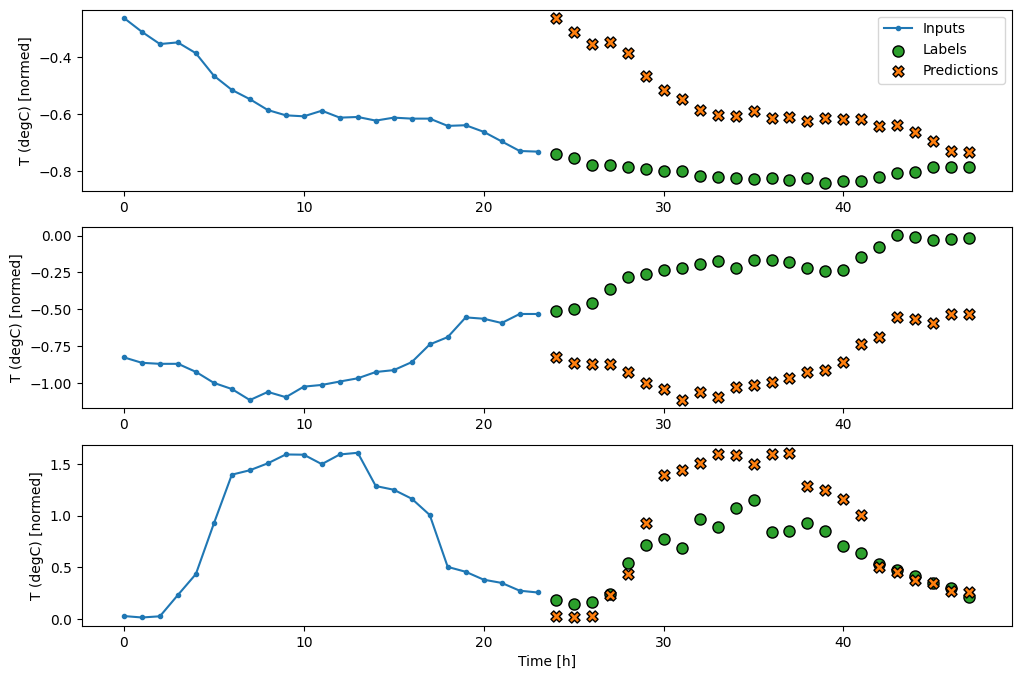

In [79]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                        metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

### Single-shot models

One high-level approach to this problem is to use a "single-shot" model, where the model makes the entire sequence prediction in a single step.

This can be implemented efficiently as a `tf.keras.layers.Dense` with `OUT_STEPS*features` output units. The model just needs to reshape that output to the required `(OUTPUT_STEPS, features)`.

#### Linear

A simple linear model based on the last input time step does better than either baseline, but is underpowered. The model needs to predict `OUTPUT_STEPS` time steps, from a single input time step with a linear projection. It can only capture a low-dimensional slice of the behavior, likely based mainly on the time of day and time of year.

![Predict all timesteps from the last time-step](images/multistep_dense.png)

  1/437 [..............................] - ETA: 26s - loss: 0.2745 - mean_absolute_error: 0.3072

 23/437 [>.............................] - ETA: 0s - loss: 0.2586 - mean_absolute_error: 0.3070 

 47/437 [==>...........................] - ETA: 0s - loss: 0.2601 - mean_absolute_error: 0.3072

 71/437 [===>..........................] - ETA: 0s - loss: 0.2598 - mean_absolute_error: 0.3079

 95/437 [=====>........................] - ETA: 0s - loss: 0.2588 - mean_absolute_error: 0.3070

120/437 [=======>......................] - ETA: 0s - loss: 0.2594 - mean_absolute_error: 0.3072

145/437 [========>.....................] - ETA: 0s - loss: 0.2593 - mean_absolute_error: 0.3073

171/437 [==========>...................] - ETA: 0s - loss: 0.2587 - mean_absolute_error: 0.3073

196/437 [============>.................] - ETA: 0s - loss: 0.2579 - mean_absolute_error: 0.3070

220/437 [==============>...............] - ETA: 0s - loss: 0.2581 - mean_absolute_error: 0.3069

245/437 [===============>..............] - ETA: 0s - loss: 0.2573 - mean_absolute_error: 0.3064

270/437 [=================>............] - ETA: 0s - loss: 0.2567 - mean_absolute_error: 0.3062

294/437 [===================>..........] - ETA: 0s - loss: 0.2569 - mean_absolute_error: 0.3062

318/437 [====================>.........] - ETA: 0s - loss: 0.2572 - mean_absolute_error: 0.3062

343/437 [======================>.......] - ETA: 0s - loss: 0.2569 - mean_absolute_error: 0.3059

368/437 [========================>.....] - ETA: 0s - loss: 0.2569 - mean_absolute_error: 0.3059

393/437 [=========================>....] - ETA: 0s - loss: 0.2568 - mean_absolute_error: 0.3059

417/437 [===========================>..] - ETA: 0s - loss: 0.2568 - mean_absolute_error: 0.3058

437/437 [==============================] - 1s 2ms/step - loss: 0.2568 - mean_absolute_error: 0.3060


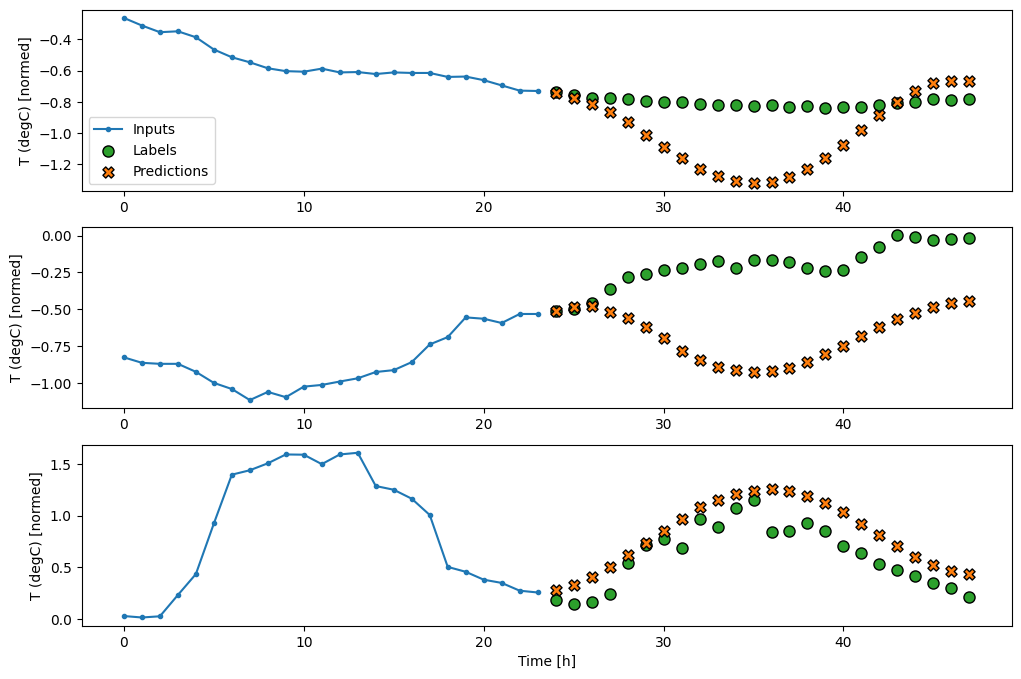

In [80]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

#### Dense

Adding a `tf.keras.layers.Dense` between the input and output gives the linear model more power, but is still only based on a single input time step.

  1/437 [..............................] - ETA: 27s - loss: 0.2077 - mean_absolute_error: 0.2714

 22/437 [>.............................] - ETA: 1s - loss: 0.2069 - mean_absolute_error: 0.2735 

 44/437 [==>...........................] - ETA: 0s - loss: 0.2077 - mean_absolute_error: 0.2747

 66/437 [===>..........................] - ETA: 0s - loss: 0.2090 - mean_absolute_error: 0.2756

 88/437 [=====>........................] - ETA: 0s - loss: 0.2107 - mean_absolute_error: 0.2765

110/437 [======>.......................] - ETA: 0s - loss: 0.2117 - mean_absolute_error: 0.2767

133/437 [========>.....................] - ETA: 0s - loss: 0.2129 - mean_absolute_error: 0.2774

156/437 [=========>....................] - ETA: 0s - loss: 0.2156 - mean_absolute_error: 0.2787

177/437 [===========>..................] - ETA: 0s - loss: 0.2163 - mean_absolute_error: 0.2792

199/437 [============>.................] - ETA: 0s - loss: 0.2169 - mean_absolute_error: 0.2797

221/437 [==============>...............] - ETA: 0s - loss: 0.2169 - mean_absolute_error: 0.2799

243/437 [===============>..............] - ETA: 0s - loss: 0.2164 - mean_absolute_error: 0.2795

264/437 [=================>............] - ETA: 0s - loss: 0.2162 - mean_absolute_error: 0.2793

286/437 [==================>...........] - ETA: 0s - loss: 0.2161 - mean_absolute_error: 0.2793

308/437 [====================>.........] - ETA: 0s - loss: 0.2167 - mean_absolute_error: 0.2795

330/437 [=====================>........] - ETA: 0s - loss: 0.2173 - mean_absolute_error: 0.2797

352/437 [=======================>......] - ETA: 0s - loss: 0.2172 - mean_absolute_error: 0.2795

374/437 [========================>.....] - ETA: 0s - loss: 0.2171 - mean_absolute_error: 0.2796

396/437 [==========================>...] - ETA: 0s - loss: 0.2175 - mean_absolute_error: 0.2799

418/437 [===========================>..] - ETA: 0s - loss: 0.2174 - mean_absolute_error: 0.2798

437/437 [==============================] - 1s 2ms/step - loss: 0.2175 - mean_absolute_error: 0.2799


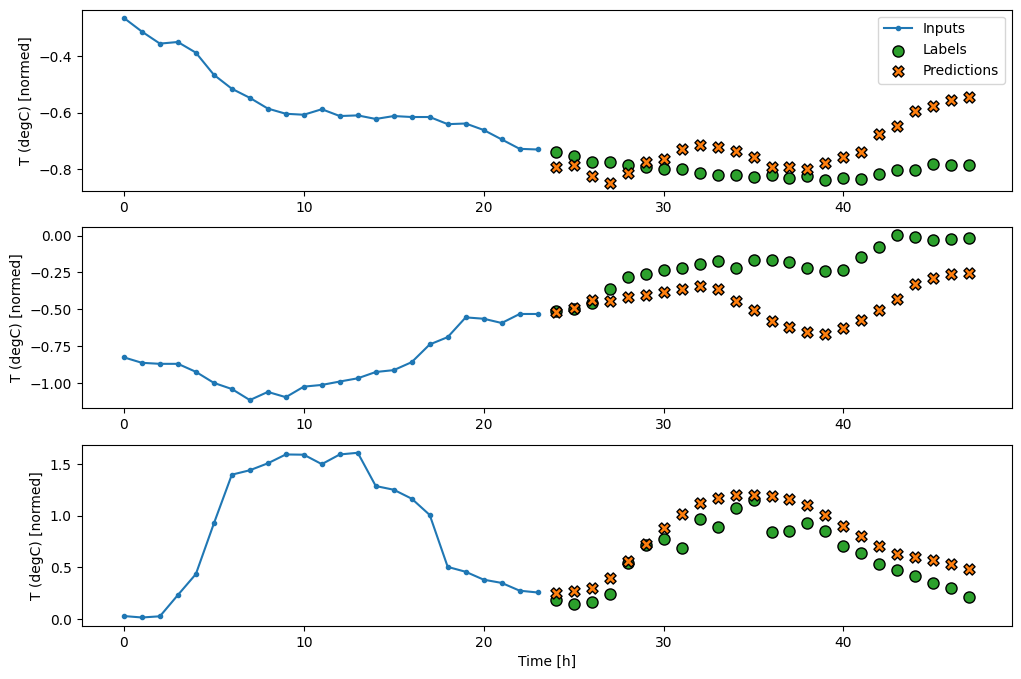

In [81]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

#### CNN

A convolutional model makes predictions based on a fixed-width history, which may lead to better performance than the dense model since it can see how things are changing over time:

![A convolutional model sees how things change over time](images/multistep_conv.png)

  1/437 [..............................] - ETA: 27s - loss: 0.1699 - mean_absolute_error: 0.2583

 22/437 [>.............................] - ETA: 1s - loss: 0.2089 - mean_absolute_error: 0.2818 

 44/437 [==>...........................] - ETA: 0s - loss: 0.2157 - mean_absolute_error: 0.2850

 68/437 [===>..........................] - ETA: 0s - loss: 0.2157 - mean_absolute_error: 0.2847

 91/437 [=====>........................] - ETA: 0s - loss: 0.2171 - mean_absolute_error: 0.2853

114/437 [======>.......................] - ETA: 0s - loss: 0.2176 - mean_absolute_error: 0.2855

136/437 [========>.....................] - ETA: 0s - loss: 0.2173 - mean_absolute_error: 0.2858

159/437 [=========>....................] - ETA: 0s - loss: 0.2175 - mean_absolute_error: 0.2858

182/437 [===========>..................] - ETA: 0s - loss: 0.2179 - mean_absolute_error: 0.2860

204/437 [=============>................] - ETA: 0s - loss: 0.2185 - mean_absolute_error: 0.2863

227/437 [==============>...............] - ETA: 0s - loss: 0.2183 - mean_absolute_error: 0.2860

250/437 [================>.............] - ETA: 0s - loss: 0.2187 - mean_absolute_error: 0.2862

272/437 [=================>............] - ETA: 0s - loss: 0.2186 - mean_absolute_error: 0.2862

295/437 [===================>..........] - ETA: 0s - loss: 0.2190 - mean_absolute_error: 0.2862

317/437 [====================>.........] - ETA: 0s - loss: 0.2186 - mean_absolute_error: 0.2860

340/437 [======================>.......] - ETA: 0s - loss: 0.2185 - mean_absolute_error: 0.2861

363/437 [=======================>......] - ETA: 0s - loss: 0.2185 - mean_absolute_error: 0.2862

386/437 [=========================>....] - ETA: 0s - loss: 0.2185 - mean_absolute_error: 0.2863

409/437 [===========================>..] - ETA: 0s - loss: 0.2184 - mean_absolute_error: 0.2862

432/437 [============================>.] - ETA: 0s - loss: 0.2188 - mean_absolute_error: 0.2863

437/437 [==============================] - 1s 2ms/step - loss: 0.2189 - mean_absolute_error: 0.2864


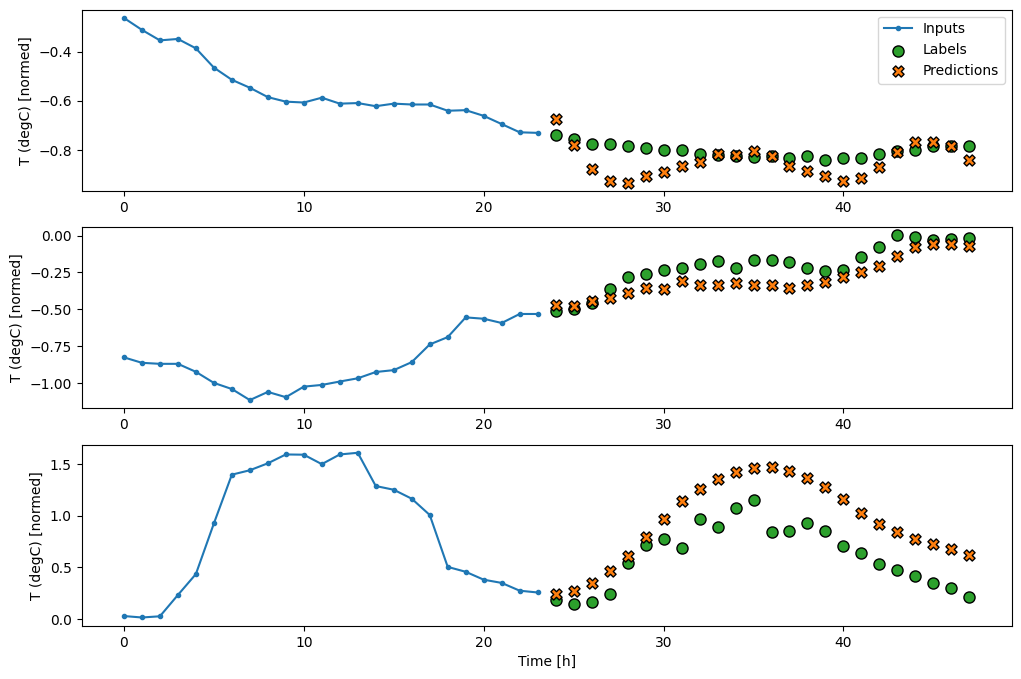

In [82]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

#### RNN

A recurrent model can learn to use a long history of inputs, if it's relevant to the predictions the model is making. Here the model will accumulate internal state for 24 hours, before making a single prediction for the next 24 hours.

In this single-shot format, the LSTM only needs to produce an output at the last time step, so set `return_sequences=False` in `tf.keras.layers.LSTM`.

![The LSTM accumulates state over the input window, and makes a single prediction for the next 24 hours](images/multistep_lstm.png)


  1/437 [..............................] - ETA: 27s - loss: 0.2156 - mean_absolute_error: 0.2873

 19/437 [>.............................] - ETA: 1s - loss: 0.2138 - mean_absolute_error: 0.2841 

 38/437 [=>............................] - ETA: 1s - loss: 0.2082 - mean_absolute_error: 0.2816

 57/437 [==>...........................] - ETA: 1s - loss: 0.2114 - mean_absolute_error: 0.2826

 76/437 [====>.........................] - ETA: 0s - loss: 0.2105 - mean_absolute_error: 0.2826

 96/437 [=====>........................] - ETA: 0s - loss: 0.2135 - mean_absolute_error: 0.2845

116/437 [======>.......................] - ETA: 0s - loss: 0.2134 - mean_absolute_error: 0.2846

136/437 [========>.....................] - ETA: 0s - loss: 0.2135 - mean_absolute_error: 0.2846

155/437 [=========>....................] - ETA: 0s - loss: 0.2141 - mean_absolute_error: 0.2848

175/437 [===========>..................] - ETA: 0s - loss: 0.2146 - mean_absolute_error: 0.2853

195/437 [============>.................] - ETA: 0s - loss: 0.2142 - mean_absolute_error: 0.2851

214/437 [=============>................] - ETA: 0s - loss: 0.2146 - mean_absolute_error: 0.2854

233/437 [==============>...............] - ETA: 0s - loss: 0.2148 - mean_absolute_error: 0.2855

252/437 [================>.............] - ETA: 0s - loss: 0.2150 - mean_absolute_error: 0.2856

271/437 [=================>............] - ETA: 0s - loss: 0.2145 - mean_absolute_error: 0.2853

290/437 [==================>...........] - ETA: 0s - loss: 0.2145 - mean_absolute_error: 0.2853

310/437 [====================>.........] - ETA: 0s - loss: 0.2140 - mean_absolute_error: 0.2849

329/437 [=====================>........] - ETA: 0s - loss: 0.2144 - mean_absolute_error: 0.2851

349/437 [======================>.......] - ETA: 0s - loss: 0.2147 - mean_absolute_error: 0.2853

368/437 [========================>.....] - ETA: 0s - loss: 0.2146 - mean_absolute_error: 0.2852

387/437 [=========================>....] - ETA: 0s - loss: 0.2150 - mean_absolute_error: 0.2855

406/437 [==========================>...] - ETA: 0s - loss: 0.2149 - mean_absolute_error: 0.2854

426/437 [============================>.] - ETA: 0s - loss: 0.2154 - mean_absolute_error: 0.2856

437/437 [==============================] - 1s 3ms/step - loss: 0.2155 - mean_absolute_error: 0.2857


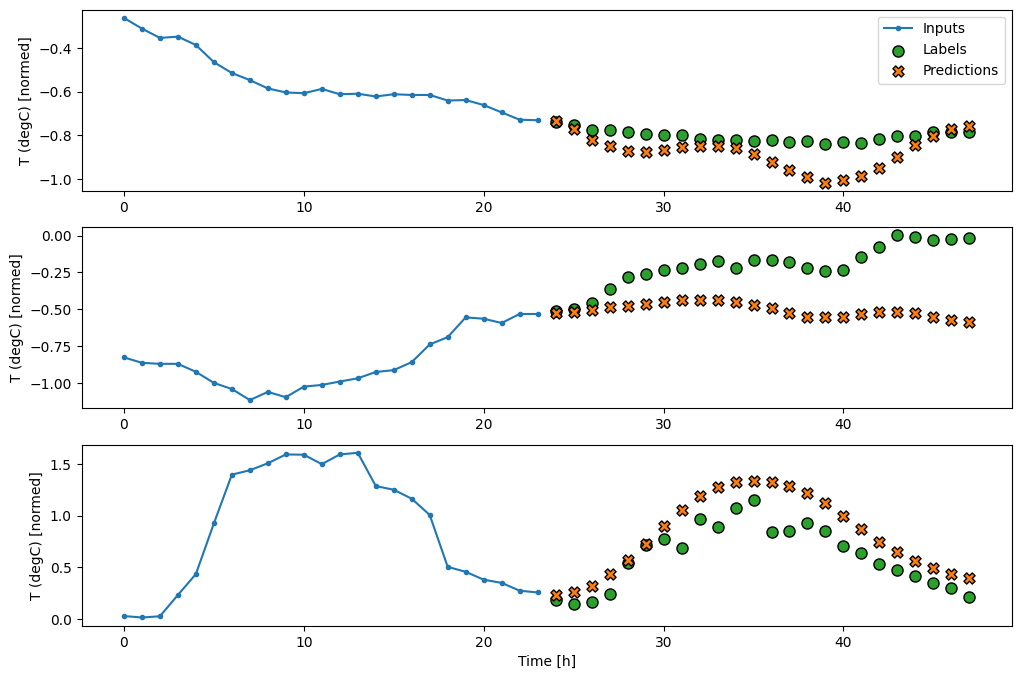

In [83]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

### Advanced: Autoregressive model

The above models all predict the entire output sequence in a single step.

In some cases it may be helpful for the model to decompose this prediction into individual time steps. Then, each model's output can be fed back into itself at each step and predictions can be made conditioned on the previous one, like in the classic <a href="https://arxiv.org/abs/1308.0850" class="external">Generating Sequences With Recurrent Neural Networks</a>.

One clear advantage to this style of model is that it can be set up to produce output with a varying length.

You could take any of the single-step multi-output models trained in the first half of this tutorial and run in an autoregressive feedback loop, but here you'll focus on building a model that's been explicitly trained to do that.

![Feedback a model's output to its input](images/multistep_autoregressive.png)

#### RNN

This tutorial only builds an autoregressive RNN model, but this pattern could be applied to any model that was designed to output a single time step.

The model will have the same basic form as the single-step LSTM models from earlier: a `tf.keras.layers.LSTM` layer followed by a `tf.keras.layers.Dense` layer that converts the `LSTM` layer's outputs to model predictions.

A `tf.keras.layers.LSTM` is a `tf.keras.layers.LSTMCell` wrapped in the higher level `tf.keras.layers.RNN` that manages the state and sequence results for you (Check out the [Recurrent Neural Networks (RNN) with Keras](https://www.tensorflow.org/guide/keras/rnn) guide for details).

In this case, the model has to manually manage the inputs for each step, so it uses `tf.keras.layers.LSTMCell` directly for the lower level, single time step interface.

In [84]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [85]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

The first method this model needs is a `warmup` method to initialize its internal state based on the inputs. Once trained, this state will capture the relevant parts of the input history. This is equivalent to the single-step `LSTM` model from earlier:

In [86]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

This method returns a single time-step prediction and the internal state of the `LSTM`:

In [87]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 19])

With the `RNN`'s state, and an initial prediction you can now continue iterating the model feeding the predictions at each step back as the input.

The simplest approach for collecting the output predictions is to use a Python list and a `tf.stack` after the loop.

Note: Stacking a Python list like this only works with eager-execution, using `Model.compile(..., run_eagerly=True)` for training, or with a fixed length output. For a dynamic output length, you would need to use a `tf.TensorArray` instead of a Python list, and `tf.range` instead of the Python `range`.

In [88]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

Test run this model on the example inputs:

In [89]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 24, 19)


Now, train the model:

  1/437 [..............................] - ETA: 29s - loss: 0.1917 - mean_absolute_error: 0.2825

  8/437 [..............................] - ETA: 3s - loss: 0.2190 - mean_absolute_error: 0.3012 

 16/437 [>.............................] - ETA: 3s - loss: 0.2157 - mean_absolute_error: 0.2962

 24/437 [>.............................] - ETA: 2s - loss: 0.2276 - mean_absolute_error: 0.3014

 32/437 [=>............................] - ETA: 2s - loss: 0.2251 - mean_absolute_error: 0.3000

 40/437 [=>............................] - ETA: 2s - loss: 0.2257 - mean_absolute_error: 0.3005

 48/437 [==>...........................] - ETA: 2s - loss: 0.2255 - mean_absolute_error: 0.2997

 56/437 [==>...........................] - ETA: 2s - loss: 0.2256 - mean_absolute_error: 0.2994

 64/437 [===>..........................] - ETA: 2s - loss: 0.2256 - mean_absolute_error: 0.2999

 72/437 [===>..........................] - ETA: 2s - loss: 0.2233 - mean_absolute_error: 0.2984

 80/437 [====>.........................] - ETA: 2s - loss: 0.2240 - mean_absolute_error: 0.2990

 88/437 [=====>........................] - ETA: 2s - loss: 0.2264 - mean_absolute_error: 0.3004

 96/437 [=====>........................] - ETA: 2s - loss: 0.2263 - mean_absolute_error: 0.3005

104/437 [======>.......................] - ETA: 2s - loss: 0.2265 - mean_absolute_error: 0.3006

112/437 [======>.......................] - ETA: 2s - loss: 0.2275 - mean_absolute_error: 0.3013

120/437 [=======>......................] - ETA: 2s - loss: 0.2267 - mean_absolute_error: 0.3010

128/437 [=======>......................] - ETA: 2s - loss: 0.2251 - mean_absolute_error: 0.3000

136/437 [========>.....................] - ETA: 2s - loss: 0.2247 - mean_absolute_error: 0.2999

144/437 [========>.....................] - ETA: 2s - loss: 0.2259 - mean_absolute_error: 0.3003

152/437 [=========>....................] - ETA: 1s - loss: 0.2256 - mean_absolute_error: 0.3001

160/437 [=========>....................] - ETA: 1s - loss: 0.2257 - mean_absolute_error: 0.3003

168/437 [==========>...................] - ETA: 1s - loss: 0.2259 - mean_absolute_error: 0.3004

176/437 [===========>..................] - ETA: 1s - loss: 0.2264 - mean_absolute_error: 0.3004

184/437 [===========>..................] - ETA: 1s - loss: 0.2262 - mean_absolute_error: 0.3002

192/437 [============>.................] - ETA: 1s - loss: 0.2255 - mean_absolute_error: 0.2998

200/437 [============>.................] - ETA: 1s - loss: 0.2251 - mean_absolute_error: 0.2994

208/437 [=============>................] - ETA: 1s - loss: 0.2254 - mean_absolute_error: 0.2995

216/437 [=============>................] - ETA: 1s - loss: 0.2255 - mean_absolute_error: 0.2996

224/437 [==============>...............] - ETA: 1s - loss: 0.2258 - mean_absolute_error: 0.2999

232/437 [==============>...............] - ETA: 1s - loss: 0.2262 - mean_absolute_error: 0.3001

240/437 [===============>..............] - ETA: 1s - loss: 0.2264 - mean_absolute_error: 0.3001

248/437 [================>.............] - ETA: 1s - loss: 0.2259 - mean_absolute_error: 0.2997

256/437 [================>.............] - ETA: 1s - loss: 0.2262 - mean_absolute_error: 0.2999

264/437 [=================>............] - ETA: 1s - loss: 0.2258 - mean_absolute_error: 0.2997

272/437 [=================>............] - ETA: 1s - loss: 0.2258 - mean_absolute_error: 0.2997

280/437 [==================>...........] - ETA: 1s - loss: 0.2259 - mean_absolute_error: 0.2997

288/437 [==================>...........] - ETA: 1s - loss: 0.2263 - mean_absolute_error: 0.3000

296/437 [===================>..........] - ETA: 0s - loss: 0.2260 - mean_absolute_error: 0.2998

304/437 [===================>..........] - ETA: 0s - loss: 0.2253 - mean_absolute_error: 0.2995

312/437 [====================>.........] - ETA: 0s - loss: 0.2259 - mean_absolute_error: 0.2998

320/437 [====================>.........] - ETA: 0s - loss: 0.2256 - mean_absolute_error: 0.2996

328/437 [=====================>........] - ETA: 0s - loss: 0.2252 - mean_absolute_error: 0.2995

336/437 [======================>.......] - ETA: 0s - loss: 0.2248 - mean_absolute_error: 0.2993

344/437 [======================>.......] - ETA: 0s - loss: 0.2253 - mean_absolute_error: 0.2996

352/437 [=======================>......] - ETA: 0s - loss: 0.2252 - mean_absolute_error: 0.2996

360/437 [=======================>......] - ETA: 0s - loss: 0.2251 - mean_absolute_error: 0.2996

368/437 [========================>.....] - ETA: 0s - loss: 0.2250 - mean_absolute_error: 0.2996

376/437 [========================>.....] - ETA: 0s - loss: 0.2249 - mean_absolute_error: 0.2996

384/437 [=========================>....] - ETA: 0s - loss: 0.2249 - mean_absolute_error: 0.2996

392/437 [=========================>....] - ETA: 0s - loss: 0.2250 - mean_absolute_error: 0.2996

400/437 [==========================>...] - ETA: 0s - loss: 0.2252 - mean_absolute_error: 0.2996

408/437 [===========================>..] - ETA: 0s - loss: 0.2251 - mean_absolute_error: 0.2995

416/437 [===========================>..] - ETA: 0s - loss: 0.2250 - mean_absolute_error: 0.2994

424/437 [============================>.] - ETA: 0s - loss: 0.2247 - mean_absolute_error: 0.2993

432/437 [============================>.] - ETA: 0s - loss: 0.2251 - mean_absolute_error: 0.2996

437/437 [==============================] - 3s 7ms/step - loss: 0.2251 - mean_absolute_error: 0.2995


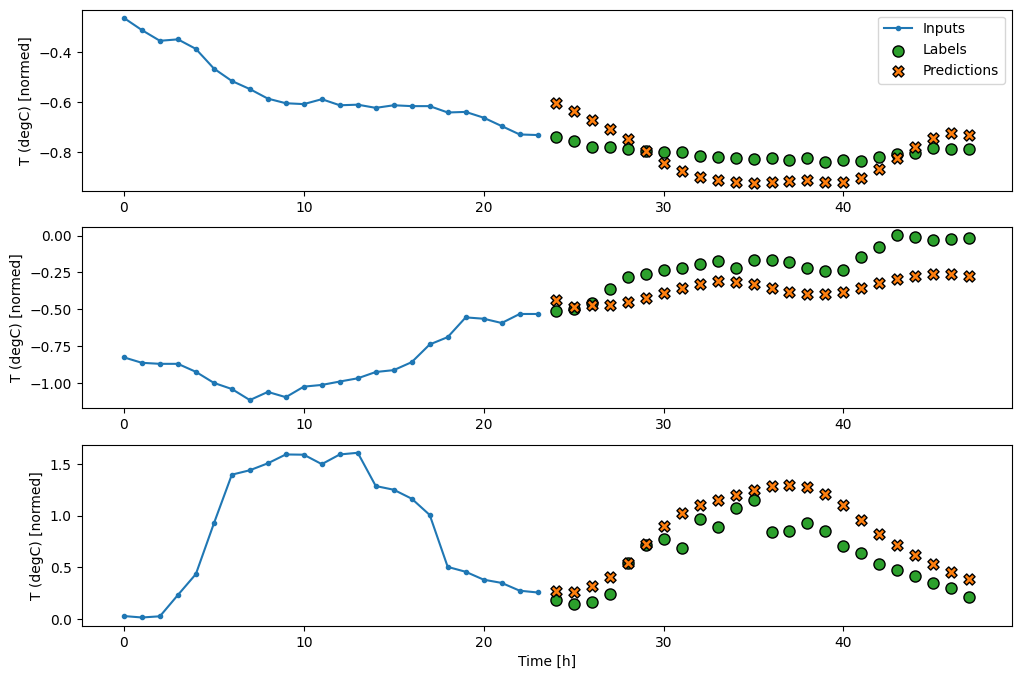

In [90]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

### Performance

There are clearly diminishing returns as a function of model complexity on this problem:

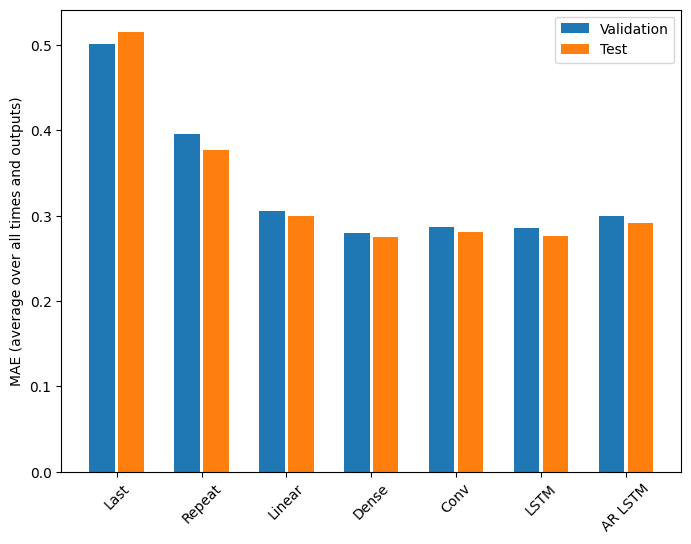

In [91]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

The metrics for the multi-output models in the first half of this tutorial show the performance averaged across all output features. These performances are similar but also averaged across output time steps. 

In [92]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Last    : 0.5157
Repeat  : 0.3774
Linear  : 0.2991
Dense   : 0.2746
Conv    : 0.2813
LSTM    : 0.2760
AR LSTM : 0.2913


The gains achieved going from a dense model to convolutional and recurrent models are only a few percent (if any), and the autoregressive model performed clearly worse. So these more complex approaches may not be worth while on **this** problem, but there was no way to know without trying, and these models could be helpful for **your** problem.

## Next steps

This tutorial was a quick introduction to time series forecasting using TensorFlow.

To learn more, refer to:

- Chapter 15 of <a href="https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/" class="external">Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow</a>, 2nd Edition.
- Chapter 6 of <a href="https://www.manning.com/books/deep-learning-with-python" class="external">Deep Learning with Python</a>.
- Lesson 8 of <a href="https://www.udacity.com/course/intro-to-tensorflow-for-deep-learning--ud187" class="external">Udacity's intro to TensorFlow for deep learning</a>, including the <a href="https://github.com/tensorflow/examples/tree/master/courses/udacity_intro_to_tensorflow_for_deep_learning" class="external">exercise notebooks</a>.

Also, remember that you can implement any <a href="https://otexts.com/fpp2/index.html" class="external">classical time series model</a> in TensorFlow—this tutorial just focuses on TensorFlow's built-in functionality.
